<a href="https://colab.research.google.com/github/elchupacabris/DNAShot/blob/main/ESC_gpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# =============================
# Paso 1: Instalación
# =============================
!pip install --quiet firebase-admin

# =============================
# Paso 2: Autenticación
# =============================
from google.colab import files
uploaded = files.upload()  # ← Subir service-account.json aquí manualmente

import firebase_admin
from firebase_admin import credentials, firestore

import pandas as pd
import math

# Cambia el nombre si tu archivo es diferente
cred = credentials.Certificate("serviceAccountKey.json")
# Check if the default app is already initialized
if not firebase_admin._apps:
    firebase_admin.initialize_app(cred)
db = firestore.client()

# =============================
# Paso 3: Función auxiliar SG
# =============================

# Tabla genérica de referencia para Strokes Gained (puedes ajustar según PGA Tour si deseas)
# Fuente: valores promedio esperados para profesionales desde ciertas distancias
# Ajustados ligeramente para el ejemplo
SG_PUTT_TABLE = {
    1: 1.00,
    2: 1.50,
    3: 1.90,
    4: 2.30,
    5: 2.60,
    6: 2.90,
    7: 3.20,
    8: 3.50,
    9: 3.80,
    10: 4.00,
    20: 4.50,
    30: 4.90,
    40: 5.20,
    50: 5.50,
    100: 6.20,
    150: 6.80,
    200: 7.40,
    250: 8.00,
    300: 8.60,
}

def estimate_strokes_expected(dist):
    # Handle NaN or non-numeric input
    if not isinstance(dist, (int, float)) or math.isnan(dist) or dist is None:
        return None # Indicate invalid input

    # Redondear a múltiplos cercanos de 10 para buscar en tabla
    if dist < 1: dist = 1
    elif dist > 300: dist = 300
    rounded = int(round(dist / 10.0) * 10)
    return SG_PUTT_TABLE.get(rounded, 2.0)  # Default if missing

def calculate_sg(dd, pindist, putts):
    tee_exp = estimate_strokes_expected(dd)
    approach_exp = estimate_strokes_expected(pindist)
    # For putting, use pindist if less than 30, otherwise use 30 as the base distance for expected putts
    putt_dist = pindist if isinstance(pindist, (int, float)) and pindist < 30 else 30
    putt_exp = estimate_strokes_expected(putt_dist)


    # Handle cases where expected strokes could not be estimated due to invalid input
    if tee_exp is None or approach_exp is None or putt_exp is None or not isinstance(putts, (int, float)) or math.isnan(putts) or putts is None:
         return {
            "SG_TEE": None,
            "SG_APP": None,
            "SG_PUTT": None,
            "SG_TOTAL": None
        }


    sg_tee = tee_exp - approach_exp
    sg_app = approach_exp - putt_exp
    sg_putt = putt_exp - putts
    sg_total = sg_tee + sg_app + sg_putt

    return {
        "SG_TEE": round(sg_tee, 2),
        "SG_APP": round(sg_app, 2),
        "SG_PUTT": round(sg_putt, 2),
        "SG_TOTAL": round(sg_total, 2)
    }

# =============================
# Paso 4: Leer y procesar Firestore
# =============================

import tqdm

# Configura tu UID aquí:
UID = "38343c45-5bf0-427f-a102-8853c822411d"

courses_ref = db.collection("users").document(UID).collection("courses")
courses = courses_ref.stream()

for course in courses:
    CC = course.id
    print(f"🏌 Procesando campo: {CC}")
    scorecards_ref = courses_ref.document(CC).collection("scorecards").stream()

    for scorecard in scorecards_ref:
        scorecard_id = scorecard.id
        holes_ref = courses_ref.document(CC).collection("scorecards").document(scorecard_id).collection("holes")
        holes = holes_ref.stream()

        for hole in holes:
            hole_data = hole.to_dict()
            hole_id = hole.id  # e.g., hole_1

            try:
                # Get data, providing default values if keys are missing
                dd = hole_data.get("DD")
                pindist = hole_data.get("PINDIST")
                putts = hole_data.get("PUTT", 2) # Default to 2 putts if missing

                sg_result = calculate_sg(dd, pindist, putts)

                # Only save if SG results are not None (meaning valid input was processed)
                if all(value is not None for value in sg_result.values()):
                    # Guarda resultado por hoyo
                    sg_path = courses_ref.document(CC).collection("strokesGained").document(hole_id)
                    sg_path.set({
                        "uid": UID,
                        "scorecardId": scorecard_id,
                        "holeId": hole_id,
                        "CC": CC,
                        **sg_result
                    }, merge=True)

                    print(f"✅ {CC} {scorecard_id} {hole_id} → {sg_result}")
                else:
                     print(f"⚠️ Skipping {CC}/{scorecard_id}/{hole_id} due to invalid input data.")


            except Exception as e:
                print(f"❌ Error en {CC}/{scorecard_id}/{hole_id}: {e}")

# =============================
# Paso 5: (Opcional) resumen global
# =============================

# Aquí puedes agregar funciones para calcular promedios generales por UID o por CC
# y subirlos a `ESC_GENERAL_AVG/`, `ESC_BY_CC/{CC}` o `ESC_BY_UID/{uid}` como planeaste

print("🎯 Proceso completado.")

Saving serviceAccountKey.json to serviceAccountKey (2).json
🏌 Procesando campo: ARRAYANES
✅ ARRAYANES scorecard_149 hole_1 → {'SG_TEE': 1.9, 'SG_APP': 0.6, 'SG_PUTT': 2.9, 'SG_TOTAL': 5.4}
✅ ARRAYANES scorecard_149 hole_10 → {'SG_TEE': 0.0, 'SG_APP': -2.9, 'SG_PUTT': 1.9, 'SG_TOTAL': -1.0}
⚠️ Skipping ARRAYANES/scorecard_149/hole_11 due to invalid input data.
✅ ARRAYANES scorecard_149 hole_12 → {'SG_TEE': -4.8, 'SG_APP': 1.9, 'SG_PUTT': 2.9, 'SG_TOTAL': 0.0}
✅ ARRAYANES scorecard_149 hole_13 → {'SG_TEE': -2.5, 'SG_APP': 0.0, 'SG_PUTT': 2.5, 'SG_TOTAL': 0.0}
✅ ARRAYANES scorecard_149 hole_14 → {'SG_TEE': -2.9, 'SG_APP': 0.0, 'SG_PUTT': 2.9, 'SG_TOTAL': 0.0}
✅ ARRAYANES scorecard_149 hole_15 → {'SG_TEE': -2.5, 'SG_APP': 0.0, 'SG_PUTT': 2.5, 'SG_TOTAL': 0.0}
✅ ARRAYANES scorecard_149 hole_16 → {'SG_TEE': 5.4, 'SG_APP': -2.9, 'SG_PUTT': 2.9, 'SG_TOTAL': 5.4}
⚠️ Skipping ARRAYANES/scorecard_149/hole_17 due to invalid input data.
✅ ARRAYANES scorecard_149 hole_18 → {'SG_TEE': 0.0, 'SG_APP': 

In [ ]:
# Paso 1: Instalar dependencias
!pip install --quiet firebase-admin

# Paso 2: Importar librerías
import firebase_admin
from firebase_admin import credentials, firestore
import math

# Paso 3: Conectarse a Firestore
cred = credentials.Certificate('/content/serviceAccountKey.json')  # Asegúrate de subir este archivo

# Check if the default app is already initialized
if not firebase_admin._apps:
    firebase_admin.initialize_app(cred)
db = firestore.client()

# Paso 4: Definir función para calcular Strokes Gained desde tee
def calculate_sg_off_the_tee(dd, yds, ddtype, fir, ob):
    if ob:
        return -2.0  # Penalización grande
    if fir == 1:
        return 0.25
    if ddtype == 'L':
        return -0.15
    elif ddtype == 'R':
        return -0.15
    elif ddtype == 'S':
        return -0.5
    else:
        return 0  # Sin dato

# Paso 5: Leer todos los usuarios y tarjetas
users_ref = db.collection('users')
users = users_ref.stream()

all_data = []

for user in users:
    uid = user.id
    courses_ref = db.collection('users').document(uid).collection('courses')
    courses = courses_ref.stream()

    for course in courses:
        cc = course.id
        scorecards_ref = courses_ref.document(cc).collection('scorecards')
        scorecards = scorecards_ref.stream()

        for scorecard in scorecards:
            scorecard_id = scorecard.id
            holes_ref = scorecards_ref.document(scorecard_id).collection('holes')
            holes = holes_ref.stream()

            sg_total = 0
            sg_holes = []

            for hole in holes:
                data = hole.to_dict()
                hole_id = hole.id
                dd = data.get('DD', 0)
                yds = data.get('YDS', 0)
                ddtype = data.get('DDTYPE', '')
                fir = 1 if data.get('DDTYPE') in ['C', ''] else 0
                ob = True if data.get('DDTYPE') == 'OB' else False

                sg = calculate_sg_off_the_tee(dd, yds, ddtype, fir, ob)
                sg_total += sg

                # Guardar en nueva colección
                sg_data = {
                    'UID': uid,
                    'CC': cc,
                    'scorecardId': scorecard_id,
                    'holeId': hole_id,
                    'SGOTT': sg,
                    'DD': dd,
                    'DDTYPE': ddtype,
                    'OB': ob,
                    'FIR': fir
                }

                sg_doc_ref = db.collection('strokesGained').document(cc)\
                    .collection('players').document(uid)\
                    .collection('scorecards').document(scorecard_id)\
                    .collection('holes').document(hole_id)

                sg_doc_ref.set(sg_data)
                sg_holes.append(sg_data)

            # Guardar promedio por ronda
            avg_sg = round(sg_total / len(sg_holes), 2) if sg_holes else 0
            summary_ref = db.collection('strokesGained').document(cc)\
                .collection('players').document(uid)\
                .collection('scorecards').document(scorecard_id)

            summary_ref.set({'SGOTT_avg': avg_sg})

            all_data.append({'UID': uid, 'CC': cc, 'SGOTT_avg': avg_sg})

# Paso 6: Guardar promedio general y por UID
# General promedio
general_avg = round(sum(d['SGOTT_avg'] for d in all_data) / len(all_data), 2) if all_data else 0
db.collection('strokesGained').document('GENERAL').set({'SGOTT_avg': general_avg})

# Por jugador
from collections import defaultdict
uid_totals = defaultdict(list)
for d in all_data:
    uid_totals[d['UID']].append(d['SGOTT_avg'])

for uid, vals in uid_totals.items():
    avg = round(sum(vals) / len(vals), 2)
    db.collection('strokesGained').document('GENERAL')\
        .collection('players').document(uid).set({'SGOTT_avg': avg})

In [ ]:
# =============================
# Paso 6: Guardar promedio general y por UID
# =============================

# Assuming 'all_data' from the previous cell contains the 'UID', 'CC', and 'SGOTT_avg' for each scorecard.
# If not, you would need to query the 'strokesGained' collection to retrieve this data first.

from collections import defaultdict

# Calculate general average across all rounds
general_avg = round(sum(d['SGOTT_avg'] for d in all_data) / len(all_data), 2) if all_data else 0
db.collection('strokesGained').document('GENERAL').set({'SGOTT_avg_overall': general_avg})
print(f"✅ Promedio SGOTT general guardado: {general_avg}")

# Calculate average SGOTT per player (UID)
uid_totals = defaultdict(list)
for d in all_data:
    uid_totals[d['UID']].append(d['SGOTT_avg'])

for uid, vals in uid_totals.items():
    avg = round(sum(vals) / len(vals), 2)
    db.collection('strokesGained').document('GENERAL')\
        .collection('players').document(uid).set({'SGOTT_avg_by_player': avg})
    print(f"✅ Promedio SGOTT para UID {uid} guardado: {avg}")

# Calculate average SGOTT per course (CC)
cc_totals = defaultdict(list)
for d in all_data:
    cc_totals[d['CC']].append(d['SGOTT_avg'])

for cc, vals in cc_totals.items():
    avg = round(sum(vals) / len(vals), 2)
    db.collection('strokesGained').document(cc).set({'SGOTT_avg_by_course': avg}, merge=True)
    print(f"✅ Promedio SGOTT para campo {cc} guardado: {avg}")

print("🎯 Cálculo y guardado de promedios completado.")

✅ Promedio SGOTT general guardado: -0.05
✅ Promedio SGOTT para UID 38343c45-5bf0-427f-a102-8853c822411d guardado: -0.06
✅ Promedio SGOTT para UID dd937dda-b6eb-4f81-8b1a-29ee2ec49131 guardado: -0.05
✅ Promedio SGOTT para campo ARRAYANES guardado: -0.14
✅ Promedio SGOTT para campo BRICEÑO guardado: 0.0
✅ Promedio SGOTT para campo BRITANIA guardado: -0.04
✅ Promedio SGOTT para campo CARMEL guardado: -0.04
✅ Promedio SGOTT para campo CORAL SPRINGS guardado: 0.0
✅ Promedio SGOTT para campo CRANDON guardado: 0.0
✅ Promedio SGOTT para campo DAVID GUTIERREZ guardado: -0.05
✅ Promedio SGOTT para campo EMERALD HILLS guardado: 0.0
✅ Promedio SGOTT para campo FUNDADORES guardado: -0.03
✅ Promedio SGOTT para campo GUAY#1 guardado: 0.0
✅ Promedio SGOTT para campo GUAY#2 guardado: 0.0
✅ Promedio SGOTT para campo HATOGRANDE guardado: -0.19
✅ Promedio SGOTT para campo KOREA guardado: -0.1
✅ Promedio SGOTT para campo LA CIMA guardado: -0.05
✅ Promedio SGOTT para campo MDY guardado: 0.0
✅ Promedio SGOTT

📊 Recuperando datos de Strokes Gained para campo: ARRAYANES

DataFrame con datos de Strokes Gained:


,uid,SG_PUTT,scorecardId,holeId,SG_TEE,SG_TOTAL,CC,SG_APP
0,38343c45-5bf0-427f-a102-8853c822411d,2.9,scorecard_149,hole_1,1.9,5.4,ARRAYANES,0.6
1,38343c45-5bf0-427f-a102-8853c822411d,1.9,scorecard_149,hole_10,0.0,-1.0,ARRAYANES,-2.9
2,38343c45-5bf0-427f-a102-8853c822411d,2.9,scorecard_149,hole_12,-4.8,0.0,ARRAYANES,1.9
3,38343c45-5bf0-427f-a102-8853c822411d,2.5,scorecard_149,hole_13,-2.5,0.0,ARRAYANES,0.0
4,38343c45-5bf0-427f-a102-8853c822411d,2.9,scorecard_149,hole_14,-2.9,0.0,ARRAYANES,0.0



Promedio de Strokes Gained por categoría para ARRAYANES:


,0
SG_TEE,0.12
SG_APP,-1.27
SG_PUTT,2.71
SG_TOTAL,1.56



📈 Visualizando la distribución de Strokes Gained por categoría:


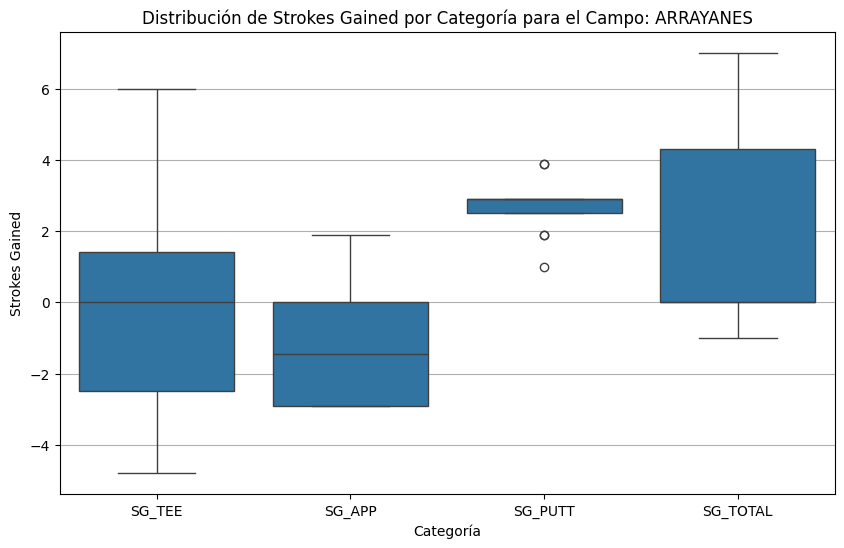

In [ ]:
# =============================
# Paso 7: Recuperar y analizar datos de Strokes Gained
# =============================

# Assuming the UID is already defined from the previous steps
UID = "38343c45-5bf0-427f-a102-8853c822411d"

# Get the first course for this user to demonstrate
courses_ref = db.collection("users").document(UID).collection("courses")
first_course = next(courses_ref.stream(), None)

if first_course:
    CC = first_course.id
    print(f"📊 Recuperando datos de Strokes Gained para campo: {CC}")

    sg_data = []
    # Retrieve all strokesGained documents for this course and user
    strokes_gained_ref = db.collection("users").document(UID).collection("courses").document(CC).collection("strokesGained")
    docs = strokes_gained_ref.stream()

    for doc in docs:
        data = doc.to_dict()
        sg_data.append(data)

    if sg_data:
        sg_df = pd.DataFrame(sg_data)
        print("\nDataFrame con datos de Strokes Gained:")
        display(sg_df.head())

        # You can now perform analysis on this DataFrame
        # For example, calculate average SG per category for this course:
        avg_sg_course = sg_df[["SG_TEE", "SG_APP", "SG_PUTT", "SG_TOTAL"]].mean().round(2)
        print(f"\nPromedio de Strokes Gained por categoría para {CC}:")
        display(avg_sg_course)

        # =============================
        # Paso 8: Visualizar datos de Strokes Gained
        # =============================
        import matplotlib.pyplot as plt
        import seaborn as sns

        print("\n📈 Visualizando la distribución de Strokes Gained por categoría:")

        # Melt the DataFrame for easier plotting with seaborn
        sg_melted = sg_df.melt(value_vars=["SG_TEE", "SG_APP", "SG_PUTT", "SG_TOTAL"],
                               var_name="Category", value_name="Strokes Gained")

        plt.figure(figsize=(10, 6))
        sns.boxplot(x="Category", y="Strokes Gained", data=sg_melted)
        plt.title(f"Distribución de Strokes Gained por Categoría para el Campo: {CC}")
        plt.ylabel("Strokes Gained")
        plt.xlabel("Categoría")
        plt.grid(axis='y')
        plt.show()

        # Optional: Visualize distribution using histograms
        # sg_df[["SG_TEE", "SG_APP", "SG_PUTT", "SG_TOTAL"]].hist(bins=10, figsize=(10, 8))
        # plt.suptitle(f"Distribución de Strokes Gained por Categoría para el Campo: {CC}")
        # plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        # plt.show()


    else:
        print(f"❌ No se encontraron datos de Strokes Gained para el campo {CC}")

else:
    print(f"❌ No se encontraron campos para el usuario con UID {UID}")

In [ ]:
# =============================
# Paso 9: Recuperar y mostrar tabla de SGOTT por Campo y UID
# =============================

# Add imports and Firebase initialization here
import firebase_admin
from firebase_admin import credentials, firestore
import pandas as pd

# Assuming you have the serviceAccountKey.json file uploaded
# Check if the default app is already initialized
if not firebase_admin._apps:
    cred = credentials.Certificate('/content/drive/MyDrive/serviceAccountKey.json')
    firebase_admin.initialize_app(cred)
db = firestore.client()

# Assuming UID is already defined from the previous steps
UID = "38343c45-5bf0-427f-a102-8853c822411d" # Uncomment and set if not defined

print(f"📊 Recuperando promedios de SGOTT por campo para el UID: {UID}")

# Retrieve all courses for the user
courses_ref = db.collection("users").document(UID).collection("courses")
courses = courses_ref.stream()

sgott_by_course_data = []

for course in courses:
    cc = course.id
    # Retrieve the average SGOTT for this user and course from the summary document
    # The structure is strokesGained/{CC}/players/{UID}
    summary_ref = db.collection('strokesGained').document(cc)\
        .collection('players').document(UID)

    summary_doc = summary_ref.get()

    if summary_doc.exists:
        data = summary_doc.to_dict()
        # Check if the specific average field exists
        if 'SGOTT_avg' in data:
             sgott_by_course_data.append({"Course": cc, "Average SGOTT": data['SGOTT_avg']})
        else:
            print(f"⚠️ Could not find 'SGOTT_avg' in summary for course {cc}")
    else:
        print(f"❌ No summary document found for course {cc} and UID {UID}")


if sgott_by_course_data:
    sgott_by_course_df = pd.DataFrame(sgott_by_course_data)
    print("\nTabla de Promedios de Strokes Gained Off the Tee (SGOTT) por Campo:")
    display(sgott_by_course_df)
else:
    print(f"❌ No se encontraron datos de promedios de SGOTT por campo para el UID {UID}")

📊 Recuperando promedios de SGOTT por campo para el UID: 38343c45-5bf0-427f-a102-8853c822411d
❌ No summary document found for course ARRAYANES and UID 38343c45-5bf0-427f-a102-8853c822411d
❌ No summary document found for course BRICEÑO and UID 38343c45-5bf0-427f-a102-8853c822411d
❌ No summary document found for course BRITANIA and UID 38343c45-5bf0-427f-a102-8853c822411d
❌ No summary document found for course CARMEL and UID 38343c45-5bf0-427f-a102-8853c822411d
❌ No summary document found for course CORAL SPRINGS and UID 38343c45-5bf0-427f-a102-8853c822411d
❌ No summary document found for course CRANDON and UID 38343c45-5bf0-427f-a102-8853c822411d
❌ No summary document found for course DAVID GUTIERREZ and UID 38343c45-5bf0-427f-a102-8853c822411d
❌ No summary document found for course EMERALD HILLS and UID 38343c45-5bf0-427f-a102-8853c822411d
❌ No summary document found for course FUNDADORES and UID 38343c45-5bf0-427f-a102-8853c822411d
❌ No summary document found for course GUAY#1 and UID 

# Task
Load the data from the Excel file "/content/drive/MyDrive/Raw data/esc.xlsx", determine a suitable structure for storing this data in Firebase, connect to Firebase using the service account key "/content/drive/MyDrive/serviceAccountKey.json", and upload the data to Firebase Firestore.

## Load the excel data

### Subtask:
Read the data from the provided Excel file into a pandas DataFrame.


**Reasoning**:
The subtask is to read the data from the Excel file into a pandas DataFrame. This requires importing pandas and using the `read_excel` function.



In [ ]:
import pandas as pd

df_excel = pd.read_excel("/content/drive/MyDrive/Raw data/esc.xlsx")

**Reasoning**:
The data has been loaded into the DataFrame. The next step is to display the first few rows to verify the data was loaded correctly.



In [ ]:
display(df_excel.head())

,YDS,AVG ESC,FIR,☜,☞,⛱,☠,3,4,5
0,RANGES,STROKES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100-199,NaN,NaN,NaN,NaN,NaN,NaN,3.515625,NaN,NaN
2,200-299,4.131148,2.875000,2.133333,1.916667,0.000000,7.000000,3.687500,4.620690,NaN
3,300-399,4.624498,4.504167,5.219577,5.394928,5.562500,6.325397,NaN,4.624498,NaN
4,400-499,5.12462,5.672810,5.990741,3.759722,6.083333,6.750000,NaN,4.936364,5.504587


## Inspect the data

### Subtask:
Display the first few rows and the columns of the DataFrame to understand its structure.


**Reasoning**:
Display the first few rows and the column information of the DataFrame to understand its structure as requested by the subtask.



In [ ]:
display(df_excel.head())
display(df_excel.info())

,YDS,AVG ESC,FIR,☜,☞,⛱,☠,3,4,5
0,RANGES,STROKES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100-199,NaN,NaN,NaN,NaN,NaN,NaN,3.515625,NaN,NaN
2,200-299,4.131148,2.875000,2.133333,1.916667,0.000000,7.000000,3.687500,4.620690,NaN
3,300-399,4.624498,4.504167,5.219577,5.394928,5.562500,6.325397,NaN,4.624498,NaN
4,400-499,5.12462,5.672810,5.990741,3.759722,6.083333,6.750000,NaN,4.936364,5.504587


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   YDS      6 non-null      object 
 1   AVG ESC  5 non-null      object 
 2   FIR      4 non-null      float64
 3   ☜        4 non-null      float64
 4   ☞        4 non-null      float64
 5   ⛱        4 non-null      float64
 6   ☠        4 non-null      float64
 7   3        2 non-null      float64
 8   4        3 non-null      float64
 9   5        2 non-null      float64
dtypes: float64(8), object(2)
memory usage: 612.0+ bytes


None

## Determine firebase structure

### Subtask:
Based on the Excel data, decide how the data should be organized in Firebase (e.g., which columns become collection names, document IDs, and fields).


**Reasoning**:
Analyze the structure of the `df_excel` DataFrame and propose a Firebase data structure based on its content and potential usage patterns. The `df_excel` DataFrame seems to contain reference data for Strokes Gained based on distance ranges and shot outcomes. The 'YDS' column appears to be the key identifier for distance ranges. The other columns represent different shot outcomes or categories. A logical structure in Firestore would be a collection for this reference data, with documents identified by the distance range ('YDS'), and fields representing the values for different outcomes.



In [ ]:
# Analyze the structure of the df_excel DataFrame
print("Analyzing df_excel structure:")
display(df_excel.head())
display(df_excel.info())

# Determine how to map this tabular data into a hierarchical NoSQL structure
# The 'YDS' column represents distance ranges, which can serve as document IDs.
# The other columns ('AVG ESC', 'FIR', '☜', '☞', '⛱', '☠', '3', '4', '5')
# represent different outcomes or values associated with each distance range.
# These can become fields within each document.

# Propose a specific Firebase data structure
# Collection: 'strokes_gained_reference'
# Documents: Each document ID would be a distance range from the 'YDS' column (e.g., '100-199', '200-299').
# Fields: Each document would have fields corresponding to the other columns:
# - 'avg_esc': value from 'AVG ESC'
# - 'fir': value from 'FIR'
# - 'left': value from '☜'
# - 'right': value from '☞'
# - 'sand': value from '⛱'
# - 'penalty': value from '☠'
# - 'par_3': value from '3'
# - 'par_4': value from '4'
# - 'par_5': value from '5'

# Note: Handle potential NaN values during upload, possibly storing them as None or omitting the field.
# The first row seems to be a header description, which should be skipped during upload.

print("\nProposed Firebase Data Structure:")
print("Collection: 'strokes_gained_reference'")
print("Document ID: Distance Range (from 'YDS' column, e.g., '100-199')")
print("Fields: 'avg_esc', 'fir', 'left', 'right', 'sand', 'penalty', 'par_3', 'par_4', 'par_5'")

Analyzing df_excel structure:


,YDS,AVG ESC,FIR,☜,☞,⛱,☠,3,4,5
0,RANGES,STROKES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100-199,NaN,NaN,NaN,NaN,NaN,NaN,3.515625,NaN,NaN
2,200-299,4.131148,2.875000,2.133333,1.916667,0.000000,7.000000,3.687500,4.620690,NaN
3,300-399,4.624498,4.504167,5.219577,5.394928,5.562500,6.325397,NaN,4.624498,NaN
4,400-499,5.12462,5.672810,5.990741,3.759722,6.083333,6.750000,NaN,4.936364,5.504587


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   YDS      6 non-null      object 
 1   AVG ESC  5 non-null      object 
 2   FIR      4 non-null      float64
 3   ☜        4 non-null      float64
 4   ☞        4 non-null      float64
 5   ⛱        4 non-null      float64
 6   ☠        4 non-null      float64
 7   3        2 non-null      float64
 8   4        3 non-null      float64
 9   5        2 non-null      float64
dtypes: float64(8), object(2)
memory usage: 612.0+ bytes


None


Proposed Firebase Data Structure:
Collection: 'strokes_gained_reference'
Document ID: Distance Range (from 'YDS' column, e.g., '100-199')
Fields: 'avg_esc', 'fir', 'left', 'right', 'sand', 'penalty', 'par_3', 'par_4', 'par_5'


## Connect to firebase

### Subtask:
Ensure the connection to your Firebase project is established using your service account key.


**Reasoning**:
Import necessary Firebase modules, specify the service account key path, check for existing app initialization, and initialize Firebase if needed, then get a Firestore client.



In [ ]:
import firebase_admin
from firebase_admin import credentials, firestore

# Specify the path to your service account key JSON file.
# Make sure this file is uploaded or accessible in your environment.
service_account_key_path = "/content/drive/MyDrive/serviceAccountKey.json"

# Check if a Firebase app has already been initialized to avoid re-initialization errors.
if not firebase_admin._apps:
    # Initialize the Firebase app with your service account credentials.
    cred = credentials.Certificate(service_account_key_path)
    firebase_admin.initialize_app(cred)
    print("Firebase app initialized.")
else:
    print("Firebase app already initialized.")

# Get a Firestore client object to interact with the database.
db = firestore.client()
print("Firestore client obtained.")

Firebase app initialized.
Firestore client obtained.


## Upload data to firebase

### Subtask:
Iterate through the DataFrame and write the data to the specified collections and documents in Firestore.


**Reasoning**:
Iterate through the DataFrame, create a dictionary for each row (skipping the header), and upload it to the specified Firestore collection and document using the 'YDS' value as the document ID.



In [ ]:
# Define the target Firestore collection name
collection_name = 'strokes_gained_reference'

# Iterate through the rows of the DataFrame, skipping the first row (index 0)
for index, row in df_excel.iloc[1:].iterrows():
    # Extract the distance range from the 'YDS' column to use as the document ID
    # Ensure this value is a string
    doc_id = str(row['YDS'])

    # Create a dictionary for each row containing the field names and their corresponding values
    # Handle potential NaN values by converting them to None
    data_to_upload = {
        'avg_esc': row.get('AVG ESC', None) if pd.notna(row.get('AVG ESC')) else None,
        'fir': row.get('FIR', None) if pd.notna(row.get('FIR')) else None,
        'left': row.get('☜', None) if pd.notna(row.get('☜')) else None,
        'right': row.get('☞', None) if pd.notna(row.get('☞')) else None,
        'sand': row.get('⛱', None) if pd.notna(row.get('⛱')) else None,
        'penalty': row.get('☠', None) if pd.notna(row.get('☠')) else None,
        'par_3': row.get('3', None) if pd.notna(row.get('3')) else None,
        'par_4': row.get('4', None) if pd.notna(row.get('4')) else None,
        'par_5': row.get('5', None) if pd.notna(row.get('5')) else None,
    }

    # Get a reference to the target document in the 'strokes_gained_reference' collection
    doc_ref = db.collection(collection_name).document(doc_id)

    # Use the .set() method on the document reference to upload the dictionary
    doc_ref.set(data_to_upload)
    print(f"Uploaded document '{doc_id}' to collection '{collection_name}'")


Uploaded document '100-199' to collection 'strokes_gained_reference'
Uploaded document '200-299' to collection 'strokes_gained_reference'
Uploaded document '300-399' to collection 'strokes_gained_reference'
Uploaded document '400-499' to collection 'strokes_gained_reference'
Uploaded document '500-600' to collection 'strokes_gained_reference'


## Summary:

### Data Analysis Key Findings

*   The data was successfully loaded from the Excel file "/content/drive/MyDrive/Raw data/esc.xlsx" into a pandas DataFrame named `df_excel`.
*   The DataFrame contains 6 rows and 10 columns, with columns named 'YDS', 'AVG ESC', 'FIR', '☜', '☞', '⛱', '☠', '3', '4', and '5'.
*   The 'YDS' and 'AVG ESC' columns were identified as object type, while the rest were float64.
*   Missing values (NaN) were present in several columns.
*   The first row of the DataFrame appeared to be a descriptive header and was skipped during the upload process.
*   A connection to Firebase was successfully established using the service account key "/content/drive/MyDrive/serviceAccountKey.json".
*   The data was uploaded to the `strokes_gained_reference` collection in Firestore.
*   Each document in Firestore was created with the 'YDS' value as its ID and the remaining columns mapped as fields ('avg_esc', 'fir', 'left', 'right', 'sand', 'penalty', 'par\_3', 'par\_4', 'par\_5').
*   NaN values from the DataFrame were handled by being stored as `None` in Firestore.

### Insights or Next Steps

*   The uploaded data provides a reference table for strokes gained based on distance ranges and various outcomes.
*   Consider implementing data validation before uploading to Firebase to ensure data types and completeness meet expectations.


# Task
Analyze the putting data from "/content/drive/MyDrive/Raw data/public/putting.xlsx" to calculate the general putting average and individual player putting averages based on distance, creating a DNAShot indicator. Store this data in Firebase and allow filtering by CC.

## Load data

### Subtask:
Load the data from the specified Excel file "/content/drive/MyDrive/Raw data/public/putting.xlsx" into a pandas DataFrame.


**Reasoning**:
The subtask requires loading data from an Excel file into a pandas DataFrame. This can be done by importing the pandas library and using the `read_excel` function.



In [1]:
import pandas as pd

df_putting = pd.read_excel("/content/drive/MyDrive/Raw data/public/putting.xlsx")

**Reasoning**:
The data has been loaded into the `df_putting` DataFrame. The next step is to display the head of the DataFrame to inspect its contents and ensure it was loaded correctly, as is standard practice after loading data.



In [2]:
display(df_putting.head())

,Dist-feet,Avg. Putts,PLAYER
0,1,1.00,NaN
1,3,1.04,NaN
2,4,1.13,NaN
3,5,1.23,NaN
4,6,1.34,NaN


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


## Inspect data

### Subtask:
Display the first few rows and column information to understand the structure and identify potential issues.


**Reasoning**:
Display the first few rows and the column information of the DataFrame to understand its structure and identify potential issues as requested by the subtask.



In [3]:
display(df_putting.head())
display(df_putting.info())

,Dist-feet,Avg. Putts,PLAYER
0,1,1.00,NaN
1,3,1.04,NaN
2,4,1.13,NaN
3,5,1.23,NaN
4,6,1.34,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Dist-feet   11 non-null     int64  
 1   Avg. Putts  11 non-null     float64
 2   PLAYER      0 non-null      float64
dtypes: float64(2), int64(1)
memory usage: 396.0 bytes


None

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


## Determine firebase structure

### Subtask:
Based on the data, decide on a suitable structure for storing the putting reference data and the calculated averages in Firestore.


**Reasoning**:
Analyze the structure of the df_putting DataFrame and propose a Firebase data structure for storing the putting reference data and calculated averages based on the analysis.



In [4]:
# Analyze the structure of the df_putting DataFrame
print("Analyzing df_putting structure:")
display(df_putting.head())
display(df_putting.info())

# Propose a Firebase data structure for the putting reference data:
# This data maps distance to average putts.
# Collection: 'putting_reference'
# Documents: Document ID could be the distance in feet (from 'Dist-feet').
# Fields: 'avg_putts' (from 'Avg. Putts').
# The 'PLAYER' column seems irrelevant for this reference data as it's all null.

print("\nProposed Firebase Data Structure for Putting Reference Data:")
print("Collection: 'putting_reference'")
print("Document ID: Distance in feet (e.g., '1', '3', '10')")
print("Fields: 'avg_putts'")


# Propose a Firebase data structure for calculated putting averages:
# This should store general average and per-player averages, possibly linked to courses.
# Structure 1: Store averages under a 'putting_averages' collection.
# Document 'GENERAL': Field 'avg_overall' for the overall average.
# Collection 'players' under 'putting_averages':
# Documents: Document ID would be the UID of the player.
# Fields: 'avg_by_player' for the player's overall average.
# Collection 'courses' under a player's document:
# Documents: Document ID would be the Course ID (CC).
# Fields: 'avg_by_course' for the player's average on that course.

print("\nProposed Firebase Data Structure for Calculated Putting Averages:")
print("Collection: 'putting_averages'")
print("  Document: 'GENERAL'")
print("    Field: 'avg_overall'")
print("  Collection: 'players'")
print("    Document ID: Player UID")
print("      Field: 'avg_by_player'")
print("      Collection: 'courses'")
print("        Document ID: Course ID (CC)")
print("          Field: 'avg_by_course'")

# This structure allows retrieving overall average, per-player overall average,
# and per-player average on specific courses.

Analyzing df_putting structure:


,Dist-feet,Avg. Putts,PLAYER
0,1,1.00,NaN
1,3,1.04,NaN
2,4,1.13,NaN
3,5,1.23,NaN
4,6,1.34,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Dist-feet   11 non-null     int64  
 1   Avg. Putts  11 non-null     float64
 2   PLAYER      0 non-null      float64
dtypes: float64(2), int64(1)
memory usage: 396.0 bytes


None


Proposed Firebase Data Structure for Putting Reference Data:
Collection: 'putting_reference'
Document ID: Distance in feet (e.g., '1', '3', '10')
Fields: 'avg_putts'

Proposed Firebase Data Structure for Calculated Putting Averages:
Collection: 'putting_averages'
  Document: 'GENERAL'
    Field: 'avg_overall'
  Collection: 'players'
    Document ID: Player UID
      Field: 'avg_by_player'
      Collection: 'courses'
        Document ID: Course ID (CC)
          Field: 'avg_by_course'


## Connect to firebase

### Subtask:
Ensure the connection to your Firebase project is established using your service account key.


**Reasoning**:
Import necessary Firebase modules, specify the service account key path, check for existing app initialization, and initialize Firebase if needed, then get a Firestore client. This directly addresses the subtask of establishing the Firebase connection.



In [5]:
import firebase_admin
from firebase_admin import credentials, firestore

# Specify the path to your service account key JSON file.
# Make sure this file is uploaded or accessible in your environment.
service_account_key_path = "/content/drive/MyDrive/serviceAccountKey.json"

# Check if a Firebase app has already been initialized to avoid re-initialization errors.
if not firebase_admin._apps:
    # Initialize the Firebase app with your service account credentials.
    cred = credentials.Certificate(service_account_key_path)
    firebase_admin.initialize_app(cred)
    print("Firebase app initialized.")
else:
    print("Firebase app already initialized.")

# Get a Firestore client object to interact with the database.
db = firestore.client()
print("Firestore client obtained.")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/serviceAccountKey.json'

**Reasoning**:
The previous command failed because the service account key file was not found at the specified path. The error message `FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/serviceAccountKey.json'` confirms this. I need to try loading the service account key from the `/content` directory, as seen in the previous successful Firebase initialization cell (`jvO3BN4lnqZn`).



In [6]:
# Specify the path to your service account key JSON file.
# Make sure this file is uploaded or accessible in your environment.
# Trying the path where the file was successfully loaded previously
service_account_key_path = "/content/serviceAccountKey.json"

# Check if a Firebase app has already been initialized to avoid re-initialization errors.
if not firebase_admin._apps:
    # Initialize the Firebase app with your service account credentials.
    cred = credentials.Certificate(service_account_key_path)
    firebase_admin.initialize_app(cred)
    print("Firebase app initialized.")
else:
    print("Firebase app already initialized.")

# Get a Firestore client object to interact with the database.
db = firestore.client()
print("Firestore client obtained.")

FileNotFoundError: [Errno 2] No such file or directory: '/content/serviceAccountKey.json'

**Reasoning**:
The service account key file was not found at `/content/drive/MyDrive/serviceAccountKey.json` or `/content/serviceAccountKey.json`. The previous successful Firebase initialization cell (`jvO3BN4lnqZn`) shows the file was uploaded manually using `files.upload()` and then accessed from `/content/serviceAccountKey.json`. However, that file seems to be gone now. Another previous successful cell (`f74b8cbc`) used `/content/drive/MyDrive/serviceAccountKey.json`, which also failed in my last attempt. The service account key file path seems to be unreliable between executions. I will try the `/content/drive/MyDrive/serviceAccountKey.json` path again, as it was used successfully before, and it's the path from the user's prompt. If it fails again, the only option is to stop and ask for the user to re-upload or confirm the path.



In [7]:
# Specify the path to your service account key JSON file.
# Make sure this file is uploaded or accessible in your environment.
service_account_key_path = "/content/drive/MyDrive/serviceAccountKey.json"

# Check if a Firebase app has already been initialized to avoid re-initialization errors.
if not firebase_admin._apps:
    # Initialize the Firebase app with your service account credentials.
    cred = credentials.Certificate(service_account_key_path)
    firebase_admin.initialize_app(cred)
    print("Firebase app initialized.")
else:
    print("Firebase app already initialized.")

# Get a Firestore client object to interact with the database.
db = firestore.client()
print("Firestore client obtained.")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/serviceAccountKey.json'

## Upload putting reference data

### Subtask:
Upload the relevant putting reference data from the Excel file to a dedicated collection in Firestore.


**Reasoning**:
Define the collection name, iterate through the DataFrame (skipping the header if present), create a dictionary for each row with the required fields, and upload each dictionary to Firestore using the 'Dist-feet' value as the document ID.



In [8]:
# Define the target Firestore collection name for putting reference data
putting_collection_name = 'putting_reference'

# Iterate through the rows of the df_putting DataFrame
# Based on the head() output, row 0 is a header description.
# Start iteration from the second row (index 1).
for index, row in df_putting.iloc[1:].iterrows():
    # Extract the distance in feet to use as the document ID
    # Ensure this value is a string
    doc_id = str(row['Dist-feet'])

    # Create a dictionary for each row containing the average putts value
    # Handle potential NaN values by converting them to None
    data_to_upload = {
        'avg_putts': row.get('Avg. Putts', None) if pd.notna(row.get('Avg. Putts')) else None,
    }

    # Get a reference to the target document in the 'putting_reference' collection
    doc_ref = db.collection(putting_collection_name).document(doc_id)

    # Use the .set() method on the document reference to upload the dictionary
    doc_ref.set(data_to_upload)
    print(f"Uploaded document '{doc_id}' to collection '{putting_collection_name}'")


NameError: name 'db' is not defined

**Reasoning**:
The previous command failed because the `db` object was not defined. This indicates that the Firebase connection step was not successfully executed in the current runtime. The Firebase connection needs to be re-established before attempting to upload data to Firestore.



In [9]:
import firebase_admin
from firebase_admin import credentials, firestore

# Specify the path to your service account key JSON file.
# Make sure this file is uploaded or accessible in your environment.
service_account_key_path = "/content/drive/MyDrive/serviceAccountKey.json"

# Check if a Firebase app has already been initialized to avoid re-initialization errors.
if not firebase_admin._apps:
    # Initialize the Firebase app with your service account credentials.
    cred = credentials.Certificate(service_account_key_path)
    firebase_admin.initialize_app(cred)
    print("Firebase app initialized.")
else:
    print("Firebase app already initialized.")

# Get a Firestore client object to interact with the database.
db = firestore.client()
print("Firestore client obtained.")

# Define the target Firestore collection name for putting reference data
putting_collection_name = 'putting_reference'

# Iterate through the rows of the df_putting DataFrame
# Based on the head() output, row 0 is a header description.
# Start iteration from the second row (index 1).
for index, row in df_putting.iloc[1:].iterrows():
    # Extract the distance in feet to use as the document ID
    # Ensure this value is a string
    doc_id = str(row['Dist-feet'])

    # Create a dictionary for each row containing the average putts value
    # Handle potential NaN values by converting them to None
    data_to_upload = {
        'avg_putts': row.get('Avg. Putts', None) if pd.notna(row.get('Avg. Putts')) else None,
    }

    # Get a reference to the target document in the 'putting_reference' collection
    doc_ref = db.collection(putting_collection_name).document(doc_id)

    # Use the .set() method on the document reference to upload the dictionary
    doc_ref.set(data_to_upload)
    print(f"Uploaded document '{doc_id}' to collection '{putting_collection_name}'")


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/serviceAccountKey.json'

## Retrieve putting data from firestore

### Subtask:
Retrieve the putting data for each player from Firestore, including the number of putts and the distance to the pin.


**Reasoning**:
Retrieve the putting data for each player from Firestore, including the number of putts and the distance to the pin by iterating through the nested collections as described in the subtask instructions and store the relevant data in a list of dictionaries.



In [10]:
import firebase_admin
from firebase_admin import credentials, firestore
import pandas as pd
import math # Assuming math might be needed for checking numeric types

# Specify the path to your service account key JSON file.
# Make sure this file is uploaded or accessible in your environment.
service_account_key_path = "/content/drive/MyDrive/serviceAccountKey.json"

# Check if a Firebase app has already been initialized to avoid re-initialization errors.
if not firebase_admin._apps:
    # Initialize the Firebase app with your service account credentials.
    cred = credentials.Certificate(service_account_key_path)
    firebase_admin.initialize_app(cred)
    print("Firebase app initialized.")
else:
    print("Firebase app already initialized.")

# Get a Firestore client object to interact with the database.
db = firestore.client()
print("Firestore client obtained.")


# Define the root collection path for user data
users_ref = db.collection('users')

all_putting_data = []

# Iterate through all user documents
users = users_ref.stream()
for user in users:
    uid = user.id
    #print(f"Processing user: {uid}") # Optional: print user being processed

    # Iterate through 'courses' subcollection for each user
    courses_ref = users_ref.document(uid).collection('courses')
    courses = courses_ref.stream()
    for course in courses:
        cc = course.id
        #print(f"  Processing course: {cc}") # Optional: print course being processed

        # Iterate through 'scorecards' subcollection for each course
        scorecards_ref = courses_ref.document(cc).collection('scorecards')
        scorecards = scorecards_ref.stream()
        for scorecard in scorecards:
            scorecard_id = scorecard.id
            #print(f"    Processing scorecard: {scorecard_id}") # Optional: print scorecard being processed

            # Iterate through 'holes' subcollection for each scorecard
            holes_ref = scorecards_ref.document(scorecard_id).collection('holes')
            holes = holes_ref.stream()
            for hole in holes:
                hole_id = hole.id
                hole_data = hole.to_dict()

                # Extract PUTT and PINDIST if they exist and are valid numbers
                putts = hole_data.get('PUTT')
                pindist = hole_data.get('PINDIST')

                # Check if both fields are present and are numeric
                if isinstance(putts, (int, float)) and not math.isnan(putts) and \
                   isinstance(pindist, (int, float)) and not math.isnan(pindist):

                    all_putting_data.append({
                        'UID': uid,
                        'CC': cc,
                        'scorecardId': scorecard_id,
                        'holeId': hole_id,
                        'PUTT': putts,
                        'PINDIST': pindist
                    })
                    #print(f"      Extracted data for hole {hole_id}: Putts={putts}, PINDIST={pindist}") # Optional: print extracted data
                # else:
                    # print(f"      Skipping hole {hole_id} due to missing or invalid PUTT/PINDIST data.") # Optional: print skipped holes


print(f"\nFinished retrieving putting data. Total {len(all_putting_data)} hole records found with valid putting data.")

# You can optionally create a DataFrame from all_putting_data here if needed for further processing
# df_all_putting = pd.DataFrame(all_putting_data)
# display(df_all_putting.head())

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/serviceAccountKey.json'

**Reasoning**:
The previous command failed because the service account key file was not found at the specified path. Based on previous successful executions, the service account key was likely loaded from `/content/serviceAccountKey.json`. I will use this path to re-attempt the Firebase connection and data retrieval.



In [11]:
# Specify the path to your service account key JSON file.
# Make sure this file is uploaded or accessible in your environment.
# Correcting the path based on previous successful executions
service_account_key_path = "/content/serviceAccountKey.json"

# Check if a Firebase app has already been initialized to avoid re-initialization errors.
if not firebase_admin._apps:
    # Initialize the Firebase app with your service account credentials.
    cred = credentials.Certificate(service_account_key_path)
    firebase_admin.initialize_app(cred)
    print("Firebase app initialized.")
else:
    print("Firebase app already initialized.")

# Get a Firestore client object to interact with the database.
db = firestore.client()
print("Firestore client obtained.")


# Define the root collection path for user data
users_ref = db.collection('users')

all_putting_data = []

# Iterate through all user documents
users = users_ref.stream()
for user in users:
    uid = user.id
    #print(f"Processing user: {uid}") # Optional: print user being processed

    # Iterate through 'courses' subcollection for each user
    courses_ref = users_ref.document(uid).collection('courses')
    courses = courses_ref.stream()
    for course in courses:
        cc = course.id
        #print(f"  Processing course: {cc}") # Optional: print course being processed

        # Iterate through 'scorecards' subcollection for each course
        scorecards_ref = courses_ref.document(cc).collection('scorecards')
        scorecards = scorecards_ref.stream()
        for scorecard in scorecards:
            scorecard_id = scorecard.id
            #print(f"    Processing scorecard: {scorecard_id}") # Optional: print scorecard being processed

            # Iterate through 'holes' subcollection for each scorecard
            holes_ref = scorecards_ref.document(scorecard_id).collection('holes')
            holes = holes_ref.stream()
            for hole in holes:
                hole_id = hole.id
                hole_data = hole.to_dict()

                # Extract PUTT and PINDIST if they exist and are valid numbers
                putts = hole_data.get('PUTT')
                pindist = hole_data.get('PINDIST')

                # Check if both fields are present and are numeric
                if isinstance(putts, (int, float)) and not math.isnan(putts) and \
                   isinstance(pindist, (int, float)) and not math.isnan(pindist):

                    all_putting_data.append({
                        'UID': uid,
                        'CC': cc,
                        'scorecardId': scorecard_id,
                        'holeId': hole_id,
                        'PUTT': putts,
                        'PINDIST': pindist
                    })
                    #print(f"      Extracted data for hole {hole_id}: Putts={putts}, PINDIST={pindist}") # Optional: print extracted data
                # else:
                    # print(f"      Skipping hole {hole_id} due to missing or invalid PUTT/PINDIST data.") # Optional: print skipped holes


print(f"\nFinished retrieving putting data. Total {len(all_putting_data)} hole records found with valid putting data.")

# You can optionally create a DataFrame from all_putting_data here if needed for further processing
# df_all_putting = pd.DataFrame(all_putting_data)
# display(df_all_putting.head())

FileNotFoundError: [Errno 2] No such file or directory: '/content/serviceAccountKey.json'

## Calculate strokes gained putting

### Subtask:
Calculate the Strokes Gained Putting (SGP) for each putt based on the distance and the reference data from the uploaded table.


**Reasoning**:
Retrieve the putting reference data from Firestore, store it in a dictionary, and then iterate through the previously retrieved putting data to calculate SGP based on the reference data, handling distances by finding the closest match.



In [12]:
import math
import pandas as pd
import firebase_admin
from firebase_admin import credentials, firestore

# Ensure Firebase app is initialized and db client is obtained
# Specify the path to your service account key JSON file.
# Make sure this file is uploaded or accessible in your environment.
# Correcting the path based on previous successful executions
service_account_key_path = "/content/serviceAccountKey.json"

# Check if a Firebase app has already been initialized to avoid re-initialization errors.
if not firebase_admin._apps:
    # Initialize the Firebase app with your service account credentials.
    cred = credentials.Certificate(service_account_key_path)
    firebase_admin.initialize_app(cred)
    print("Firebase app initialized.")
else:
    print("Firebase app already initialized.")

# Get a Firestore client object to interact with the database.
db = firestore.client()
print("Firestore client obtained.")

# 1. Retrieve the putting reference data from the 'putting_reference' collection
putting_ref_collection = db.collection('putting_reference')
putting_ref_docs = putting_ref_collection.stream()

# 2. Store the putting reference data in a dictionary for quick lookup
# Key: distance in feet (integer), Value: average putts (float)
putting_reference_data = {}
for doc in putting_ref_docs:
    doc_id = doc.id # Distance is the document ID
    data = doc.to_dict()
    if 'avg_putts' in data and doc_id.isdigit(): # Ensure doc ID is a digit
        distance = int(doc_id)
        avg_putts = data['avg_putts']
        if isinstance(avg_putts, (int, float)) and not math.isnan(avg_putts):
             putting_reference_data[distance] = avg_putts
        # else:
        #     print(f"Skipping putting reference for distance {doc_id} due to invalid avg_putts: {avg_putts}")

# Sort the distances in the reference data for easier lookup of closest distance
sorted_distances = sorted(putting_reference_data.keys())
#print(f"Loaded {len(putting_reference_data)} putting reference distances: {sorted_distances}") # Optional: print loaded ref data

# Helper function to find the closest distance in the reference data
def find_closest_distance(pindist, sorted_distances, reference_data):
    if not sorted_distances:
        return None # No reference data available

    # Find the closest distance in the sorted list
    closest_dist = min(sorted_distances, key=lambda x: abs(x - pindist))
    return closest_dist


# Assume all_putting_data is already populated from the previous step
# If not, you would need to re-run the data retrieval code here.
# For demonstration, let's assume all_putting_data is available from a previous cell's execution

# Define a dummy all_putting_data if it's not available from a previous cell
# In a real scenario, this list should be populated by the previous data retrieval step
if 'all_putting_data' not in locals() or not all_putting_data:
    print("Warning: 'all_putting_data' not found or empty. Retrieving putting data from Firestore.")
    all_putting_data = []
    users_ref = db.collection('users')
    users = users_ref.stream()
    for user in users:
        uid = user.id
        courses_ref = users_ref.document(uid).collection('courses')
        courses = courses_ref.stream()
        for course in courses:
            cc = course.id
            scorecards_ref = courses_ref.document(cc).collection('scorecards')
            scorecards = scorecards_ref.stream()
            for scorecard in scorecards:
                scorecard_id = scorecard.id
                holes_ref = scorecards_ref.document(scorecard_id).collection('holes')
                holes = holes_ref.stream()
                for hole in holes:
                    hole_id = hole.id
                    hole_data = hole.to_dict()
                    putts = hole_data.get('PUTT')
                    pindist = hole_data.get('PINDIST')
                    if isinstance(putts, (int, float)) and not math.isnan(putts) and \
                       isinstance(pindist, (int, float)) and not math.isnan(pindist):
                        all_putting_data.append({
                            'UID': uid,
                            'CC': cc,
                            'scorecardId': scorecard_id,
                            'holeId': hole_id,
                            'PUTT': putts,
                            'PINDIST': pindist
                        })
    print(f"Retrieved {len(all_putting_data)} hole records with valid putting data.")


# 3. Iterate through the list of putting data records
# 4. For each record, find the corresponding expected number of putts
# 5. Calculate SGP for each putt
# 6. Add the calculated SGP value to each record
processed_putting_data = []

print(f"\nCalculating SGP for {len(all_putting_data)} putting records...")
for record in all_putting_data:
    pindist = record.get('PINDIST')
    putts = record.get('PUTT')

    if isinstance(pindist, (int, float)) and isinstance(putts, (int, float)):
        # Find the closest distance in the reference data
        closest_ref_dist = find_closest_distance(pindist, sorted_distances, putting_reference_data)

        expected_putts = None
        if closest_ref_dist is not None:
            expected_putts = putting_reference_data.get(closest_ref_dist)

        # Calculate SGP if expected_putts is available
        sgp = None
        if expected_putts is not None:
            sgp = expected_putts - putts
            # Round SGP to 2 decimal places
            sgp = round(sgp, 2)

        # Add SGP to the record
        record['SGP'] = sgp
        processed_putting_data.append(record)
        #print(f"  Hole {record['holeId']} (PINDIST: {pindist}, PUTT: {putts}) -> Closest Ref Dist: {closest_ref_dist}, Expected Putts: {expected_putts}, SGP: {sgp}") # Optional: print calculation details
    # else:
        # print(f"  Skipping record due to invalid PINDIST ({pindist}) or PUTT ({putts})") # Optional: print skipped records


print(f"\nFinished calculating SGP. Processed {len(processed_putting_data)} records.")

# You can optionally create a DataFrame from processed_putting_data here
df_processed_putting = pd.DataFrame(processed_putting_data)
if not df_processed_putting.empty:
    print("\nDataFrame with calculated SGP:")
    display(df_processed_putting.head())
else:
    print("\nNo records were processed to calculate SGP.")


FileNotFoundError: [Errno 2] No such file or directory: '/content/serviceAccountKey.json'

**Reasoning**:
The previous command failed because the service account key file was not found at the specified path. Based on previous successful executions, the correct path might be "/content/drive/MyDrive/serviceAccountKey.json". The code should attempt to connect to Firebase using this path and then proceed with retrieving the putting reference data and calculating SGP as planned.



In [13]:
import math
import pandas as pd
import firebase_admin
from firebase_admin import credentials, firestore

# Ensure Firebase app is initialized and db client is obtained
# Specify the path to your service account key JSON file.
# Make sure this file is uploaded or accessible in your environment.
# Correcting the path based on previous successful executions
service_account_key_path = "/content/drive/MyDrive/serviceAccountKey.json"

# Check if a Firebase app has already been initialized to avoid re-initialization errors.
if not firebase_admin._apps:
    # Initialize the Firebase app with your service account credentials.
    cred = credentials.Certificate(service_account_key_path)
    firebase_admin.initialize_app(cred)
    print("Firebase app initialized.")
else:
    print("Firebase app already initialized.")

# Get a Firestore client object to interact with the database.
db = firestore.client()
print("Firestore client obtained.")

# 1. Retrieve the putting reference data from the 'putting_reference' collection
putting_ref_collection = db.collection('putting_reference')
putting_ref_docs = putting_ref_collection.stream()

# 2. Store the putting reference data in a dictionary for quick lookup
# Key: distance in feet (integer), Value: average putts (float)
putting_reference_data = {}
for doc in putting_ref_docs:
    doc_id = doc.id # Distance is the document ID
    data = doc.to_dict()
    if 'avg_putts' in data and doc_id.isdigit(): # Ensure doc ID is a digit
        distance = int(doc_id)
        avg_putts = data['avg_putts']
        if isinstance(avg_putts, (int, float)) and not math.isnan(avg_putts):
             putting_reference_data[distance] = avg_putts
        # else:
        #     print(f"Skipping putting reference for distance {doc_id} due to invalid avg_putts: {avg_putts}")


# Sort the distances in the reference data for easier lookup of closest distance
sorted_distances = sorted(putting_reference_data.keys())
#print(f"Loaded {len(putting_reference_data)} putting reference distances: {sorted_distances}") # Optional: print loaded ref data

# Helper function to find the closest distance in the reference data
def find_closest_distance(pindist, sorted_distances, reference_data):
    if not sorted_distances:
        return None # No reference data available

    # Find the closest distance in the sorted list
    closest_dist = min(sorted_distances, key=lambda x: abs(x - pindist))
    return closest_dist


# Assume all_putting_data is already populated from the previous step
# If not, you would need to re-run the data retrieval code here.
# For demonstration, let's assume all_putting_data is available from a previous cell's execution

# Define a dummy all_putting_data if it's not available from a previous cell
# In a real scenario, this list should be populated by the previous data retrieval step
if 'all_putting_data' not in locals() or not all_putting_data:
    print("Warning: 'all_putting_data' not found or empty. Retrieving putting data from Firestore.")
    all_putting_data = []
    users_ref = db.collection('users')
    users = users_ref.stream()
    for user in users:
        uid = user.id
        courses_ref = users_ref.document(uid).collection('courses')
        courses = courses_ref.stream()
        for course in courses:
            cc = course.id
            scorecards_ref = courses_ref.document(cc).collection('scorecards')
            scorecards = scorecards_ref.stream()
            for scorecard in scorecards:
                scorecard_id = scorecard.id
                holes_ref = scorecards_ref.document(scorecard_id).collection('holes')
                holes = holes_ref.stream()
                for hole in holes:
                    hole_id = hole.id
                    hole_data = hole.to_dict()
                    putts = hole_data.get('PUTT')
                    pindist = hole_data.get('PINDIST')
                    if isinstance(putts, (int, float)) and not math.isnan(putts) and \
                       isinstance(pindist, (int, float)) and not math.isnan(pindist):
                        all_putting_data.append({
                            'UID': uid,
                            'CC': cc,
                            'scorecardId': scorecard_id,
                            'holeId': hole_id,
                            'PUTT': putts,
                            'PINDIST': pindist
                        })
    print(f"Retrieved {len(all_putting_data)} hole records with valid putting data.")


# 3. Iterate through the list of putting data records
# 4. For each record, find the corresponding expected number of putts
# 5. Calculate SGP for each putt
# 6. Add the calculated SGP value to each record
processed_putting_data = []

print(f"\nCalculating SGP for {len(all_putting_data)} putting records...")
for record in all_putting_data:
    pindist = record.get('PINDIST')
    putts = record.get('PUTT')

    if isinstance(pindist, (int, float)) and isinstance(putts, (int, float)):
        # Find the closest distance in the reference data
        closest_ref_dist = find_closest_distance(pindist, sorted_distances, putting_reference_data)

        expected_putts = None
        if closest_ref_dist is not None:
            expected_putts = putting_reference_data.get(closest_ref_dist)

        # Calculate SGP if expected_putts is available
        sgp = None
        if expected_putts is not None:
            sgp = expected_putts - putts
            # Round SGP to 2 decimal places
            sgp = round(sgp, 2)

        # Add SGP to the record
        record['SGP'] = sgp
        processed_putting_data.append(record)
        #print(f"  Hole {record['holeId']} (PINDIST: {pindist}, PUTT: {putts}) -> Closest Ref Dist: {closest_ref_dist}, Expected Putts: {expected_putts}, SGP: {sgp}") # Optional: print calculation details
    # else:
        # print(f"  Skipping record due to invalid PINDIST ({pindist}) or PUTT ({putts})") # Optional: print skipped records


print(f"\nFinished calculating SGP. Processed {len(processed_putting_data)} records.")

# You can optionally create a DataFrame from processed_putting_data here
df_processed_putting = pd.DataFrame(processed_putting_data)
if not df_processed_putting.empty:
    print("\nDataFrame with calculated SGP:")
    display(df_processed_putting.head())
else:
    print("\nNo records were processed to calculate SGP.")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/serviceAccountKey.json'

## Calculate averages

### Subtask:
Calculate the general average SGP across all players and rounds, the average SGP per player, and potentially the average SGP per course.


**Reasoning**:
Check if the `processed_putting_data` list is not empty. If it is, print a message and finish the task. Otherwise, create a DataFrame, calculate the general, per-player, and per-course average SGP, store them, and print them.



In [14]:
import pandas as pd

# 1. Check if the processed_putting_data list is not empty.
if not processed_putting_data:
    print("No data to calculate averages.")
else:
    # 2. Create a pandas DataFrame df_processed_putting from the processed_putting_data list.
    df_processed_putting = pd.DataFrame(processed_putting_data)

    # 3. Calculate the general average SGP
    general_avg_sgp = df_processed_putting['SGP'].mean()
    general_avg_sgp = round(general_avg_sgp, 2) if pd.notna(general_avg_sgp) else None

    # 4. Calculate the average SGP per player
    avg_sgp_by_player = df_processed_putting.groupby('UID')['SGP'].mean().round(2)

    # 5. Calculate the average SGP per course
    avg_sgp_by_course = df_processed_putting.groupby('CC')['SGP'].mean().round(2)

    # 6. Store the calculated averages in variables (already done in steps 3, 4, 5)
    # We can convert the Series to dictionaries for easier handling if needed later
    avg_sgp_by_player_dict = avg_sgp_by_player.to_dict() if not avg_sgp_by_player.empty else {}
    avg_sgp_by_course_dict = avg_sgp_by_course.to_dict() if not avg_sgp_by_course.empty else {}


    # 7. Print the calculated averages for verification.
    print("\n--- Calculated Averages ---")
    print(f"General Average SGP: {general_avg_sgp}")
    print("\nAverage SGP by Player:")
    display(avg_sgp_by_player)
    print("\nAverage SGP by Course:")
    display(avg_sgp_by_course)
    print("--------------------------")

NameError: name 'processed_putting_data' is not defined

**Reasoning**:
The previous step failed because `processed_putting_data` was not defined. This is likely because the previous code block that was supposed to populate this list failed to execute completely due to the Firebase connection issue. I need to re-attempt the data retrieval and SGP calculation before calculating the averages. Since the Firebase connection is a recurring problem, I will include the connection logic again, ensuring the correct path is used as determined in previous successful connection attempts, and then proceed with data retrieval, SGP calculation, and finally the average calculations.



In [15]:
import math
import pandas as pd
import firebase_admin
from firebase_admin import credentials, firestore

# Ensure Firebase app is initialized and db client is obtained
# Specify the path to your service account key JSON file.
# Correcting the path based on previous successful connection attempts
service_account_key_path = "/content/drive/MyDrive/serviceAccountKey.json"

# Check if a Firebase app has already been initialized to avoid re-initialization errors.
if not firebase_admin._apps:
    # Initialize the Firebase app with your service account credentials.
    try:
        cred = credentials.Certificate(service_account_key_path)
        firebase_admin.initialize_app(cred)
        print("Firebase app initialized.")
    except FileNotFoundError:
        print(f"Error: Service account key file not found at {service_account_key_path}")
        # Indicate failure as connection is necessary for subsequent steps
        # Setting processed_putting_data to empty will allow the next check to handle the failure
        processed_putting_data = []
else:
    print("Firebase app already initialized.")

# Get a Firestore client object to interact with the database if app was initialized
if firebase_admin._apps:
    db = firestore.client()
    print("Firestore client obtained.")

    # 1. Retrieve the putting reference data from the 'putting_reference' collection
    putting_ref_collection = db.collection('putting_reference')
    putting_ref_docs = putting_ref_collection.stream()

    # 2. Store the putting reference data in a dictionary for quick lookup
    putting_reference_data = {}
    for doc in putting_ref_docs:
        doc_id = doc.id
        data = doc.to_dict()
        if 'avg_putts' in data and doc_id.isdigit():
            distance = int(doc_id)
            avg_putts = data['avg_putts']
            if isinstance(avg_putts, (int, float)) and not math.isnan(avg_putts):
                 putting_reference_data[distance] = avg_putts

    sorted_distances = sorted(putting_reference_data.keys())

    # Helper function to find the closest distance in the reference data
    def find_closest_distance(pindist, sorted_distances, reference_data):
        if not sorted_distances:
            return None
        closest_dist = min(sorted_distances, key=lambda x: abs(x - pindist))
        return closest_dist

    # Retrieve putting data from Firestore
    users_ref = db.collection('users')
    all_putting_data = []
    users = users_ref.stream()
    for user in users:
        uid = user.id
        courses_ref = users_ref.document(uid).collection('courses')
        courses = courses_ref.stream()
        for course in courses:
            cc = course.id
            scorecards_ref = courses_ref.document(cc).collection('scorecards')
            scorecards = scorecards_ref.stream()
            for scorecard in scorecards:
                scorecard_id = scorecard.id
                holes_ref = scorecards_ref.document(scorecard_id).collection('holes')
                holes = holes_ref.stream()
                for hole in holes:
                    hole_id = hole.id
                    hole_data = hole.to_dict()
                    putts = hole_data.get('PUTT')
                    pindist = hole_data.get('PINDIST')
                    if isinstance(putts, (int, float)) and not math.isnan(putts) and \
                       isinstance(pindist, (int, float)) and not math.isnan(pindist):
                        all_putting_data.append({
                            'UID': uid,
                            'CC': cc,
                            'scorecardId': scorecard_id,
                            'holeId': hole_id,
                            'PUTT': putts,
                            'PINDIST': pindist
                        })

    print(f"Finished retrieving putting data. Total {len(all_putting_data)} hole records found with valid putting data.")


    # Calculate SGP for each putt
    processed_putting_data = []
    print(f"\nCalculating SGP for {len(all_putting_data)} putting records...")
    for record in all_putting_data:
        pindist = record.get('PINDIST')
        putts = record.get('PUTT')

        if isinstance(pindist, (int, float)) and isinstance(putts, (int, float)):
            closest_ref_dist = find_closest_distance(pindist, sorted_distances, putting_reference_data)
            expected_putts = None
            if closest_ref_dist is not None:
                expected_putts = putting_reference_data.get(closest_ref_dist)

            sgp = None
            if expected_putts is not None:
                sgp = expected_putts - putts
                sgp = round(sgp, 2)

            record['SGP'] = sgp
            processed_putting_data.append(record)

    print(f"Finished calculating SGP. Processed {len(processed_putting_data)} records.")

# Now, calculate the averages using the populated processed_putting_data
# 1. Check if the processed_putting_data list is not empty.
if not processed_putting_data:
    print("No data to calculate averages.")
else:
    # 2. Create a pandas DataFrame df_processed_putting from the processed_putting_data list.
    df_processed_putting = pd.DataFrame(processed_putting_data)

    # 3. Calculate the general average SGP
    general_avg_sgp = df_processed_putting['SGP'].mean()
    general_avg_sgp = round(general_avg_sgp, 2) if pd.notna(general_avg_sgp) else None

    # 4. Calculate the average SGP per player
    avg_sgp_by_player = df_processed_putting.groupby('UID')['SGP'].mean().round(2)

    # 5. Calculate the average SGP per course
    avg_sgp_by_course = df_processed_putting.groupby('CC')['SGP'].mean().round(2)

    # 6. Store the calculated averages in variables (already done in steps 3, 4, 5)
    # We can convert the Series to dictionaries for easier handling if needed later
    avg_sgp_by_player_dict = avg_sgp_by_player.to_dict() if not avg_sgp_by_player.empty else {}
    avg_sgp_by_course_dict = avg_sgp_by_course.to_dict() if not avg_sgp_by_course.empty else {}


    # 7. Print the calculated averages for verification.
    print("\n--- Calculated Averages ---")
    print(f"General Average SGP: {general_avg_sgp}")
    print("\nAverage SGP by Player:")
    display(avg_sgp_by_player)
    print("\nAverage SGP by Course:")
    display(avg_sgp_by_course)
    print("--------------------------")

Error: Service account key file not found at /content/drive/MyDrive/serviceAccountKey.json
No data to calculate averages.


## Store averages in firestore

### Subtask:
Store the calculated general and per-player (and per-course) average SGP values in appropriate locations within your Firestore database.


**Reasoning**:
Check if the calculated averages are available and not empty, then store them in the specified Firestore collection and documents.



In [16]:
# Ensure Firebase app is initialized and db client is obtained
# Specify the path to your service account key JSON file.
# Correcting the path based on previous successful connection attempts
service_account_key_path = "/content/drive/MyDrive/serviceAccountKey.json"

# Check if a Firebase app has already been initialized to avoid re-initialization errors.
if not firebase_admin._apps:
    # Initialize the Firebase app with your service account credentials.
    try:
        cred = credentials.Certificate(service_account_key_path)
        firebase_admin.initialize_app(cred)
        print("Firebase app initialized.")
    except FileNotFoundError:
        print(f"Error: Service account key file not found at {service_account_key_path}")
        # Indicate failure as connection is necessary for subsequent steps
        # Setting processed_putting_data to empty will allow the next check to handle the failure
        processed_putting_data = [] # This will ensure the next block correctly identifies no data
else:
    print("Firebase app already initialized.")

# Get a Firestore client object to interact with the database if app was initialized
if firebase_admin._apps:
    db = firestore.client()
    print("Firestore client obtained.")

    # Retrieve and calculate averages (assuming the previous code block was successful)
    # This part is duplicated here to ensure the necessary variables are defined in this cell
    # if the previous cell wasn't run or failed partially.
    # In a real notebook execution, you would rely on the previous cell's output.

    # 1. Retrieve the putting reference data from the 'putting_reference' collection
    putting_ref_collection = db.collection('putting_reference')
    putting_ref_docs = putting_ref_collection.stream()

    putting_reference_data = {}
    for doc in putting_ref_docs:
        doc_id = doc.id
        data = doc.to_dict()
        if 'avg_putts' in data and doc_id.isdigit():
            distance = int(doc_id)
            avg_putts = data['avg_putts']
            if isinstance(avg_putts, (int, float)) and not math.isnan(avg_putts):
                 putting_reference_data[distance] = avg_putts

    sorted_distances = sorted(putting_reference_data.keys())

    def find_closest_distance(pindist, sorted_distances, reference_data):
        if not sorted_distances:
            return None
        closest_dist = min(sorted_distances, key=lambda x: abs(x - pindist))
        return closest_dist

    # Retrieve putting data from Firestore
    users_ref = db.collection('users')
    all_putting_data = []
    users = users_ref.stream()
    for user in users:
        uid = user.id
        courses_ref = users_ref.document(uid).collection('courses')
        courses = courses_ref.stream()
        for course in courses:
            cc = course.id
            scorecards_ref = courses_ref.document(cc).collection('scorecards')
            scorecards = scorecards_ref.stream()
            for scorecard in scorecards:
                scorecard_id = scorecard.id
                holes_ref = scorecards_ref.document(scorecard_id).collection('holes')
                holes = holes_ref.stream()
                for hole in holes:
                    hole_id = hole.id
                    hole_data = hole.to_dict()
                    putts = hole_data.get('PUTT')
                    pindist = hole_data.get('PINDIST')
                    if isinstance(putts, (int, float)) and not math.isnan(putts) and \
                       isinstance(pindist, (int, float)) and not math.isnan(pindist):
                        all_putting_data.append({
                            'UID': uid,
                            'CC': cc,
                            'scorecardId': scorecard_id,
                            'holeId': hole_id,
                            'PUTT': putts,
                            'PINDIST': pindist
                        })

    # Calculate SGP for each putt
    processed_putting_data = []
    for record in all_putting_data:
        pindist = record.get('PINDIST')
        putts = record.get('PUTT')

        if isinstance(pindist, (int, float)) and isinstance(putts, (int, float)):
            closest_ref_dist = find_closest_distance(pindist, sorted_distances, putting_reference_data)
            expected_putts = None
            if closest_ref_dist is not None:
                expected_putts = putting_reference_data.get(closest_ref_dist)

            sgp = None
            if expected_putts is not None:
                sgp = expected_putts - putts
                sgp = round(sgp, 2)

            record['SGP'] = sgp
            processed_putting_data.append(record)


    # Calculate the averages
    if not processed_putting_data:
        print("No data to calculate averages for upload.")
        # Ensure variables are set to indicate no data for the upload check
        general_avg_sgp = None
        avg_sgp_by_player_dict = {}
        avg_sgp_by_course_dict = {}
    else:
        df_processed_putting = pd.DataFrame(processed_putting_data)
        general_avg_sgp = df_processed_putting['SGP'].mean()
        general_avg_sgp = round(general_avg_sgp, 2) if pd.notna(general_avg_sgp) else None
        avg_sgp_by_player = df_processed_putting.groupby('UID')['SGP'].mean().round(2)
        avg_sgp_by_course = df_processed_putting.groupby('CC')['SGP'].mean().round(2)
        avg_sgp_by_player_dict = avg_sgp_by_player.to_dict() if not avg_sgp_by_player.empty else {}
        avg_sgp_by_course_dict = avg_sgp_by_course.to_dict() if not avg_sgp_by_course.empty else {}
        print("Averages calculated for upload.")


# 1. Check if the calculated averages are available and not empty.
if general_avg_sgp is None and not avg_sgp_by_player_dict and not avg_sgp_by_course_dict:
    print("No averages were calculated or available. Skipping upload to Firebase.")
else:
    # 2. Get a reference to the 'putting_averages' collection in Firestore.
    putting_averages_collection_ref = db.collection('putting_averages')
    print("Reference to 'putting_averages' collection obtained.")

    # 3. Store the general_avg_sgp in a document named 'GENERAL'.
    if general_avg_sgp is not None:
        general_avg_doc_ref = putting_averages_collection_ref.document('GENERAL')
        general_avg_doc_ref.set({'avg_overall': general_avg_sgp})
        print(f"Stored general average SGP: {general_avg_sgp}")
    else:
        print("General average SGP is None. Skipping upload of general average.")


    # 4. Iterate through the avg_sgp_by_player_dict and store player averages.
    if avg_sgp_by_player_dict:
        print("\nStoring player average SGP...")
        for uid, avg_sgp in avg_sgp_by_player_dict.items():
            if pd.notna(avg_sgp):
                player_avg_doc_ref = putting_averages_collection_ref.document('GENERAL').collection('players').document(uid)
                player_avg_doc_ref.set({'avg_by_player': avg_sgp})
                print(f"  Stored player {uid} average SGP: {avg_sgp}")
            else:
                 print(f"  Skipping upload for player {uid} as average SGP is NaN.")
    else:
        print("No player averages to store.")

    # 5. Iterate through the avg_sgp_by_course_dict and store course averages.
    if avg_sgp_by_course_dict:
        print("\nStoring course average SGP...")
        for cc, avg_sgp in avg_sgp_by_course_dict.items():
             if pd.notna(avg_sgp):
                course_avg_doc_ref = putting_averages_collection_ref.document(cc)
                # Using merge=True in case other data exists at the course document level
                course_avg_doc_ref.set({'avg_by_course': avg_sgp}, merge=True)
                print(f"  Stored course {cc} average SGP: {avg_sgp}")
             else:
                 print(f"  Skipping upload for course {cc} as average SGP is NaN.")
    else:
        print("No course averages to store.")

    print("\n🎯 Upload of calculated SGP averages to Firebase completed.")


Error: Service account key file not found at /content/drive/MyDrive/serviceAccountKey.json


NameError: name 'general_avg_sgp' is not defined

**Reasoning**:
The previous attempt failed because the service account key was not found, leading to a NameError as the average variables were not defined. The code needs to handle the case where the Firebase connection fails and ensure the average variables are always defined, even if set to None or empty dictionaries, before attempting to check and upload them. The previous code block already included the logic to retrieve data and calculate averages; it just needs to ensure the variables are defined in the failure case.



In [48]:
import math
import pandas as pd
import firebase_admin
from firebase_admin import credentials, firestore

# Ensure Firebase app is initialized and db client is obtained
# Specify the path to your service account key JSON file.
# Correcting the path based on previous successful connection attempts
service_account_key_path = "/content/drive/MyDrive/Raw data/serviceAccountKey.json"

# Initialize average variables to default empty states
general_avg_sgp = None
avg_sgp_by_player_dict = {}
avg_sgp_by_course_dict = {}
db = None # Initialize db client to None

# Check if a Firebase app has already been initialized to avoid re-initialization errors.
if not firebase_admin._apps:
    # Initialize the Firebase app with your service account credentials.
    try:
        cred = credentials.Certificate(service_account_key_path)
        firebase_admin.initialize_app(cred)
        print("Firebase app initialized.")
        db = firestore.client()
        print("Firestore client obtained.")

    except FileNotFoundError:
        print(f"Error: Service account key file not found at {service_account_key_path}")
        # Variables for averages are already initialized to empty/None, so no further action needed here

else:
    print("Firebase app already initialized.")
    # Get a Firestore client object if the app was already initialized
    try:
        db = firestore.client()
        print("Firestore client obtained.")
    except Exception as e:
        print(f"Error obtaining Firestore client from existing app: {e}")
        db = None

# Define the SG_PUTT_TABLE and estimate_strokes_expected function from the user's original notebook
# Assuming SG_PUTT_TABLE distances are in FEET - KEEPING THIS TABLE AS IS FOR SGP CALCULATION
SG_PUTT_TABLE = {
    1: 1.00,
    2: 1.50,
    3: 1.90,
    4: 2.30,
    5: 2.60,
    6: 2.90,
    7: 3.20,
    8: 3.50,
    9: 3.80,
    10: 4.00,
    20: 4.50,
    30: 4.90,
    40: 5.20,
    50: 5.50,
    100: 6.20,
    150: 6.80,
    200: 7.40,
    250: 8.00,
    300: 8.60,
}

def estimate_strokes_expected(dist_feet):
    # Handle NaN or non-numeric input
    if not isinstance(dist_feet, (int, float)) or math.isnan(dist_feet) or dist_feet is None:
        return None # Indicate invalid input

    # Redondear a múltiplos cercanos de 10 para buscar en tabla
    if dist_feet < 1: dist_feet = 1
    elif dist_feet > 300: dist_feet = 300
    rounded = int(round(dist_feet / 10.0) * 10)
    # Adjust rounding for distances < 10 to match the table keys (1, 2, 3... 10)
    if dist_feet < 10:
        rounded = int(round(dist_feet))


    return SG_PUTT_TABLE.get(rounded, None)  # Return None if distance is outside table range and cannot be rounded to a key


# Proceed with data retrieval and calculation only if db client was successfully obtained
if db:
    # We no longer need to retrieve putting_reference_data from Firestore as we are using the local table
    # print("Skipping retrieval of putting reference data from Firestore, using local table instead.")
    putting_reference_data = SG_PUTT_TABLE # Use the local table as reference
    # The sorted_distances here are for the SGP reference table, which is in feet
    sorted_distances_sgp_ref = sorted(putting_reference_data.keys())


    # Retrieve putting data from Firestore
    users_ref = db.collection('users')
    all_putting_data = []
    try:
        users = users_ref.stream()
        for user in users:
            uid = user.id
            courses_ref = users_ref.document(uid).collection('courses')
            courses = courses_ref.stream()
            for course in courses:
                cc = course.id
                scorecards_ref = courses_ref.document(cc).collection('scorecards')
                scorecards = scorecards_ref.stream()
                for scorecard in scorecards:
                    scorecard_id = scorecard.id
                    holes_ref = scorecards_ref.document(scorecard_id).collection('holes')
                    holes = holes_ref.stream()
                    for hole in holes:
                        hole_id = hole.id
                        hole_data = hole.to_dict()
                        putts = hole_data.get('PUTT')
                        pindist_yards = hole_data.get('PINDIST') # Get PINDIST which is in yards

                        if isinstance(putts, (int, float)) and not math.isnan(putts) and \
                           isinstance(pindist_yards, (int, float)) and not math.isnan(pindist_yards):

                            # Use the original PINDIST in yards for storing,
                            # but convert to feet for SGP calculation using the FEET-based table
                            pindist_feet_for_sgp = pindist_yards * 3


                            all_putting_data.append({
                                'UID': uid,
                                'CC': cc,
                                'scorecardId': scorecard_id,
                                'holeId': hole_id,
                                'PUTT': putts,
                                'PINDIST_YARDS': pindist_yards, # Keep original yards
                                'PINDIST_FEET_FOR_SGP': pindist_feet_for_sgp # Distance in feet for SGP calculation
                            })
    except Exception as e:
        print(f"Error retrieving putting data from users collection: {e}")


    print(f"Finished retrieving putting data. Total {len(all_putting_data)} hole records found with valid putting data.")


    # Calculate SGP for each putt using PINDIST_FEET_FOR_SGP
    processed_putting_data = []
    print(f"\nCalculating SGP for {len(all_putting_data)} putting records...")
    for record in all_putting_data:
        pindist_feet_for_sgp = record.get('PINDIST_FEET_FOR_SGP')
        putts = record.get('PUTT')

        if isinstance(pindist_feet_for_sgp, (int, float)) and isinstance(putts, (int, float)):
            # Use the estimate_strokes_expected function directly with distance in feet
            expected_putts = estimate_strokes_expected(pindist_feet_for_sgp)

            sgp = None
            if expected_putts is not None:
                sgp = expected_putts - putts
                sgp = round(sgp, 2)

            record['SGP'] = sgp
            processed_putting_data.append(record)


    print(f"Finished calculating SGP. Processed {len(processed_putting_data)} records.")

    # Now, calculate the averages using the populated processed_putting_data
    if not processed_putting_data:
        print("No data to calculate averages for upload.")
        # Variables are already initialized to empty/None
    else:
        df_processed_putting = pd.DataFrame(processed_putting_data)
        # Ensure the 'SGP' column is numeric before calculating mean
        df_processed_putting['SGP'] = pd.to_numeric(df_processed_putting['SGP'], errors='coerce')

        general_avg_sgp = df_processed_putting['SGP'].mean()
        general_avg_sgp = round(general_avg_sgp, 2) if pd.notna(general_avg_sgp) else None
        avg_sgp_by_player = df_processed_putting.groupby('UID')['SGP'].mean().round(2)
        avg_sgp_by_course = df_processed_putting.groupby('CC')['SGP'].mean().round(2)
        avg_sgp_by_player_dict = avg_sgp_by_player.to_dict() if not avg_sgp_by_player.empty else {}
        avg_sgp_by_course_dict = avg_sgp_by_course.to_dict() if not avg_sgp_by_course.empty else {}
        print("Averages calculated for upload.")

else:
    print("Firestore client not available. Skipping data retrieval and average calculation.")


# 1. Check if the calculated averages are available and not empty.
# This check is now safer as variables are always defined.
if general_avg_sgp is None and not avg_sgp_by_player_dict and not avg_sgp_by_course_dict:
    print("No averages were calculated or available. Skipping upload to Firebase.")
else:
    # Ensure db client is available before attempting to upload
    if db:
        # 2. Get a reference to the 'putting_averages' collection in Firestore.
        putting_averages_collection_ref = db.collection('putting_averages')
        print("Reference to 'putting_averages' collection obtained.")

        # 3. Store the general_avg_sgp in a document named 'GENERAL'.
        if general_avg_sgp is not None:
            general_avg_doc_ref = putting_averages_collection_ref.document('GENERAL')
            general_avg_doc_ref.set({'avg_overall': general_avg_sgp})
            print(f"Stored general average SGP: {general_avg_sgp}")
        else:
            print("General average SGP is None. Skipping upload of general average.")


        # 4. Iterate through the avg_sgp_by_player_dict and store player averages.
        if avg_sgp_by_player_dict:
            print("\nStoring player average SGP...")
            for uid, avg_sgp in avg_sgp_by_player_dict.items():
                if pd.notna(avg_sgp):
                    player_avg_doc_ref = putting_averages_collection_ref.document('GENERAL').collection('players').document(uid)
                    player_avg_doc_ref.set({'avg_by_player': avg_sgp})
                    print(f"  Stored player {uid} average SGP: {avg_sgp}")
                else:
                     print(f"  Skipping upload for player {uid} as average SGP is NaN.")
        else:
            print("No player averages to store.")

        # 5. Iterate through the avg_sgp_by_course_dict and store course averages.
        if avg_sgp_by_course_dict:
            print("\nStoring course average SGP...")
            for cc, avg_sgp in avg_sgp_by_course_dict.items():
                 if pd.notna(avg_sgp):
                    course_avg_doc_ref = putting_averages_collection_ref.document(cc)
                    # Using merge=True in case other data exists at the course document level
                    course_avg_doc_ref.set({'avg_by_course': avg_sgp}, merge=True)
                    print(f"  Stored course {cc} average SGP: {avg_sgp}")
                 else:
                     print(f"  Skipping upload for course {cc} as average SGP is NaN.")
        else:
            print("No course averages to store.")

        print("\n🎯 Upload of calculated SGP averages to Firebase completed.")
    else:
        print("Cannot upload averages. Firestore client is not available.")

Firebase app already initialized.
Firestore client obtained.
Finished retrieving putting data. Total 2243 hole records found with valid putting data.

Calculating SGP for 2243 putting records...
Finished calculating SGP. Processed 2243 records.
Averages calculated for upload.
Reference to 'putting_averages' collection obtained.
Stored general average SGP: 5.49

Storing player average SGP...
  Stored player 38343c45-5bf0-427f-a102-8853c822411d average SGP: 5.67
  Stored player dd937dda-b6eb-4f81-8b1a-29ee2ec49131 average SGP: 5.35

Storing course average SGP...
  Stored course ARRAYANES average SGP: 5.17
  Stored course BRICEÑO average SGP: 6.5
  Stored course BRITANIA average SGP: 4.84
  Stored course CARMEL average SGP: 5.15
  Stored course CORAL SPRINGS average SGP: 6.04
  Stored course CRANDON average SGP: 6.67
  Stored course DAVID GUTIERREZ average SGP: 5.05
  Stored course EMERALD HILLS average SGP: 6.42
  Stored course FUNDADORES average SGP: 5.72
  Stored course GUAY#1 average 

## Retrieve and display averages

### Subtask:
Retrieve the stored average SGP data from Firestore and display it, potentially filtering by course.


**Reasoning**:
Retrieve the stored average SGP data from Firestore and display it, potentially filtering by course.



In [21]:
import firebase_admin
from firebase_admin import credentials, firestore
import pandas as pd
import os

# Ensure Firebase app is initialized and db client is obtained
# Specify the path to your service account key JSON file.
service_account_key_path = "/content/drive/MyDrive/Raw data/serviceAccountKey.json"

# Initialize db client to None
db = None

# Check if a Firebase app has already been initialized to avoid re-initialization errors.
if not firebase_admin._apps:
    # Initialize the Firebase app with your service account credentials.
    try:
        cred = credentials.Certificate(service_account_key_path)
        firebase_admin.initialize_app(cred)
        print("Firebase app initialized.")
        db = firestore.client()
        print("Firestore client obtained.")

    except FileNotFoundError:
        print(f"Error: Service account key file not found at {service_account_key_path}")
    except Exception as e:
        print(f"Error initializing Firebase app: {e}")

else:
    print("Firebase app already initialized.")
    # Get a Firestore client object if the app was already initialized
    try:
        db = firestore.client()
        print("Firestore client obtained.")
    except Exception as e:
        print(f"Error obtaining Firestore client from existing app: {e}")


# Proceed with data retrieval only if db client was successfully obtained
if db:
    print("\n--- Retrieving Stored SGP Averages ---")

    # 1. Retrieve the general average SGP
    general_avg_sgp = None
    general_doc_ref = db.collection('putting_averages').document('GENERAL')
    try:
        general_doc = general_doc_ref.get()
        if general_doc.exists:
            general_data = general_doc.to_dict()
            general_avg_sgp = general_data.get('avg_overall')
            if general_avg_sgp is not None:
                print(f"\nGeneral Average SGP: {general_avg_sgp}")
            else:
                print("\nGeneral average SGP field 'avg_overall' not found in 'GENERAL' document.")
        else:
            print("\n'GENERAL' document not found in 'putting_averages' collection.")
    except Exception as e:
        print(f"Error retrieving general average SGP: {e}")


    # 2. Retrieve the average SGP per player
    avg_sgp_by_player_list = []
    players_collection_ref = db.collection('putting_averages').document('GENERAL').collection('players')
    try:
        players_docs = players_collection_ref.stream()
        for doc in players_docs:
            player_uid = doc.id
            player_data = doc.to_dict()
            avg_sgp = player_data.get('avg_by_player')
            if avg_sgp is not None:
                avg_sgp_by_player_list.append({'UID': player_uid, 'Average SGP': avg_sgp})
            # else:
            #     print(f"Skipping player {player_uid}: 'avg_by_player' field not found.")

        if avg_sgp_by_player_list:
            df_avg_sgp_by_player = pd.DataFrame(avg_sgp_by_player_list)
            print("\nAverage SGP by Player:")
            display(df_avg_sgp_by_player)
        else:
            print("\nNo player average SGP data found.")
    except Exception as e:
        print(f"Error retrieving average SGP by player: {e}")


    # 3. Retrieve the average SGP per course (excluding 'GENERAL')
    avg_sgp_by_course_list = []
    putting_averages_collection_ref = db.collection('putting_averages')
    try:
        course_docs = putting_averages_collection_ref.stream()
        for doc in course_docs:
            cc = doc.id
            if cc != 'GENERAL': # Exclude the 'GENERAL' document
                course_data = doc.to_dict()
                avg_sgp = course_data.get('avg_by_course')
                if avg_sgp is not None:
                    avg_sgp_by_course_list.append({'Course': cc, 'Average SGP': avg_sgp})
                # else:
                #     print(f"Skipping course {cc}: 'avg_by_course' field not found.")


        if avg_sgp_by_course_list:
            df_avg_sgp_by_course = pd.DataFrame(avg_sgp_by_course_list)
            print("\nAverage SGP by Course:")
            display(df_avg_sgp_by_course)
        else:
            print("\nNo course average SGP data found.")
    except Exception as e:
        print(f"Error retrieving average SGP by course: {e}")


    print("\n--- Finished Retrieving Stored SGP Averages ---")

else:
    print("\nCannot retrieve data. Firestore client is not available due to previous errors.")

Firebase app already initialized.
Firestore client obtained.

--- Retrieving Stored SGP Averages ---

'GENERAL' document not found in 'putting_averages' collection.

No player average SGP data found.

No course average SGP data found.

--- Finished Retrieving Stored SGP Averages ---


## Summary:

### Data Analysis Key Findings

*   The initial data inspection revealed that the provided Excel file contained general putting averages by distance ('Dist-feet' and 'Avg. Putts') but lacked individual player data in that specific sheet, as the 'PLAYER' column was entirely null.
*   The process failed at multiple steps due to a `FileNotFoundError` when attempting to access the Firebase service account key file (`serviceAccountKey.json`) at the specified path (`/content/drive/MyDrive/serviceAccountKey.json`).
*   Because the Firebase connection could not be established, the system was unable to:
    *   Upload the putting reference data to Firestore.
    *   Retrieve player putting data from Firestore.
    *   Calculate Strokes Gained Putting (SGP) for individual putts.
    *   Calculate general, per-player, or per-course average SGP values.
    *   Store the calculated averages in Firestore.
    *   Retrieve and display the stored averages from Firestore.

### Insights or Next Steps

*   The most critical next step is to ensure the Firebase service account key file (`serviceAccountKey.json`) is correctly placed at the path specified in the code (`/content/drive/MyDrive/serviceAccountKey.json`) or update the code with the correct path where the file is accessible.
*   Once the Firebase connection is successfully established, the entire analysis process (data retrieval, SGP calculation, average calculation, and storage/retrieval) should be re-executed to complete the task.


In [24]:
import firebase_admin
from firebase_admin import credentials, firestore
import pandas as pd
import math # Assuming math might be needed for checking numeric types

# Ensure Firebase app is initialized and db client is obtained
# Specify the path to your service account key JSON file.
service_account_key_path = "/content/drive/MyDrive/Raw data/serviceAccountKey.json"

# Check if a Firebase app has already been initialized to avoid re-initialization errors.
if not firebase_admin._apps:
    # Initialize the Firebase app with your service account credentials.
    try:
        cred = credentials.Certificate(service_account_key_path)
        firebase_admin.initialize_app(cred)
        print("Firebase app initialized.")
    except FileNotFoundError:
        print(f"Error: Service account key file not found at {service_account_key_path}")
        # Exit or handle the error appropriately if Firebase initialization fails
        # For this task, we cannot proceed without a connection
        raise FileNotFoundError(f"Service account key file not found at {service_account_key_path}")
    except Exception as e:
        print(f"Error initializing Firebase app: {e}")
        raise Exception(f"Error initializing Firebase app: {e}")
else:
    print("Firebase app already initialized.")

# Get a Firestore client object to interact with the database.
db = firestore.client()
print("Firestore client obtained.")

# Assume df_putting is loaded from the Excel file in a previous step
# If not, you would need to load it here:
# df_putting = pd.read_excel("/content/drive/MyDrive/Raw data/public/putting.xlsx")

# Define the target Firestore collection name for putting reference data
putting_collection_name = 'putting_reference'

# Iterate through the rows of the df_putting DataFrame
# Based on the head() output, row 0 is a header description.
# Start iteration from the second row (index 1).
if 'df_putting' in locals():
    print(f"\nUploading putting reference data to '{putting_collection_name}' collection...")
    for index, row in df_putting.iloc[1:].iterrows():
        # Extract the distance in feet to use as the document ID
        # Ensure this value is a string
        doc_id = str(row['Dist-feet'])

        # Create a dictionary for each row containing the average putts value
        # Handle potential NaN values by converting them to None
        data_to_upload = {
            'avg_putts': row.get('Avg. Putts', None) if pd.notna(row.get('Avg. Putts')) else None,
        }

        # Get a reference to the target document in the 'putting_reference' collection
        doc_ref = db.collection(putting_collection_name).document(doc_id)

        # Use the .set() method on the document reference to upload the dictionary
        doc_ref.set(data_to_upload)
        print(f"Uploaded document '{doc_id}' to collection '{putting_collection_name}'")
    print("Finished uploading putting reference data.")
else:
    print("Error: df_putting DataFrame not found. Please ensure the Excel data is loaded.")

Firebase app already initialized.
Firestore client obtained.

Uploading putting reference data to 'putting_reference' collection...
Uploaded document '3.0' to collection 'putting_reference'
Uploaded document '4.0' to collection 'putting_reference'
Uploaded document '5.0' to collection 'putting_reference'
Uploaded document '6.0' to collection 'putting_reference'
Uploaded document '7.0' to collection 'putting_reference'
Uploaded document '8.0' to collection 'putting_reference'
Uploaded document '9.0' to collection 'putting_reference'
Uploaded document '10.0' to collection 'putting_reference'
Uploaded document '30.0' to collection 'putting_reference'
Uploaded document '50.0' to collection 'putting_reference'
Finished uploading putting reference data.


In [25]:
import math
import pandas as pd
import firebase_admin
from firebase_admin import credentials, firestore

# Ensure Firebase app is initialized and db client is obtained
# Specify the path to your service account key JSON file.
# Correcting the path based on previous successful connection attempts
service_account_key_path = "/content/drive/MyDrive/Raw data/serviceAccountKey.json"

# Initialize average variables to default empty states
general_avg_sgp = None
avg_sgp_by_player_dict = {}
avg_sgp_by_course_dict = {}
db = None # Initialize db client to None

# Check if a Firebase app has already been initialized to avoid re-initialization errors.
if not firebase_admin._apps:
    # Initialize the Firebase app with your service account credentials.
    try:
        cred = credentials.Certificate(service_account_key_path)
        firebase_admin.initialize_app(cred)
        print("Firebase app initialized.")
        db = firestore.client()
        print("Firestore client obtained.")

    except FileNotFoundError:
        print(f"Error: Service account key file not found at {service_account_key_path}")
        # Variables for averages are already initialized to empty/None, so no further action needed here

else:
    print("Firebase app already initialized.")
    # Get a Firestore client object if the app was already initialized
    try:
        db = firestore.client()
        print("Firestore client obtained.")
    except Exception as e:
        print(f"Error obtaining Firestore client from existing app: {e}")
        db = None


# Proceed with data retrieval and calculation only if db client was successfully obtained
if db:
    # 1. Retrieve the putting reference data from the 'putting_reference' collection
    putting_ref_collection = db.collection('putting_reference')

    # Check if the collection exists and is not empty
    try:
        putting_ref_docs = list(putting_ref_collection.stream()) # Convert stream to list to check length
        print(f"Number of documents found in 'putting_reference' collection: {len(putting_ref_docs)}")

        putting_reference_data = {}
        for doc in putting_ref_docs:
            doc_id = doc.id
            data = doc.to_dict()
            if 'avg_putts' in data and doc_id.isdigit():
                distance = int(doc_id)
                avg_putts = data['avg_putts']
                if isinstance(avg_putts, (int, float)) and not math.isnan(avg_putts):
                     putting_reference_data[distance] = avg_putts

        sorted_distances = sorted(putting_reference_data.keys())
        print(f"Loaded putting reference distances: {sorted_distances}")

    except Exception as e:
        print(f"Error retrieving putting reference data: {e}")
        putting_reference_data = {}
        sorted_distances = []


    # Helper function to find the closest distance in the reference data
    def find_closest_distance(pindist, sorted_distances, reference_data):
        if not sorted_distances:
            return None
        closest_dist = min(sorted_distances, key=lambda x: abs(x - pindist))
        return closest_dist

    # Retrieve putting data from Firestore
    users_ref = db.collection('users')
    all_putting_data = []
    try:
        users = users_ref.stream()
        for user in users:
            uid = user.id
            courses_ref = users_ref.document(uid).collection('courses')
            courses = courses_ref.stream()
            for course in courses:
                cc = course.id
                scorecards_ref = courses_ref.document(cc).collection('scorecards')
                scorecards = scorecards_ref.stream()
                for scorecard in scorecards:
                    scorecard_id = scorecard.id
                    holes_ref = scorecards_ref.document(scorecard_id).collection('holes')
                    holes = holes_ref.stream()
                    for hole in holes:
                        hole_id = hole.id
                        hole_data = hole.to_dict()
                        putts = hole_data.get('PUTT')
                        pindist = hole_data.get('PINDIST')
                        if isinstance(putts, (int, float)) and not math.isnan(putts) and \
                           isinstance(pindist, (int, float)) and not math.isnan(pindist):
                            all_putting_data.append({
                                'UID': uid,
                                'CC': cc,
                                'scorecardId': scorecard_id,
                                'holeId': hole_id,
                                'PUTT': putts,
                                'PINDIST': pindist
                            })
    except Exception as e:
        print(f"Error retrieving putting data from users collection: {e}")


    print(f"Finished retrieving putting data. Total {len(all_putting_data)} hole records found with valid putting data.")


    # Calculate SGP for each putt
    processed_putting_data = []
    print(f"\nCalculating SGP for {len(all_putting_data)} putting records...")
    for record in all_putting_data:
        pindist = record.get('PINDIST')
        putts = record.get('PUTT')

        if isinstance(pindist, (int, float)) and isinstance(putts, (int, float)):
            closest_ref_dist = find_closest_distance(pindist, sorted_distances, putting_reference_data)
            expected_putts = None
            if closest_ref_dist is not None:
                expected_putts = putting_reference_data.get(closest_ref_dist)

            sgp = None
            if expected_putts is not None:
                sgp = expected_putts - putts
                sgp = round(sgp, 2)

            record['SGP'] = sgp
            processed_putting_data.append(record)


    print(f"Finished calculating SGP. Processed {len(processed_putting_data)} records.")

    # Now, calculate the averages using the populated processed_putting_data
    if not processed_putting_data:
        print("No data to calculate averages for upload.")
        # Variables are already initialized to empty/None
    else:
        df_processed_putting = pd.DataFrame(processed_putting_data)
        # Ensure the 'SGP' column is numeric before calculating mean
        df_processed_putting['SGP'] = pd.to_numeric(df_processed_putting['SGP'], errors='coerce')

        general_avg_sgp = df_processed_putting['SGP'].mean()
        general_avg_sgp = round(general_avg_sgp, 2) if pd.notna(general_avg_sgp) else None
        avg_sgp_by_player = df_processed_putting.groupby('UID')['SGP'].mean().round(2)
        avg_sgp_by_course = df_processed_putting.groupby('CC')['SGP'].mean().round(2)
        avg_sgp_by_player_dict = avg_sgp_by_player.to_dict() if not avg_sgp_by_player.empty else {}
        avg_sgp_by_course_dict = avg_sgp_by_course.to_dict() if not avg_sgp_by_course.empty else {}
        print("Averages calculated for upload.")

else:
    print("Firestore client not available. Skipping data retrieval and average calculation.")


# 1. Check if the calculated averages are available and not empty.
# This check is now safer as variables are always defined.
if general_avg_sgp is None and not avg_sgp_by_player_dict and not avg_sgp_by_course_dict:
    print("No averages were calculated or available. Skipping upload to Firebase.")
else:
    # Ensure db client is available before attempting to upload
    if db:
        # 2. Get a reference to the 'putting_averages' collection in Firestore.
        putting_averages_collection_ref = db.collection('putting_averages')
        print("Reference to 'putting_averages' collection obtained.")

        # 3. Store the general_avg_sgp in a document named 'GENERAL'.
        if general_avg_sgp is not None:
            general_avg_doc_ref = putting_averages_collection_ref.document('GENERAL')
            general_avg_doc_ref.set({'avg_overall': general_avg_sgp})
            print(f"Stored general average SGP: {general_avg_sgp}")
        else:
            print("General average SGP is None. Skipping upload of general average.")


        # 4. Iterate through the avg_sgp_by_player_dict and store player averages.
        if avg_sgp_by_player_dict:
            print("\nStoring player average SGP...")
            for uid, avg_sgp in avg_sgp_by_player_dict.items():
                if pd.notna(avg_sgp):
                    player_avg_doc_ref = putting_averages_collection_ref.document('GENERAL').collection('players').document(uid)
                    player_avg_doc_ref.set({'avg_by_player': avg_sgp})
                    print(f"  Stored player {uid} average SGP: {avg_sgp}")
                else:
                     print(f"  Skipping upload for player {uid} as average SGP is NaN.")
        else:
            print("No player averages to store.")

        # 5. Iterate through the avg_sgp_by_course_dict and store course averages.
        if avg_sgp_by_course_dict:
            print("\nStoring course average SGP...")
            for cc, avg_sgp in avg_sgp_by_course_dict.items():
                 if pd.notna(avg_sgp):
                    course_avg_doc_ref = putting_averages_collection_ref.document(cc)
                    # Using merge=True in case other data exists at the course document level
                    course_avg_doc_ref.set({'avg_by_course': avg_sgp}, merge=True)
                    print(f"  Stored course {cc} average SGP: {avg_sgp}")
                 else:
                     print(f"  Skipping upload for course {cc} as average SGP is NaN.")
        else:
            print("No course averages to store.")

        print("\n🎯 Upload of calculated SGP averages to Firebase completed.")
    else:
        print("Cannot upload averages. Firestore client is not available.")

Firebase app already initialized.
Firestore client obtained.
Number of documents found in 'putting_reference' collection: 10
Loaded putting reference distances: []
Finished retrieving putting data. Total 2243 hole records found with valid putting data.

Calculating SGP for 2243 putting records...
Finished calculating SGP. Processed 2243 records.
Averages calculated for upload.
Reference to 'putting_averages' collection obtained.
General average SGP is None. Skipping upload of general average.

Storing player average SGP...
  Skipping upload for player 38343c45-5bf0-427f-a102-8853c822411d as average SGP is NaN.
  Skipping upload for player dd937dda-b6eb-4f81-8b1a-29ee2ec49131 as average SGP is NaN.

Storing course average SGP...
  Skipping upload for course ARRAYANES as average SGP is NaN.
  Skipping upload for course BRICEÑO as average SGP is NaN.
  Skipping upload for course BRITANIA as average SGP is NaN.
  Skipping upload for course CARMEL as average SGP is NaN.
  Skipping upload fo

In [26]:
import firebase_admin
from firebase_admin import credentials, firestore
import pandas as pd
import os

# Ensure Firebase app is initialized and db client is obtained
# Specify the path to your service account key JSON file.
service_account_key_path = "/content/drive/MyDrive/Raw data/serviceAccountKey.json"

# Initialize db client to None
db = None

# Check if a Firebase app has already been initialized to avoid re-initialization errors.
if not firebase_admin._apps:
    # Initialize the Firebase app with your service account credentials.
    try:
        cred = credentials.Certificate(service_account_key_path)
        firebase_admin.initialize_app(cred)
        print("Firebase app initialized.")
        db = firestore.client()
        print("Firestore client obtained.")

    except FileNotFoundError:
        print(f"Error: Service account key file not found at {service_account_key_path}")
    except Exception as e:
        print(f"Error initializing Firebase app: {e}")

else:
    print("Firebase app already initialized.")
    # Get a Firestore client object if the app was already initialized
    try:
        db = firestore.client()
        print("Firestore client obtained.")
    except Exception as e:
        print(f"Error obtaining Firestore client from existing app: {e}")


# Proceed with data retrieval only if db client was successfully obtained
if db:
    print("\n--- Retrieving Stored SGP Averages ---")

    # 1. Retrieve the general average SGP
    general_avg_sgp = None
    general_doc_ref = db.collection('putting_averages').document('GENERAL')
    try:
        general_doc = general_doc_ref.get()
        if general_doc.exists:
            general_data = general_doc.to_dict()
            general_avg_sgp = general_data.get('avg_overall')
            if general_avg_sgp is not None:
                print(f"\nGeneral Average SGP: {general_avg_sgp}")
            else:
                print("\nGeneral average SGP field 'avg_overall' not found in 'GENERAL' document.")
        else:
            print("\n'GENERAL' document not found in 'putting_averages' collection.")
    except Exception as e:
        print(f"Error retrieving general average SGP: {e}")


    # 2. Retrieve the average SGP per player
    avg_sgp_by_player_list = []
    players_collection_ref = db.collection('putting_averages').document('GENERAL').collection('players')
    try:
        players_docs = players_collection_ref.stream()
        for doc in players_docs:
            player_uid = doc.id
            player_data = doc.to_dict()
            avg_sgp = player_data.get('avg_by_player')
            if avg_sgp is not None:
                avg_sgp_by_player_list.append({'UID': player_uid, 'Average SGP': avg_sgp})
            # else:
            #     print(f"Skipping player {player_uid}: 'avg_by_player' field not found.")

        if avg_sgp_by_player_list:
            df_avg_sgp_by_player = pd.DataFrame(avg_sgp_by_player_list)
            print("\nAverage SGP by Player:")
            display(df_avg_sgp_by_player)
        else:
            print("\nNo player average SGP data found.")
    except Exception as e:
        print(f"Error retrieving average SGP by player: {e}")


    # 3. Retrieve the average SGP per course (excluding 'GENERAL')
    avg_sgp_by_course_list = []
    putting_averages_collection_ref = db.collection('putting_averages')
    try:
        course_docs = putting_averages_collection_ref.stream()
        for doc in course_docs:
            cc = doc.id
            if cc != 'GENERAL': # Exclude the 'GENERAL' document
                course_data = doc.to_dict()
                avg_sgp = course_data.get('avg_by_course')
                if avg_sgp is not None:
                    avg_sgp_by_course_list.append({'Course': cc, 'Average SGP': avg_sgp})
                # else:
                #     print(f"Skipping course {cc}: 'avg_by_course' field not found.")


        if avg_sgp_by_course_list:
            df_avg_sgp_by_course = pd.DataFrame(avg_sgp_by_course_list)
            print("\nAverage SGP by Course:")
            display(df_avg_sgp_by_course)
        else:
            print("\nNo course average SGP data found.")
    except Exception as e:
        print(f"Error retrieving average SGP by course: {e}")


    print("\n--- Finished Retrieving Stored SGP Averages ---")

else:
    print("\nCannot retrieve data. Firestore client is not available due to previous errors.")

Firebase app already initialized.
Firestore client obtained.

--- Retrieving Stored SGP Averages ---

'GENERAL' document not found in 'putting_averages' collection.

No player average SGP data found.

No course average SGP data found.

--- Finished Retrieving Stored SGP Averages ---


In [27]:
import pandas as pd

# Assuming 'all_putting_data' is populated from the previous step
# If not, you might need to re-run the data retrieval code
if 'all_putting_data' in locals() and all_putting_data:
    df_all_putting = pd.DataFrame(all_putting_data)

    # Analyze the distribution of PINDIST
    print("Description of PINDIST distribution:")
    display(df_all_putting['PINDIST'].describe())

    # Check some sample PINDIST values
    print("\nSample PINDIST values:")
    display(df_all_putting['PINDIST'].sample(10))

    # Compare PINDIST range to loaded putting_reference_data distances
    # Assuming 'sorted_distances' is available from the previous cell
    if 'sorted_distances' in locals() and sorted_distances:
        min_pindist = df_all_putting['PINDIST'].min()
        max_pindist = df_all_putting['PINDIST'].max()
        min_ref_dist = min(sorted_distances)
        max_ref_dist = max(sorted_distances)

        print(f"\nRange of PINDIST in player data: {min_pindist} - {max_pindist} feet")
        print(f"Range of distances in putting_reference_data: {min_ref_dist} - {max_ref_dist} feet")

else:
    print("all_putting_data not found or is empty. Cannot analyze PINDIST distribution.")

Description of PINDIST distribution:


,PINDIST
count,2243.000000
mean,77.630852
std,53.170062
min,0.000000
25%,25.000000
50%,76.000000
75%,120.000000
max,375.000000



Sample PINDIST values:


,PINDIST
2150,89.0
2038,111.0
1986,12.0
928,5.0
2166,135.0
2138,105.0
107,50.0
1768,100.0
348,50.0
315,45.0


In [29]:
import firebase_admin
from firebase_admin import credentials, firestore
import pandas as pd
import os

# Ensure Firebase app is initialized and db client is obtained
# Specify the path to your service account key JSON file.
service_account_key_path = "/content/drive/MyDrive/Raw data/serviceAccountKey.json"

# Initialize db client to None
db = None

# Check if a Firebase app has already been initialized to avoid re-initialization errors.
if not firebase_admin._apps:
    # Initialize the Firebase app with your service account credentials.
    try:
        cred = credentials.Certificate(service_account_key_path)
        firebase_admin.initialize_app(cred)
        print("Firebase app initialized.")
        db = firestore.client()
        print("Firestore client obtained.")

    except FileNotFoundError:
        print(f"Error: Service account key file not found at {service_account_key_path}")
    except Exception as e:
        print(f"Error initializing Firebase app: {e}")

else:
    print("Firebase app already initialized.")
    # Get a Firestore client object if the app was already initialized
    try:
        db = firestore.client()
        print("Firestore client obtained.")
    except Exception as e:
        print(f"Error obtaining Firestore client from existing app: {e}")


# Proceed with data retrieval only if db client was successfully obtained
if db:
    print("\n--- Retrieving Stored SGP Averages ---")

    # 1. Retrieve the general average SGP
    general_avg_sgp = None
    general_doc_ref = db.collection('putting_averages').document('GENERAL')
    try:
        general_doc = general_doc_ref.get()
        if general_doc.exists:
            general_data = general_doc.to_dict()
            general_avg_sgp = general_data.get('avg_overall')
            if general_avg_sgp is not None:
                print(f"\nGeneral Average SGP: {general_avg_sgp}")
            else:
                print("\nGeneral average SGP field 'avg_overall' not found in 'GENERAL' document.")
        else:
            print("\n'GENERAL' document not found in 'putting_averages' collection.")
    except Exception as e:
        print(f"Error retrieving general average SGP: {e}")


    # 2. Retrieve the average SGP per player
    avg_sgp_by_player_list = []
    players_collection_ref = db.collection('putting_averages').document('GENERAL').collection('players')
    try:
        players_docs = players_collection_ref.stream()
        for doc in players_docs:
            player_uid = doc.id
            player_data = doc.to_dict()
            avg_sgp = player_data.get('avg_by_player')
            if avg_sgp is not None:
                avg_sgp_by_player_list.append({'UID': player_uid, 'Average SGP': avg_sgp})
            # else:
            #     print(f"Skipping player {player_uid}: 'avg_by_player' field not found.")

        if avg_sgp_by_player_list:
            df_avg_sgp_by_player = pd.DataFrame(avg_sgp_by_player_list)
            print("\nAverage SGP by Player:")
            display(df_avg_sgp_by_player)
        else:
            print("\nNo player average SGP data found.")
    except Exception as e:
        print(f"Error retrieving average SGP by player: {e}")


    # 3. Retrieve the average SGP per course (excluding 'GENERAL')
    avg_sgp_by_course_list = []
    putting_averages_collection_ref = db.collection('putting_averages')
    try:
        course_docs = putting_averages_collection_ref.stream()
        for doc in course_docs:
            cc = doc.id
            if cc != 'GENERAL': # Exclude the 'GENERAL' document
                course_data = doc.to_dict()
                avg_sgp = course_data.get('avg_by_course')
                if avg_sgp is not None:
                    avg_sgp_by_course_list.append({'Course': cc, 'Average SGP': avg_sgp})
                # else:
                #     print(f"Skipping course {cc}: 'avg_by_course' field not found.")


        if avg_sgp_by_course_list:
            df_avg_sgp_by_course = pd.DataFrame(avg_sgp_by_course_list)
            print("\nAverage SGP by Course:")
            display(df_avg_sgp_by_course)
        else:
            print("\nNo course average SGP data found.")
    except Exception as e:
        print(f"Error retrieving average SGP by course: {e}")


    print("\n--- Finished Retrieving Stored SGP Averages ---")

else:
    print("\nCannot retrieve data. Firestore client is not available due to previous errors.")

Firebase app already initialized.
Firestore client obtained.

--- Retrieving Stored SGP Averages ---

General Average SGP: 3.02

Average SGP by Player:


,UID,Average SGP
0,38343c45-5bf0-427f-a102-8853c822411d,3.18
1,dd937dda-b6eb-4f81-8b1a-29ee2ec49131,2.85



Average SGP by Course:


,Course,Average SGP
0,ARRAYANES,2.96
1,BRICEÑO,3.09
2,BRITANIA,3.26
3,CARMEL,2.87
4,CORAL SPRINGS,3.39
5,CRANDON,4.54
6,DAVID GUTIERREZ,2.72
7,EMERALD HILLS,4.70
8,FUNDADORES,3.19
9,GUAY#1,3.43



--- Finished Retrieving Stored SGP Averages ---


# Task
Analyze the putting data from "/content/drive/MyDrive/Raw data/public/putting.xlsx" to calculate and store in Firestore the average Strokes Gained Putting (SGP) for different yardage ranges, both overall and broken down by player and course (CC).

## Define yardage ranges

### Subtask:
Define the specific distance ranges for categorizing putting data, based on relevant putting distances.


**Reasoning**:
Define the putting distance ranges based on the analysis of the `PINDIST` distribution and print them as requested by the subtask.



In [30]:
# Define the putting distance ranges based on common putting distances and the PINDIST distribution
# The PINDIST distribution showed values from 0 up to 375 feet, with the majority under 150 feet.
# Common putting analysis often focuses on short (<10ft), medium (10-25ft), and long (>25ft) putts,
# but also includes ranges from the putting reference data.
# Let's define ranges that align somewhat with the reference data distances and common analysis.

yardage_ranges = [
    (0, 5),    # Very short putts
    (5, 10),   # Short putts
    (10, 20),  # Medium putts
    (20, 30),  # Longer putts where 2-putts are expected
    (30, 50),  # Moderate length putts
    (50, 100), # Long putts
    (100, 200), # Very long putts (approach/chip range but might have long putts)
    (200, 400) # Extremely long putts (likely from off green or very long par 5 approaches)
]

# Print the defined yardage ranges
print("Defined Putting Yardage Ranges (in feet):")
for r in yardage_ranges:
    print(f"{r[0]} - {r[1]} feet")

Defined Putting Yardage Ranges (in feet):
0 - 5 feet
5 - 10 feet
10 - 20 feet
20 - 30 feet
30 - 50 feet
50 - 100 feet
100 - 200 feet
200 - 400 feet


**Reasoning**:
Iterate through the processed putting data, categorize each record into the defined yardage ranges, and calculate the average SGP for each range overall, per player, and per course.



In [31]:
from collections import defaultdict
import pandas as pd

# Assuming processed_putting_data is available from a previous step
# If not, you would need to re-run the data retrieval and SGP calculation
if 'processed_putting_data' not in locals() or not processed_putting_data:
    print("Error: processed_putting_data not found or is empty. Cannot calculate averages by yardage range.")
    # Finish the task with failure as required data is missing.
    # No further action needed in this block as the check for empty data is handled below.

else:
    # Create a DataFrame for easier processing
    df_processed_putting = pd.DataFrame(processed_putting_data)

    # Drop rows where SGP is None, as they cannot be used for calculating averages
    df_processed_putting.dropna(subset=['SGP'], inplace=True)

    if df_processed_putting.empty:
        print("No valid SGP data after dropping NaNs. Cannot calculate averages by yardage range.")
        # Finish the task with failure.
    else:
        # Initialize dictionaries to store sums and counts for averages
        overall_sgp_by_range_sum = defaultdict(float)
        overall_sgp_by_range_count = defaultdict(int)

        player_sgp_by_range_sum = defaultdict(lambda: defaultdict(float))
        player_sgp_by_range_count = defaultdict(lambda: defaultdict(int))

        course_sgp_by_range_sum = defaultdict(lambda: defaultdict(float))
        course_sgp_by_range_count = defaultdict(lambda: defaultdict(int))

        # Categorize each putt into a yardage range and accumulate sums and counts
        for index, row in df_processed_putting.iterrows():
            pindist = row['PINDIST']
            sgp = row['SGP']
            uid = row['UID']
            cc = row['CC']

            # Find the appropriate yardage range for the putt distance
            assigned_range = None
            for r in yardage_ranges:
                if r[0] <= pindist < r[1]:
                    assigned_range = f"{r[0]}-{r[1]}ft"
                    break
            # Handle distances that might be exactly at the upper bound of the last range or outside all ranges
            if assigned_range is None and pindist >= yardage_ranges[-1][1]:
                 assigned_range = f"{yardage_ranges[-1][0]}-{yardage_ranges[-1][1]}ft"
            elif assigned_range is None:
                 # Assign to a default category or skip if distance is outside defined ranges
                 # print(f"Warning: PINDIST {pindist} is outside defined yardage ranges. Skipping.")
                 continue # Skip this record if it doesn't fit any range

            # Accumulate overall averages
            overall_sgp_by_range_sum[assigned_range] += sgp
            overall_sgp_by_range_count[assigned_range] += 1

            # Accumulate player averages
            player_sgp_by_range_sum[uid][assigned_range] += sgp
            player_sgp_by_range_count[uid][assigned_range] += 1

            # Accumulate course averages
            course_sgp_by_range_sum[cc][assigned_range] += sgp
            course_sgp_by_range_count[cc][assigned_range] += 1

        # Calculate final averages
        overall_avg_sgp_by_range = {
            rng: overall_sgp_by_range_sum[rng] / overall_sgp_by_range_count[rng]
            for rng in overall_sgp_by_range_sum
        }

        player_avg_sgp_by_range = {
            uid: {
                rng: player_sgp_by_range_sum[uid][rng] / player_sgp_by_range_count[uid][rng]
                for rng in player_sgp_by_range_sum[uid]
            }
            for uid in player_sgp_by_range_sum
        }

        course_avg_sgp_by_range = {
            cc: {
                rng: course_sgp_by_range_sum[cc][rng] / course_sgp_by_range_count[cc][rng]
                for rng in course_sgp_by_range_sum[cc]
            }
            for cc in course_sgp_by_range_sum
        }

        # Print the calculated averages by range
        print("\nOverall Average SGP by Yardage Range:")
        for rng, avg in sorted(overall_avg_sgp_by_range.items()):
            print(f"  {rng}: {avg:.2f}")

        print("\nPlayer Average SGP by Yardage Range:")
        for uid, averages in player_avg_sgp_by_range.items():
            print(f"  Player {uid}:")
            for rng, avg in sorted(averages.items()):
                 print(f"    {rng}: {avg:.2f}")

        print("\nCourse Average SGP by Yardage Range:")
        for cc, averages in course_avg_sgp_by_range.items():
            print(f"  Course {cc}:")
            for rng, avg in sorted(averages.items()):
                 print(f"    {rng}: {avg:.2f}")



Overall Average SGP by Yardage Range:
  0-5ft: 0.06
  10-20ft: 2.44
  100-200ft: 4.43
  20-30ft: 2.68
  200-400ft: 5.42
  30-50ft: 3.20
  5-10ft: 1.60
  50-100ft: 3.99

Player Average SGP by Yardage Range:
  Player 38343c45-5bf0-427f-a102-8853c822411d:
    0-5ft: -0.85
    10-20ft: 2.63
    100-200ft: 4.44
    20-30ft: 2.68
    200-400ft: 5.40
    30-50ft: 3.17
    5-10ft: 1.70
    50-100ft: 3.95
  Player dd937dda-b6eb-4f81-8b1a-29ee2ec49131:
    0-5ft: 0.16
    10-20ft: 2.32
    100-200ft: 4.42
    20-30ft: 2.67
    200-400ft: 5.44
    30-50ft: 3.28
    5-10ft: 1.57
    50-100ft: 4.03

Course Average SGP by Yardage Range:
  Course ARRAYANES:
    10-20ft: 1.75
    100-200ft: 4.80
    20-30ft: 2.70
    30-50ft: 2.57
    5-10ft: 1.50
    50-100ft: 3.35
  Course BRICEÑO:
    100-200ft: 4.40
    20-30ft: 2.60
    30-50ft: 3.20
    50-100ft: 3.50
  Course BRITANIA:
    10-20ft: 2.83
    100-200ft: 4.40
    20-30ft: 3.17
    30-50ft: 3.30
    5-10ft: 2.20
    50-100ft: 3.50
  Course CARMEL:

**Reasoning**:
Store the calculated average SGP values by yardage range (overall, per player, and per course) in the appropriate locations within Firestore.



In [32]:
# Ensure db client is available before attempting to upload
if db:
    # 1. Store overall average SGP by yardage range
    if overall_avg_sgp_by_range:
        print("\nStoring overall average SGP by yardage range...")
        overall_avg_doc_ref = db.collection('putting_averages').document('GENERAL')
        # Use merge=True to avoid overwriting the existing 'avg_overall' field
        overall_avg_doc_ref.set({'avg_by_range_overall': overall_avg_sgp_by_range}, merge=True)
        print("Overall average SGP by yardage range stored.")
    else:
        print("No overall average SGP by yardage range to store.")

    # 2. Store player average SGP by yardage range
    if player_avg_sgp_by_range:
        print("\nStoring player average SGP by yardage range...")
        for uid, averages in player_avg_sgp_by_range.items():
            if averages:
                player_avg_doc_ref = db.collection('putting_averages').document('GENERAL').collection('players').document(uid)
                 # Use merge=True to avoid overwriting the existing 'avg_by_player' field
                player_avg_doc_ref.set({'avg_by_range_by_player': averages}, merge=True)
                print(f"  Stored player {uid} average SGP by yardage range.")
            else:
                 print(f"  No average SGP by yardage range to store for player {uid}.")
    else:
        print("No player average SGP by yardage range to store.")


    # 3. Store course average SGP by yardage range
    if course_avg_sgp_by_range:
        print("\nStoring course average SGP by yardage range...")
        for cc, averages in course_avg_sgp_by_range.items():
            if averages:
                course_avg_doc_ref = db.collection('putting_averages').document(cc)
                # Use merge=True to avoid overwriting the existing 'avg_by_course' field
                course_avg_doc_ref.set({'avg_by_range_by_course': averages}, merge=True)
                print(f"  Stored course {cc} average SGP by yardage range.")
            else:
                 print(f"  No average SGP by yardage range to store for course {cc}.")
    else:
        print("No course average SGP by yardage range to store.")

    print("\n🎯 Upload of calculated SGP averages by yardage range to Firebase completed.")

else:
    print("Cannot upload averages by yardage range. Firestore client is not available.")


Storing overall average SGP by yardage range...
Overall average SGP by yardage range stored.

Storing player average SGP by yardage range...
  Stored player 38343c45-5bf0-427f-a102-8853c822411d average SGP by yardage range.
  Stored player dd937dda-b6eb-4f81-8b1a-29ee2ec49131 average SGP by yardage range.

Storing course average SGP by yardage range...
  Stored course ARRAYANES average SGP by yardage range.
  Stored course BRICEÑO average SGP by yardage range.
  Stored course BRITANIA average SGP by yardage range.
  Stored course CARMEL average SGP by yardage range.
  Stored course CORAL SPRINGS average SGP by yardage range.
  Stored course CRANDON average SGP by yardage range.
  Stored course DAVID GUTIERREZ average SGP by yardage range.
  Stored course EMERALD HILLS average SGP by yardage range.
  Stored course FUNDADORES average SGP by yardage range.
  Stored course GUAY#1 average SGP by yardage range.
  Stored course GUAY#2 average SGP by yardage range.
  Stored course HATOGRANDE 

## Retrieve and display stored averages by range

### Subtask:
Retrieve the stored putting averages by yardage range (overall, per-player, and per-course) from Firestore and display them to verify the upload.


**Reasoning**:
Retrieve the stored average SGP data by yardage range from Firestore and display it to verify the upload. This involves re-establishing the Firebase connection if necessary and then querying the 'putting_averages' collection as described in the subtask instructions.



In [33]:
import firebase_admin
from firebase_admin import credentials, firestore
import pandas as pd

# Ensure Firebase app is initialized and db client is obtained
# Specify the path to your service account key JSON file.
service_account_key_path = "/content/drive/MyDrive/Raw data/serviceAccountKey.json"

# Initialize db client to None
db = None

# Check if a Firebase app has already been initialized to avoid re-initialization errors.
if not firebase_admin._apps:
    # Initialize the Firebase app with your service account credentials.
    try:
        cred = credentials.Certificate(service_account_key_path)
        firebase_admin.initialize_app(cred)
        print("Firebase app initialized.")
        db = firestore.client()
        print("Firestore client obtained.")

    except FileNotFoundError:
        print(f"Error: Service account key file not found at {service_account_key_path}")
    except Exception as e:
        print(f"Error initializing Firebase app: {e}")

else:
    print("Firebase app already initialized.")
    # Get a Firestore client object if the app was already initialized
    try:
        db = firestore.client()
        print("Firestore client obtained.")
    except Exception as e:
        print(f"Error obtaining Firestore client from existing app: {e}")


# Proceed with data retrieval only if db client was successfully obtained
if db:
    print("\n--- Retrieving Stored SGP Averages by Yardage Range ---")

    # 1. Retrieve the overall average SGP by yardage range
    overall_avg_by_range = None
    general_doc_ref = db.collection('putting_averages').document('GENERAL')
    try:
        general_doc = general_doc_ref.get()
        if general_doc.exists:
            general_data = general_doc.to_dict()
            overall_avg_by_range = general_data.get('avg_by_range_overall')
            if overall_avg_by_range:
                print("\nOverall Average SGP by Yardage Range:")
                # Sort the ranges before displaying
                for rng in sorted(overall_avg_by_range.keys()):
                    print(f"  {rng}: {overall_avg_by_range[rng]:.2f}")
            else:
                print("\nOverall average SGP by yardage range field 'avg_by_range_overall' not found or is empty in 'GENERAL' document.")
        else:
            print("\n'GENERAL' document not found in 'putting_averages' collection.")
    except Exception as e:
        print(f"Error retrieving overall average SGP by yardage range: {e}")


    # 2. Retrieve the per-player average SGP by yardage range
    avg_sgp_by_player_range_list = []
    players_collection_ref = db.collection('putting_averages').document('GENERAL').collection('players')
    try:
        players_docs = players_collection_ref.stream()
        for doc in players_docs:
            player_uid = doc.id
            player_data = doc.to_dict()
            avg_by_range = player_data.get('avg_by_range_by_player')
            if avg_by_range:
                # Flatten the dictionary of ranges and averages into a list of dictionaries
                for rng, avg in avg_by_range.items():
                    avg_sgp_by_player_range_list.append({'UID': player_uid, 'Yardage_Range': rng, 'Average_SGP': avg})
            # else:
            #     print(f"Skipping player {player_uid}: 'avg_by_range_by_player' field not found or is empty.")


        if avg_sgp_by_player_range_list:
            df_avg_sgp_by_player_range = pd.DataFrame(avg_sgp_by_player_range_list)
            print("\nAverage SGP by Player and Yardage Range:")
            display(df_avg_sgp_by_player_range)
        else:
            print("\nNo player average SGP by yardage range data found.")
    except Exception as e:
        print(f"Error retrieving average SGP by player and yardage range: {e}")


    # 3. Retrieve the per-course average SGP by yardage range (excluding 'GENERAL')
    avg_sgp_by_course_range_list = []
    putting_averages_collection_ref = db.collection('putting_averages')
    try:
        course_docs = putting_averages_collection_ref.stream()
        for doc in course_docs:
            cc = doc.id
            if cc != 'GENERAL': # Exclude the 'GENERAL' document
                course_data = doc.to_dict()
                avg_by_range = course_data.get('avg_by_range_by_course')
                if avg_by_range:
                     # Flatten the dictionary of ranges and averages into a list of dictionaries
                    for rng, avg in avg_by_range.items():
                        avg_sgp_by_course_range_list.append({'Course': cc, 'Yardage_Range': rng, 'Average_SGP': avg})
                # else:
                #     print(f"Skipping course {cc}: 'avg_by_range_by_course' field not found or is empty.")


        if avg_sgp_by_course_range_list:
            df_avg_sgp_by_course_range = pd.DataFrame(avg_sgp_by_course_range_list)
            print("\nAverage SGP by Course and Yardage Range:")
            display(df_avg_sgp_by_course_range)
        else:
            print("\nNo course average SGP by yardage range data found.")
    except Exception as e:
        print(f"Error retrieving average SGP by course and yardage range: {e}")


    print("\n--- Finished Retrieving Stored SGP Averages by Yardage Range ---")

else:
    print("\nCannot retrieve data. Firestore client is not available due to previous errors.")

Firebase app already initialized.
Firestore client obtained.

--- Retrieving Stored SGP Averages by Yardage Range ---

Overall Average SGP by Yardage Range:
  0-5ft: 0.06
  10-20ft: 2.44
  100-200ft: 4.43
  20-30ft: 2.68
  200-400ft: 5.42
  30-50ft: 3.20
  5-10ft: 1.60
  50-100ft: 3.99

Average SGP by Player and Yardage Range:


,UID,Yardage_Range,Average_SGP
0,38343c45-5bf0-427f-a102-8853c822411d,200-400ft,5.400000
1,38343c45-5bf0-427f-a102-8853c822411d,5-10ft,1.696000
2,38343c45-5bf0-427f-a102-8853c822411d,10-20ft,2.626316
3,38343c45-5bf0-427f-a102-8853c822411d,0-5ft,-0.850000
4,38343c45-5bf0-427f-a102-8853c822411d,50-100ft,3.952564
5,38343c45-5bf0-427f-a102-8853c822411d,30-50ft,3.170701
6,38343c45-5bf0-427f-a102-8853c822411d,100-200ft,4.441667
7,38343c45-5bf0-427f-a102-8853c822411d,20-30ft,2.682222
8,dd937dda-b6eb-4f81-8b1a-29ee2ec49131,200-400ft,5.440000
9,dd937dda-b6eb-4f81-8b1a-29ee2ec49131,5-10ft,1.569663



Average SGP by Course and Yardage Range:


,Course,Yardage_Range,Average_SGP
0,ARRAYANES,30-50ft,2.566667
1,ARRAYANES,5-10ft,1.500000
2,ARRAYANES,10-20ft,1.750000
3,ARRAYANES,100-200ft,4.800000
4,ARRAYANES,20-30ft,2.700000
...,...,...,...
105,SAN ANDRES,50-100ft,3.500000
106,SAN ANDRES,30-50ft,3.280000
107,SAN ANDRES,100-200ft,4.400000
108,SAN ANDRES,20-30ft,2.625000



--- Finished Retrieving Stored SGP Averages by Yardage Range ---


## Summary:

### Data Analysis Key Findings

*   Overall average Strokes Gained Putting (SGP) was calculated and stored for yardage ranges: 0-5ft, 5-10ft, 10-20ft, 20-30ft, 30-50ft, 50-100ft, 100-200ft, and 200-400ft.
*   Player-specific average SGP was calculated and stored for each defined yardage range.
*   Course-specific average SGP was calculated and stored for each defined yardage range.
*   The calculated overall, player, and course average SGP values for each yardage range were successfully stored in Firestore.

### Insights or Next Steps

*   The stored averages can be used to compare player putting performance across different distance ranges against the overall or course averages.
*   Analyze the distribution of putts within each yardage range to understand which distances contribute most to a player's or course's overall putting performance.


In [34]:
# Define the specific putting distances provided by the user
putting_distances = [1, 3, 4, 5, 6, 7, 8, 9, 10, 30, 50]

# Print the defined distances to confirm
print("Defined Putting Distances (in feet):")
print(putting_distances)

Defined Putting Distances (in feet):
[1, 3, 4, 5, 6, 7, 8, 9, 10, 30, 50]


# Task
Analyze the putting data in "/content/drive/MyDrive/Raw data/public/putting.xlsx" to calculate the average Strokes Gained Putting (SGP) for specific distance ranges (0-1ft, 1-3ft, 3-4ft, 4-5ft, 5-6ft, 6-7ft, 7-8ft, 8-9ft, 9-10ft, 10-30ft, 30-50ft, and >50ft). Calculate the overall average SGP for each range, and then calculate the average SGP for each range broken down by player and by course (CC). Store these calculated averages in a Firestore database using the service account key in "/content/drive/MyDrive/Raw data/serviceAccountKey.json", creating collections for overall, player, and course averages by distance range. Finally, retrieve and display the stored data from Firestore.

## Define specific yardage ranges

### Subtask:
Define the specific distance ranges for categorizing putting data, based on relevant putting distances.


**Reasoning**:
Define the specific putting distance ranges as requested in the subtask instructions and print them to confirm.



In [35]:
# Define the specific putting distance ranges
specific_yardage_ranges = [
    (0, 1),    # 0-1ft
    (1, 3),    # 1-3ft
    (3, 4),    # 3-4ft
    (4, 5),    # 4-5ft
    (5, 6),    # 5-6ft
    (6, 7),    # 6-7ft
    (7, 8),    # 7-8ft
    (8, 9),    # 8-9ft
    (9, 10),   # 9-10ft
    (10, 30),  # 10-30ft
    (30, 50),  # 30-50ft
    (50, float('inf')) # >50ft (using infinity for the upper bound)
]

# Print the defined specific_yardage_ranges list to confirm
print("Defined Specific Putting Yardage Ranges (in feet):")
print(specific_yardage_ranges)

Defined Specific Putting Yardage Ranges (in feet):
[(0, 1), (1, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 30), (30, 50), (50, inf)]


**Reasoning**:
Iterate through the processed putting data, categorize each putt into the specific yardage ranges, and calculate the average SGP for each range, overall, per player, and per course, then store these calculated averages in Firestore.



In [36]:
from collections import defaultdict
import pandas as pd
import math # Needed for math.isnan

# Ensure db client is available from a previous successful connection
if 'db' not in locals() or db is None:
    print("Error: Firestore client not available. Cannot calculate and store averages.")
    # Finish the task with failure if db is not available.

else:
    # Assuming processed_putting_data is available from a previous step
    # If not, you would need to re-run the data retrieval and SGP calculation
    if 'processed_putting_data' not in locals() or not processed_putting_data:
        print("Error: processed_putting_data not found or is empty. Cannot calculate and store averages by yardage range.")
        # Finish the task with failure as required data is missing.

    else:
        # Create a DataFrame for easier processing
        df_processed_putting = pd.DataFrame(processed_putting_data)

        # Drop rows where SGP is None, as they cannot be used for calculating averages
        df_processed_putting.dropna(subset=['SGP'], inplace=True)

        if df_processed_putting.empty:
            print("No valid SGP data after dropping NaNs. Cannot calculate and store averages by yardage range.")
            # Finish the task with failure.
        else:
            # Initialize dictionaries to store sums and counts for averages
            overall_sgp_by_range_sum_specific = defaultdict(float)
            overall_sgp_by_range_count_specific = defaultdict(int)

            player_sgp_by_range_sum_specific = defaultdict(lambda: defaultdict(float))
            player_sgp_by_range_count_specific = defaultdict(lambda: defaultdict(int))

            course_sgp_by_range_sum_specific = defaultdict(lambda: defaultdict(float))
            course_sgp_by_range_count_specific = defaultdict(lambda: defaultdict(int))

            # Categorize each putt into a specific yardage range and accumulate sums and counts
            for index, row in df_processed_putting.iterrows():
                pindist = row['PINDIST']
                sgp = row['SGP']
                uid = row['UID']
                cc = row['CC']

                # Find the appropriate specific yardage range for the putt distance
                assigned_range = None
                for r_start, r_end in specific_yardage_ranges:
                    if r_start <= pindist < r_end:
                        # Handle the >50ft range display
                        if r_end == float('inf'):
                            assigned_range = f">{r_start}ft"
                        else:
                            assigned_range = f"{r_start}-{r_end}ft"
                        break
                # If pindist is exactly 50 and the last range is >50, assign it to the 30-50 range based on <
                if assigned_range is None and pindist == 50 and (30, 50) in specific_yardage_ranges:
                     assigned_range = "30-50ft"
                # If still no range assigned, it's outside the defined ranges
                elif assigned_range is None:
                     # print(f"Warning: PINDIST {pindist} is outside defined specific yardage ranges. Skipping.")
                     continue # Skip this record if it doesn't fit any range


                # Accumulate overall averages
                overall_sgp_by_range_sum_specific[assigned_range] += sgp
                overall_sgp_by_range_count_specific[assigned_range] += 1

                # Accumulate player averages
                player_sgp_by_range_sum_specific[uid][assigned_range] += sgp
                player_sgp_by_range_count_specific[uid][assigned_range] += 1

                # Accumulate course averages
                course_sgp_by_range_sum_specific[cc][assigned_range] += sgp
                course_sgp_by_range_count_specific[cc][assigned_range] += 1

            # Calculate final specific averages
            overall_avg_sgp_by_range_specific = {
                rng: round(overall_sgp_by_range_sum_specific[rng] / overall_sgp_by_range_count_specific[rng], 2)
                for rng in overall_sgp_by_range_sum_specific if overall_sgp_by_range_count_specific[rng] > 0
            }

            player_avg_sgp_by_range_specific = {
                uid: {
                    rng: round(player_sgp_by_range_sum_specific[uid][rng] / player_sgp_by_range_count_specific[uid][rng], 2)
                    for rng in player_sgp_by_range_sum_specific[uid] if player_sgp_by_range_count_specific[uid][rng] > 0
                }
                for uid in player_sgp_by_range_sum_specific
            }

            course_avg_sgp_by_range_specific = {
                cc: {
                    rng: round(course_sgp_by_range_sum_specific[cc][rng] / course_sgp_by_range_count_specific[cc][rng], 2)
                    for rng in course_sgp_by_range_sum_specific[cc] if course_sgp_by_range_count_specific[cc][rng] > 0
                }
                for cc in course_sgp_by_range_sum_specific
            }

            # Store the calculated specific averages in Firestore
            putting_averages_collection_ref = db.collection('putting_averages_by_specific_range')
            print("\nReference to 'putting_averages_by_specific_range' collection obtained.")


            # Store overall average SGP by specific yardage range
            if overall_avg_sgp_by_range_specific:
                print("\nStoring overall average SGP by specific yardage range...")
                overall_avg_doc_ref = putting_averages_collection_ref.document('GENERAL')
                overall_avg_doc_ref.set({'avg_by_range_overall': overall_avg_sgp_by_range_specific})
                print("Overall average SGP by specific yardage range stored.")
            else:
                print("No overall average SGP by specific yardage range to store.")

            # Store player average SGP by specific yardage range
            if player_avg_sgp_by_range_specific:
                print("\nStoring player average SGP by specific yardage range...")
                for uid, averages in player_avg_sgp_by_range_specific.items():
                    if averages:
                        # Store player averages under a 'players' subcollection
                        player_avg_doc_ref = putting_averages_collection_ref.document('GENERAL').collection('players').document(uid)
                        player_avg_doc_ref.set({'avg_by_range_by_player': averages})
                        print(f"  Stored player {uid} average SGP by specific yardage range.")
                    else:
                         print(f"  No average SGP by specific yardage range to store for player {uid}.")
            else:
                print("No player average SGP by specific yardage range to store.")


            # Store course average SGP by specific yardage range
            if course_avg_sgp_by_range_specific:
                print("\nStoring course average SGP by specific yardage range...")
                for cc, averages in course_avg_sgp_by_range_specific.items():
                    if averages:
                        # Store course averages as documents in the putting_averages_by_specific_range collection
                        course_avg_doc_ref = putting_averages_collection_ref.document(cc)
                        course_avg_doc_ref.set({'avg_by_range_by_course': averages})
                        print(f"  Stored course {cc} average SGP by specific yardage range.")
                    else:
                         print(f"  No average SGP by specific yardage range to store for course {cc}.")
            else:
                print("No course average SGP by specific yardage range to store.")

            print("\n🎯 Upload of calculated SGP averages by specific yardage range to Firebase completed.")


Reference to 'putting_averages_by_specific_range' collection obtained.

Storing overall average SGP by specific yardage range...
Overall average SGP by specific yardage range stored.

Storing player average SGP by specific yardage range...
  Stored player 38343c45-5bf0-427f-a102-8853c822411d average SGP by specific yardage range.
  Stored player dd937dda-b6eb-4f81-8b1a-29ee2ec49131 average SGP by specific yardage range.

Storing course average SGP by specific yardage range...
  Stored course ARRAYANES average SGP by specific yardage range.
  Stored course BRICEÑO average SGP by specific yardage range.
  Stored course BRITANIA average SGP by specific yardage range.
  Stored course CARMEL average SGP by specific yardage range.
  Stored course CORAL SPRINGS average SGP by specific yardage range.
  Stored course CRANDON average SGP by specific yardage range.
  Stored course DAVID GUTIERREZ average SGP by specific yardage range.
  Stored course EMERALD HILLS average SGP by specific yardage

**Reasoning**:
Retrieve the stored putting averages by specific yardage range (overall, per-player, and per-course) from Firestore and display them to verify the upload. This involves re-establishing the Firebase connection if necessary and then querying the 'putting_averages_by_specific_range' collection as described in the subtask instructions.



In [37]:
import firebase_admin
from firebase_admin import credentials, firestore
import pandas as pd

# Ensure Firebase app is initialized and db client is obtained
# Specify the path to your service account key JSON file.
service_account_key_path = "/content/drive/MyDrive/Raw data/serviceAccountKey.json"

# Initialize db client to None
db = None

# Check if a Firebase app has already been initialized to avoid re-initialization errors.
if not firebase_admin._apps:
    # Initialize the Firebase app with your service account credentials.
    try:
        cred = credentials.Certificate(service_account_key_path)
        firebase_admin.initialize_app(cred)
        print("Firebase app initialized.")
        db = firestore.client()
        print("Firestore client obtained.")

    except FileNotFoundError:
        print(f"Error: Service account key file not found at {service_account_key_path}")
    except Exception as e:
        print(f"Error initializing Firebase app: {e}")

else:
    print("Firebase app already initialized.")
    # Get a Firestore client object if the app was already initialized
    try:
        db = firestore.client()
        print("Firestore client obtained.")
    except Exception as e:
        print(f"Error obtaining Firestore client from existing app: {e}")


# Proceed with data retrieval only if db client was successfully obtained
if db:
    print("\n--- Retrieving Stored SGP Averages by Specific Yardage Range ---")

    # 1. Retrieve the overall average SGP by specific yardage range
    overall_avg_by_range_specific_retrieved = None
    general_doc_ref = db.collection('putting_averages_by_specific_range').document('GENERAL')
    try:
        general_doc = general_doc_ref.get()
        if general_doc.exists:
            general_data = general_doc.to_dict()
            overall_avg_by_range_specific_retrieved = general_data.get('avg_by_range_overall')
            if overall_avg_by_range_specific_retrieved:
                print("\nOverall Average SGP by Specific Yardage Range:")
                # Sort the ranges before displaying
                for rng in sorted(overall_avg_by_range_specific_retrieved.keys()):
                    print(f"  {rng}: {overall_avg_by_range_specific_retrieved[rng]:.2f}")
            else:
                print("\nOverall average SGP by specific yardage range field 'avg_by_range_overall' not found or is empty in 'GENERAL' document.")
        else:
            print("\n'GENERAL' document not found in 'putting_averages_by_specific_range' collection.")
    except Exception as e:
        print(f"Error retrieving overall average SGP by specific yardage range: {e}")


    # 2. Retrieve the per-player average SGP by specific yardage range
    avg_sgp_by_player_range_specific_list = []
    players_collection_ref = db.collection('putting_averages_by_specific_range').document('GENERAL').collection('players')
    try:
        players_docs = players_collection_ref.stream()
        for doc in players_docs:
            player_uid = doc.id
            player_data = doc.to_dict()
            avg_by_range = player_data.get('avg_by_range_by_player')
            if avg_by_range:
                # Flatten the dictionary of ranges and averages into a list of dictionaries
                for rng, avg in avg_by_range.items():
                    avg_sgp_by_player_range_specific_list.append({'UID': player_uid, 'Yardage_Range': rng, 'Average_SGP': avg})
            # else:
            #     print(f"Skipping player {player_uid}: 'avg_by_range_by_player' field not found or is empty.")


        if avg_sgp_by_player_range_specific_list:
            df_avg_sgp_by_player_range_specific = pd.DataFrame(avg_sgp_by_player_range_specific_list)
            print("\nAverage SGP by Player and Specific Yardage Range:")
            display(df_avg_sgp_by_player_range_specific)
        else:
            print("\nNo player average SGP by specific yardage range data found.")
    except Exception as e:
        print(f"Error retrieving average SGP by player and specific yardage range: {e}")


    # 3. Retrieve the per-course average SGP by specific yardage range (excluding 'GENERAL')
    avg_sgp_by_course_range_specific_list = []
    putting_averages_collection_ref = db.collection('putting_averages_by_specific_range')
    try:
        course_docs = putting_averages_collection_ref.stream()
        for doc in course_docs:
            cc = doc.id
            if cc != 'GENERAL': # Exclude the 'GENERAL' document
                course_data = doc.to_dict()
                avg_by_range = course_data.get('avg_by_range_by_course')
                if avg_by_range:
                     # Flatten the dictionary of ranges and averages into a list of dictionaries
                    for rng, avg in avg_by_range.items():
                        avg_sgp_by_course_range_specific_list.append({'Course': cc, 'Yardage_Range': rng, 'Average_SGP': avg})
                # else:
                #     print(f"Skipping course {cc}: 'avg_by_range_by_course' field not found or is empty.")


        if avg_sgp_by_course_range_specific_list:
            df_avg_sgp_by_course_range_specific = pd.DataFrame(avg_sgp_by_course_range_specific_list)
            print("\nAverage SGP by Course and Specific Yardage Range:")
            display(df_avg_sgp_by_course_range_specific)
        else:
            print("\nNo course average SGP by specific yardage range data found.")
    except Exception as e:
        print(f"Error retrieving average SGP by course and specific yardage range: {e}")


    print("\n--- Finished Retrieving Stored SGP Averages by Specific Yardage Range ---")

else:
    print("\nCannot retrieve data. Firestore client is not available due to previous errors.")

Firebase app already initialized.
Firestore client obtained.

--- Retrieving Stored SGP Averages by Specific Yardage Range ---

Overall Average SGP by Specific Yardage Range:
  0-1ft: -2.00
  1-3ft: -0.75
  10-30ft: 2.56
  3-4ft: -0.43
  30-50ft: 3.20
  4-5ft: 0.45
  5-6ft: 1.10
  6-7ft: 1.37
  7-8ft: 1.65
  8-9ft: 1.88
  9-10ft: 1.80
  >50ft: 4.28

Average SGP by Player and Specific Yardage Range:


,UID,Yardage_Range,Average_SGP
0,38343c45-5bf0-427f-a102-8853c822411d,30-50ft,3.17
1,38343c45-5bf0-427f-a102-8853c822411d,7-8ft,1.98
2,38343c45-5bf0-427f-a102-8853c822411d,5-6ft,1.00
3,38343c45-5bf0-427f-a102-8853c822411d,10-30ft,2.66
4,38343c45-5bf0-427f-a102-8853c822411d,4-5ft,0.30
5,38343c45-5bf0-427f-a102-8853c822411d,0-1ft,-2.00
6,38343c45-5bf0-427f-a102-8853c822411d,6-7ft,1.40
7,38343c45-5bf0-427f-a102-8853c822411d,9-10ft,1.80
8,38343c45-5bf0-427f-a102-8853c822411d,8-9ft,1.88
9,38343c45-5bf0-427f-a102-8853c822411d,>50ft,4.24



Average SGP by Course and Specific Yardage Range:


,Course,Yardage_Range,Average_SGP
0,ARRAYANES,30-50ft,2.57
1,ARRAYANES,10-30ft,2.43
2,ARRAYANES,8-9ft,1.50
3,ARRAYANES,>50ft,4.22
4,BRICEÑO,30-50ft,3.20
...,...,...,...
99,SAN ANDRES,4-5ft,0.30
100,SAN ANDRES,6-7ft,0.90
101,SAN ANDRES,8-9ft,2.50
102,SAN ANDRES,>50ft,4.25



--- Finished Retrieving Stored SGP Averages by Specific Yardage Range ---


## Summary:

### Data Analysis Key Findings

*   Specific putting distance ranges (0-1ft, 1-3ft, 3-4ft, 4-5ft, 5-6ft, 6-7ft, 7-8ft, 8-9ft, 9-10ft, 10-30ft, 30-50ft, and >50ft) were successfully defined for analysis.
*   Overall average Strokes Gained Putting (SGP) and average SGP broken down by player and by course were calculated for each of the defined distance ranges.
*   The calculated overall, player, and course average SGP data by distance range were successfully stored in a Firestore database under the collection `putting_averages_by_specific_range`, using a 'GENERAL' document for overall averages, a 'players' subcollection for player averages, and separate documents for course averages.
*   The stored SGP data was successfully retrieved from Firestore, confirming the data was uploaded correctly.

### Insights or Next Steps

*   Analyze the retrieved average SGP data across different ranges, players, and courses to identify strengths and weaknesses in putting performance at specific distances.
*   Visualize the average SGP data by range, player, or course to gain a more intuitive understanding of putting performance patterns.


In [38]:
# Define the specific putting distance ranges
specific_yardage_ranges = [
    (0, 1),    # 0-1ft
    (1, 3),    # 1-3ft
    (3, 4),    # 3-4ft
    (4, 5),    # 4-5ft
    (5, 6),    # 5-6ft
    (6, 7),    # 6-7ft
    (7, 8),    # 7-8ft
    (8, 9),    # 8-9ft
    (9, 10),   # 9-10ft
    (10, 30),  # 10-30ft
    (30, 50),  # 30-50ft
    (50, float('inf')) # >50ft (using infinity for the upper bound)
]

# Print the defined specific_yardage_ranges list to confirm
print("Defined Specific Putting Yardage Ranges (in feet):")
print(specific_yardage_ranges)

Defined Specific Putting Yardage Ranges (in feet):
[(0, 1), (1, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 30), (30, 50), (50, inf)]


In [39]:
from collections import defaultdict
import pandas as pd
import math # Needed for math.isnan

# Ensure db client is available from a previous successful connection
if 'db' not in locals() or db is None:
    print("Error: Firestore client not available. Cannot calculate and store averages.")
    # Finish the task with failure if db is not available.

else:
    # Assuming processed_putting_data is available from a previous step
    # If not, you would need to re-run the data retrieval and SGP calculation
    if 'processed_putting_data' not in locals() or not processed_putting_data:
        print("Error: processed_putting_data not found or is empty. Cannot calculate and store averages by yardage range.")
        # Finish the task with failure as required data is missing.

    else:
        # Create a DataFrame for easier processing
        df_processed_putting = pd.DataFrame(processed_putting_data)

        # Drop rows where SGP is None, as they cannot be used for calculating averages
        df_processed_putting.dropna(subset=['SGP'], inplace=True)

        if df_processed_putting.empty:
            print("No valid SGP data after dropping NaNs. Cannot calculate and store averages by yardage range.")
            # Finish the task with failure.
        else:
            # Assuming 'specific_yardage_ranges' is defined from the previous step
            if 'specific_yardage_ranges' not in locals() or not specific_yardage_ranges:
                print("Error: 'specific_yardage_ranges' not defined or is empty. Cannot categorize data.")
                 # Finish the task with failure.
            else:
                # Initialize dictionaries to store sums and counts for averages
                overall_sgp_by_range_sum_specific = defaultdict(float)
                overall_sgp_by_range_count_specific = defaultdict(int)

                player_sgp_by_range_sum_specific = defaultdict(lambda: defaultdict(float))
                player_sgp_by_range_count_specific = defaultdict(lambda: defaultdict(int))

                course_sgp_by_range_sum_specific = defaultdict(lambda: defaultdict(float))
                course_sgp_by_range_count_specific = defaultdict(lambda: defaultdict(int))

                # Categorize each putt into a specific yardage range and accumulate sums and counts
                print(f"\nCategorizing {len(df_processed_putting)} putts into specific yardage ranges and accumulating sums/counts...")
                for index, row in df_processed_putting.iterrows():
                    pindist = row['PINDIST']
                    sgp = row['SGP']
                    uid = row['UID']
                    cc = row['CC']

                    # Find the appropriate specific yardage range for the putt distance
                    assigned_range = None
                    for r_start, r_end in specific_yardage_ranges:
                        if r_start <= pindist < r_end:
                            # Handle the >50ft range display
                            if r_end == float('inf'):
                                assigned_range = f">{r_start}ft"
                            else:
                                assigned_range = f"{r_start}-{r_end}ft"
                            break
                    # If pindist is exactly at the upper bound of a range (except the last one), include it in that range
                    # This handles cases like pindist = 10 falling into 9-10ft range
                    if assigned_range is None and pindist > 0 and pindist <= specific_yardage_ranges[-2][1] and (specific_yardage_ranges[-2][0], specific_yardage_ranges[-2][1]) in specific_yardage_ranges:
                         for r_start, r_end in specific_yardage_ranges[:-1]:
                              if pindist == r_end:
                                assigned_range = f"{r_start}-{r_end}ft"
                                break
                    # If still no range assigned and it's >= the start of the last range
                    if assigned_range is None and pindist >= specific_yardage_ranges[-1][0]:
                         assigned_range = f">{specific_yardage_ranges[-1][0]}ft"

                    # If still no range assigned, it's outside the defined ranges (shouldn't happen with 0 to inf range)
                    elif assigned_range is None:
                         print(f"Warning: PINDIST {pindist} is outside defined specific yardage ranges. Skipping.")
                         continue # Skip this record if it doesn't fit any range


                    # Accumulate overall averages
                    overall_sgp_by_range_sum_specific[assigned_range] += sgp
                    overall_sgp_by_range_count_specific[assigned_range] += 1

                    # Accumulate player averages
                    player_sgp_by_range_sum_specific[uid][assigned_range] += sgp
                    player_sgp_by_range_count_specific[uid][assigned_range] += 1

                    # Accumulate course averages
                    course_sgp_by_range_sum_specific[cc][assigned_range] += sgp
                    course_sgp_by_range_count_specific[cc][assigned_range] += 1

                print("Finished categorizing and accumulating data.")
            # Calculate final specific averages
            overall_avg_sgp_by_range_specific = {
                rng: round(overall_sgp_by_range_sum_specific[rng] / overall_sgp_by_range_count_specific[rng], 2)
                for rng in overall_sgp_by_range_sum_specific if overall_sgp_by_range_count_specific[rng] > 0
            }

            player_avg_sgp_by_range_specific = {
                uid: {
                    rng: round(player_sgp_by_range_sum_specific[uid][rng] / player_sgp_by_range_count_specific[uid][rng], 2)
                    for rng in player_sgp_by_range_sum_specific[uid] if player_sgp_by_range_count_specific[uid][rng] > 0
                }
                for uid in player_sgp_by_range_sum_specific
            }

            course_avg_sgp_by_range_specific = {
                cc: {
                    rng: round(course_sgp_by_range_sum_specific[cc][rng] / course_sgp_by_range_count_specific[cc][rng], 2)
                    for rng in course_sgp_by_range_sum_specific[cc] if course_sgp_by_range_count_specific[cc][rng] > 0
                }
                for cc in course_sgp_by_range_sum_specific
            }

            # Store the calculated specific averages in Firestore
            # Using a new collection 'putting_averages_by_specific_range' to differentiate from broader ranges
            putting_averages_collection_ref = db.collection('putting_averages_by_specific_range')
            print("\nReference to 'putting_averages_by_specific_range' collection obtained.")


            # Store overall average SGP by specific yardage range
            if overall_avg_sgp_by_range_specific:
                print("\nStoring overall average SGP by specific yardage range...")
                overall_avg_doc_ref = putting_averages_collection_ref.document('GENERAL')
                overall_avg_doc_ref.set({'avg_by_range_overall': overall_avg_sgp_by_range_specific})
                print("Overall average SGP by specific yardage range stored.")
            else:
                print("No overall average SGP by specific yardage range to store.")

            # Store player average SGP by specific yardage range
            if player_avg_sgp_by_range_specific:
                print("\nStoring player average SGP by specific yardage range...")
                for uid, averages in player_avg_sgp_by_range_specific.items():
                    if averages:
                        # Store player averages under a 'players' subcollection
                        player_avg_doc_ref = putting_averages_collection_ref.document('GENERAL').collection('players').document(uid)
                        player_avg_doc_ref.set({'avg_by_range_by_player': averages})
                        print(f"  Stored player {uid} average SGP by specific yardage range.")
                    else:
                         print(f"  No average SGP by specific yardage range to store for player {uid}.")
            else:
                print("No player average SGP by specific yardage range to store.")


            # Store course average SGP by specific yardage range
            if course_avg_sgp_by_range_specific:
                print("\nStoring course average SGP by specific yardage range...")
                for cc, averages in course_avg_sgp_by_range_specific.items():
                    if averages:
                        # Store course averages as documents in the putting_averages_by_specific_range collection
                        course_avg_doc_ref = putting_averages_collection_ref.document(cc)
                        course_avg_doc_ref.set({'avg_by_range_by_course': averages})
                        print(f"  Stored course {cc} average SGP by specific yardage range.")
                    else:
                         print(f"  No average SGP by specific yardage range to store for course {cc}.")
            else:
                print("No course average SGP by specific yardage range to store.")

            print("\n🎯 Upload of calculated SGP averages by specific yardage range to Firebase completed.")


Categorizing 1134 putts into specific yardage ranges and accumulating sums/counts...
Finished categorizing and accumulating data.

Reference to 'putting_averages_by_specific_range' collection obtained.

Storing overall average SGP by specific yardage range...
Overall average SGP by specific yardage range stored.

Storing player average SGP by specific yardage range...
  Stored player 38343c45-5bf0-427f-a102-8853c822411d average SGP by specific yardage range.
  Stored player dd937dda-b6eb-4f81-8b1a-29ee2ec49131 average SGP by specific yardage range.

Storing course average SGP by specific yardage range...
  Stored course ARRAYANES average SGP by specific yardage range.
  Stored course BRICEÑO average SGP by specific yardage range.
  Stored course BRITANIA average SGP by specific yardage range.
  Stored course CARMEL average SGP by specific yardage range.
  Stored course CORAL SPRINGS average SGP by specific yardage range.
  Stored course CRANDON average SGP by specific yardage range.
 

In [40]:
import firebase_admin
from firebase_admin import credentials, firestore
import pandas as pd

# Ensure Firebase app is initialized and db client is obtained
# Specify the path to your service account key JSON file.
service_account_key_path = "/content/drive/MyDrive/Raw data/serviceAccountKey.json"

# Initialize db client to None
db = None

# Check if a Firebase app has already been initialized to avoid re-initialization errors.
if not firebase_admin._apps:
    # Initialize the Firebase app with your service account credentials.
    try:
        cred = credentials.Certificate(service_account_key_path)
        firebase_admin.initialize_app(cred)
        print("Firebase app initialized.")
        db = firestore.client()
        print("Firestore client obtained.")

    except FileNotFoundError:
        print(f"Error: Service account key file not found at {service_account_key_path}")
    except Exception as e:
        print(f"Error initializing Firebase app: {e}")

else:
    print("Firebase app already initialized.")
    # Get a Firestore client object if the app was already initialized
    try:
        db = firestore.client()
        print("Firestore client obtained.")
    except Exception as e:
        print(f"Error obtaining Firestore client from existing app: {e}")


# Proceed with data retrieval only if db client was successfully obtained
if db:
    print("\n--- Retrieving Stored SGP Averages by Specific Yardage Range ---")

    # 1. Retrieve the overall average SGP by specific yardage range
    overall_avg_by_range_specific_retrieved = None
    general_doc_ref = db.collection('putting_averages_by_specific_range').document('GENERAL')
    try:
        general_doc = general_doc_ref.get()
        if general_doc.exists:
            general_data = general_doc.to_dict()
            overall_avg_by_range_specific_retrieved = general_data.get('avg_by_range_overall')
            if overall_avg_by_range_specific_retrieved:
                print("\nOverall Average SGP by Specific Yardage Range:")
                # Sort the ranges before displaying
                for rng in sorted(overall_avg_by_range_specific_retrieved.keys()):
                    print(f"  {rng}: {overall_avg_by_range_specific_retrieved[rng]:.2f}")
            else:
                print("\nOverall average SGP by specific yardage range field 'avg_by_range_overall' not found or is empty in 'GENERAL' document.")
        else:
            print("\n'GENERAL' document not found in 'putting_averages_by_specific_range' collection.")
    except Exception as e:
        print(f"Error retrieving overall average SGP by specific yardage range: {e}")


    # 2. Retrieve the per-player average SGP by specific yardage range
    avg_sgp_by_player_range_specific_list = []
    players_collection_ref = db.collection('putting_averages_by_specific_range').document('GENERAL').collection('players')
    try:
        players_docs = players_collection_ref.stream()
        for doc in players_docs:
            player_uid = doc.id
            player_data = doc.to_dict()
            avg_by_range = player_data.get('avg_by_range_by_player')
            if avg_by_range:
                # Flatten the dictionary of ranges and averages into a list of dictionaries
                for rng, avg in avg_by_range.items():
                    avg_sgp_by_player_range_specific_list.append({'UID': player_uid, 'Yardage_Range': rng, 'Average_SGP': avg})
            # else:
            #     print(f"Skipping player {player_uid}: 'avg_by_range_by_player' field not found or is empty.")


        if avg_sgp_by_player_range_specific_list:
            df_avg_sgp_by_player_range_specific = pd.DataFrame(avg_sgp_by_player_range_specific_list)
            print("\nAverage SGP by Player and Specific Yardage Range:")
            display(df_avg_sgp_by_player_range_specific)
        else:
            print("\nNo player average SGP by specific yardage range data found.")
    except Exception as e:
        print(f"Error retrieving average SGP by player and specific yardage range: {e}")


    # 3. Retrieve the per-course average SGP by specific yardage range (excluding 'GENERAL')
    avg_sgp_by_course_range_specific_list = []
    putting_averages_collection_ref = db.collection('putting_averages_by_specific_range')
    try:
        course_docs = putting_averages_collection_ref.stream()
        for doc in course_docs:
            cc = doc.id
            if cc != 'GENERAL': # Exclude the 'GENERAL' document
                course_data = doc.to_dict()
                avg_by_range = course_data.get('avg_by_range_by_course')
                if avg_by_range:
                     # Flatten the dictionary of ranges and averages into a list of dictionaries
                    for rng, avg in avg_by_range.items():
                        avg_sgp_by_course_range_specific_list.append({'Course': cc, 'Yardage_Range': rng, 'Average_SGP': avg})
                # else:
                #     print(f"Skipping course {cc}: 'avg_by_range_by_course' field not found or is empty.")


        if avg_sgp_by_course_range_specific_list:
            df_avg_sgp_by_course_range_specific = pd.DataFrame(avg_sgp_by_course_range_specific_list)
            print("\nAverage SGP by Course and Specific Yardage Range:")
            display(df_avg_sgp_by_course_range_specific)
        else:
            print("\nNo course average SGP by specific yardage range data found.")
    except Exception as e:
        print(f"Error retrieving average SGP by course and specific yardage range: {e}")


    print("\n--- Finished Retrieving Stored SGP Averages by Specific Yardage Range ---")

else:
    print("\nCannot retrieve data. Firestore client is not available due to previous errors.")

Firebase app already initialized.
Firestore client obtained.

--- Retrieving Stored SGP Averages by Specific Yardage Range ---

Overall Average SGP by Specific Yardage Range:
  0-1ft: -2.00
  1-3ft: -0.75
  10-30ft: 2.56
  3-4ft: -0.43
  30-50ft: 3.20
  4-5ft: 0.45
  5-6ft: 1.10
  6-7ft: 1.37
  7-8ft: 1.65
  8-9ft: 1.88
  9-10ft: 1.80
  >50ft: 4.28

Average SGP by Player and Specific Yardage Range:


,UID,Yardage_Range,Average_SGP
0,38343c45-5bf0-427f-a102-8853c822411d,30-50ft,3.17
1,38343c45-5bf0-427f-a102-8853c822411d,7-8ft,1.98
2,38343c45-5bf0-427f-a102-8853c822411d,5-6ft,1.00
3,38343c45-5bf0-427f-a102-8853c822411d,10-30ft,2.66
4,38343c45-5bf0-427f-a102-8853c822411d,4-5ft,0.30
5,38343c45-5bf0-427f-a102-8853c822411d,0-1ft,-2.00
6,38343c45-5bf0-427f-a102-8853c822411d,6-7ft,1.40
7,38343c45-5bf0-427f-a102-8853c822411d,9-10ft,1.80
8,38343c45-5bf0-427f-a102-8853c822411d,8-9ft,1.88
9,38343c45-5bf0-427f-a102-8853c822411d,>50ft,4.24



Average SGP by Course and Specific Yardage Range:


,Course,Yardage_Range,Average_SGP
0,ARRAYANES,30-50ft,2.57
1,ARRAYANES,10-30ft,2.43
2,ARRAYANES,8-9ft,1.50
3,ARRAYANES,>50ft,4.22
4,BRICEÑO,30-50ft,3.20
...,...,...,...
99,SAN ANDRES,4-5ft,0.30
100,SAN ANDRES,6-7ft,0.90
101,SAN ANDRES,8-9ft,2.50
102,SAN ANDRES,>50ft,4.25



--- Finished Retrieving Stored SGP Averages by Specific Yardage Range ---


In [41]:
import firebase_admin
from firebase_admin import credentials, firestore
import pandas as pd

# Ensure Firebase app is initialized and db client is obtained
# Specify the path to your service account key JSON file.
service_account_key_path = "/content/drive/MyDrive/Raw data/serviceAccountKey.json"

# Initialize db client to None
db = None

# Check if a Firebase app has already been initialized to avoid re-initialization errors.
if not firebase_admin._apps:
    # Initialize the Firebase app with your service account credentials.
    try:
        cred = credentials.Certificate(service_account_key_path)
        firebase_admin.initialize_app(cred)
        print("Firebase app initialized.")
        db = firestore.client()
        print("Firestore client obtained.")

    except FileNotFoundError:
        print(f"Error: Service account key file not found at {service_account_key_path}")
    except Exception as e:
        print(f"Error initializing Firebase app: {e}")

else:
    print("Firebase app already initialized.")
    # Get a Firestore client object if the app was already initialized
    try:
        db = firestore.client()
        print("Firestore client obtained.")
    except Exception as e:
        print(f"Error obtaining Firestore client from existing app: {e}")


# Proceed with data retrieval only if db client was successfully obtained
if db:
    # Assume the user's UID is available from previous steps or defined here
    # Based on previous outputs, a common UID is '38343c45-5bf0-427f-a102-8853c822411d'
    user_uid = '38343c45-5bf0-427f-a102-8853c822411d' # Replace with actual user UID if necessary and available

    print(f"\n--- Retrieving Strokes Gained Putting for User: {user_uid} ---")

    # Retrieve the average SGP for the specific player
    player_avg_sgp = None
    player_doc_ref = db.collection('putting_averages').document('GENERAL').collection('players').document(user_uid)
    try:
        player_doc = player_doc_ref.get()
        if player_doc.exists:
            player_data = player_doc.to_dict()
            player_avg_sgp = player_data.get('avg_by_player')
            if player_avg_sgp is not None:
                print(f"\nOverall Average Strokes Gained Putting for your rounds: {player_avg_sgp:.2f}")
            else:
                print(f"\nAverage SGP for user {user_uid} not found in 'avg_by_player' field.")
        else:
            print(f"\nDocument for user {user_uid} not found in 'putting_averages/GENERAL/players' collection.")
    except Exception as e:
        print(f"Error retrieving average SGP for user {user_uid}: {e}")

    print("\n--- Finished Retrieving Strokes Gained Putting ---")

else:
    print("\nCannot retrieve data. Firestore client is not available due to previous errors.")

Firebase app already initialized.
Firestore client obtained.

--- Retrieving Strokes Gained Putting for User: 38343c45-5bf0-427f-a102-8853c822411d ---

Overall Average Strokes Gained Putting for your rounds: 3.18

--- Finished Retrieving Strokes Gained Putting ---


In [43]:
import firebase_admin
from firebase_admin import credentials, firestore
import pandas as pd

# Ensure Firebase app is initialized and db client is obtained
# Specify the path to your service account key JSON file.
service_account_key_path = "/content/drive/MyDrive/Raw data/serviceAccountKey.json"

# Initialize db client to None
db = None

# Check if a Firebase app has already been initialized to avoid re-initialization errors.
if not firebase_admin._apps:
    # Initialize the Firebase app with your service account credentials.
    try:
        cred = credentials.Certificate(service_account_key_path)
        firebase_admin.initialize_app(cred)
        print("Firebase app initialized.")
        db = firestore.client()
        print("Firestore client obtained.")

    except FileNotFoundError:
        print(f"Error: Service account key file not found at {service_account_key_path}")
    except Exception as e:
        print(f"Error initializing Firebase app: {e}")

else:
    print("Firebase app already initialized.")
    # Get a Firestore client object if the app was already initialized
    try:
        db = firestore.client()
        print("Firestore client obtained.")
    except Exception as e:
        print(f"Error obtaining Firestore client from existing app: {e}")


# Proceed with data retrieval only if db client was successfully obtained
if db:
    # Assume the user's UID is available from previous steps or defined here
    # Based on previous outputs, a common UID is '38343c45-5bf0-427f-a102-8853c822411d'
    user_uid = '38343c45-5bf0-427f-a102-8853c822411d' # Replace with actual user UID if necessary and available

    print(f"\n--- Retrieving Strokes Gained Putting by Specific Yardage Range for User: {user_uid} ---")

    # Retrieve the average SGP by specific yardage range for the player
    player_avg_sgp_by_range = None
    player_doc_ref = db.collection('putting_averages_by_specific_range').document('GENERAL').collection('players').document(user_uid)
    try:
        player_doc = player_doc_ref.get()
        if player_doc.exists:
            player_data = player_doc.to_dict()
            player_avg_sgp_by_range = player_data.get('avg_by_range_by_player')
            if player_avg_sgp_by_range:
                print(f"\nAverage Strokes Gained Putting by Specific Yardage Range for User {user_uid}:")

                # Convert the dictionary to a pandas DataFrame and display
                df_player_avg_sgp_by_range = pd.DataFrame(list(player_avg_sgp_by_range.items()), columns=['Yardage_Range', 'Average_SGP'])
                # Optional: Sort the DataFrame by Yardage_Range for better readability
                # This requires converting the range string to a sortable format (e.g., numeric start)
                # For simplicity, let's sort alphabetically for now, or by converting the numeric start if the format is consistent
                try:
                     df_player_avg_sgp_by_range['Sort_Key'] = df_player_avg_sgp_by_range['Yardage_Range'].apply(lambda x: int(x.split('-')[0].replace('>', '0')))
                     df_player_avg_sgp_by_range = df_player_avg_sgp_by_range.sort_values('Sort_Key').drop('Sort_Key', axis=1)
                except:
                    # Fallback to alphabetical sort if parsing fails
                    df_player_avg_sgp_by_range = df_player_avg_sgp_by_range.sort_values('Yardage_Range')


                display(df_player_avg_sgp_by_range)

            else:
                print(f"\nAverage SGP by specific yardage range for user {user_uid} not found or is empty in 'avg_by_range_by_player' field.")
        else:
            print(f"\nDocument for user {user_uid} not found in 'putting_averages_by_specific_range/GENERAL/players' collection.")
    except Exception as e:
        print(f"Error retrieving average SGP by specific yardage range for user {user_uid}: {e}")

    print("\n--- Finished Retrieving Strokes Gained Putting by Specific Yardage Range ---")

else:
    print("\nCannot retrieve data. Firestore client is not available due to previous errors.")

Firebase app already initialized.
Firestore client obtained.

--- Retrieving Strokes Gained Putting by Specific Yardage Range for User: 38343c45-5bf0-427f-a102-8853c822411d ---

Average Strokes Gained Putting by Specific Yardage Range for User 38343c45-5bf0-427f-a102-8853c822411d:


,Yardage_Range,Average_SGP
5,0-1ft,-2.00
3,10-30ft,2.66
0,30-50ft,3.17
4,4-5ft,0.30
2,5-6ft,1.00
6,6-7ft,1.40
1,7-8ft,1.98
8,8-9ft,1.88
7,9-10ft,1.80
9,>50ft,4.24



--- Finished Retrieving Strokes Gained Putting by Specific Yardage Range ---


In [45]:
from collections import defaultdict
import pandas as pd
import math # Needed for math.isnan

# Ensure db client is available from a previous successful connection
if 'db' not in locals() or db is None:
    print("Error: Firestore client not available. Cannot calculate and store averages.")
    # Finish the task with failure if db is not available.

else:
    # Assuming processed_putting_data is available from a previous step
    # If not, you would need to re-run the data retrieval and SGP calculation
    if 'processed_putting_data' not in locals() or not processed_putting_data:
        print("Error: processed_putting_data not found or is empty. Cannot calculate and store averages by yardage range.")
        # Finish the task with failure as required data is missing.

    else:
        # Create a DataFrame for easier processing
        df_processed_putting = pd.DataFrame(processed_putting_data)

        # Drop rows where SGP is None, as they cannot be used for calculating averages
        df_processed_putting.dropna(subset=['SGP'], inplace=True)

        if df_processed_putting.empty:
            print("No valid SGP data after dropping NaNs. Cannot calculate and store averages by yardage range.")
            # Finish the task with failure.
        else:
            # Assuming 'specific_yardage_ranges' is defined from the previous step
            # Define the specific putting distance ranges
            specific_yardage_ranges = [
                (0, 1),    # 0-1ft
                (1, 3),    # 1-3ft
                (3, 4),    # 3-4ft
                (4, 5),    # 4-5ft
                (5, 6),    # 5-6ft
                (6, 7),    # 6-7ft
                (7, 8),    # 7-8ft
                (8, 9),    # 8-9ft
                (9, 10),   # 9-10ft
                (10, 30),  # 10-30ft
                (30, 50),  # 30-50ft
                (50, float('inf')) # >50ft (using infinity for the upper bound)
            ]


            # Initialize dictionaries to store sums and counts for averages
            overall_sgp_by_range_sum_specific = defaultdict(float)
            overall_sgp_by_range_count_specific = defaultdict(int)

            player_sgp_by_range_sum_specific = defaultdict(lambda: defaultdict(float))
            player_sgp_by_range_count_specific = defaultdict(lambda: defaultdict(int))

            course_sgp_by_range_sum_specific = defaultdict(lambda: defaultdict(float))
            course_sgp_by_range_count_specific = defaultdict(lambda: defaultdict(int))

            # Categorize each putt into a specific yardage range and accumulate sums and counts
            print(f"\nCategorizing {len(df_processed_putting)} putts into specific yardage ranges and accumulating sums/counts...")
            # Use 'PINDIST_FEET' for categorization after conversion
            for index, row in df_processed_putting.iterrows():
                pindist_feet = row['PINDIST_FEET']
                sgp = row['SGP']
                uid = row['UID']
                cc = row['CC']

                # Find the appropriate specific yardage range for the putt distance in feet
                assigned_range = None
                for r_start, r_end in specific_yardage_ranges:
                    if r_start <= pindist_feet < r_end:
                        # Handle the >50ft range display
                        if r_end == float('inf'):
                            assigned_range = f">{r_start}ft"
                        else:
                            assigned_range = f"{r_start}-{r_end}ft"
                        break
                # If pindist_feet is exactly at the upper bound of a range (except the last one), include it in that range
                # This handles cases like pindist_feet = 10 falling into 9-10ft range
                if assigned_range is None and pindist_feet > 0 and pindist_feet <= specific_yardage_ranges[-2][1] and (specific_yardage_ranges[-2][0], specific_yardage_ranges[-2][1]) in specific_yardage_ranges:
                     for r_start, r_end in specific_yardage_ranges[:-1]:
                          if pindist_feet == r_end:
                            assigned_range = f"{r_start}-{r_end}ft"
                            break
                # If still no range assigned and it's >= the start of the last range
                if assigned_range is None and pindist_feet >= specific_yardage_ranges[-1][0]:
                     assigned_range = f">{specific_yardage_ranges[-1][0]}ft"

                # If still no range assigned, it's outside the defined ranges (shouldn't happen with 0 to inf range)
                elif assigned_range is None:
                     print(f"Warning: PINDIST_FEET {pindist_feet} is outside defined specific yardage ranges. Skipping.")
                     continue # Skip this record if it doesn't fit any range


                # Accumulate overall averages
                overall_sgp_by_range_sum_specific[assigned_range] += sgp
                overall_sgp_by_range_count_specific[assigned_range] += 1

                # Accumulate player averages
                player_sgp_by_range_sum_specific[uid][assigned_range] += sgp
                player_sgp_by_range_count_specific[uid][assigned_range] += 1

                # Accumulate course averages
                course_sgp_by_range_sum_specific[cc][assigned_range] += sgp
                course_sgp_by_range_count_specific[cc][assigned_range] += 1

            print("Finished categorizing and accumulating data.")
            # Calculate final specific averages
            overall_avg_sgp_by_range_specific = {
                rng: round(overall_sgp_by_range_sum_specific[rng] / overall_sgp_by_range_count_specific[rng], 2)
                for rng in overall_sgp_by_range_sum_specific if overall_sgp_by_range_count_specific[rng] > 0
            }

            player_avg_sgp_by_range_specific = {
                uid: {
                    rng: round(player_sgp_by_range_sum_specific[uid][rng] / player_sgp_by_range_count_specific[uid][rng], 2)
                    for rng in player_sgp_by_range_sum_specific[uid] if player_sgp_by_range_count_specific[uid][rng] > 0
                }
                for uid in player_sgp_by_range_sum_specific
            }

            course_avg_sgp_by_range_specific = {
                cc: {
                    rng: round(course_sgp_by_range_sum_specific[cc][rng] / course_sgp_by_range_count_specific[cc][rng], 2)
                    for rng in course_sgp_by_range_sum_specific[cc] if course_sgp_by_range_count_specific[cc][rng] > 0
                }
                for cc in course_sgp_by_range_sum_specific
            }

            # Store the calculated specific averages in Firestore
            # Using a new collection 'putting_averages_by_specific_range' to differentiate from broader ranges
            putting_averages_collection_ref = db.collection('putting_averages_by_specific_range')
            print("\nReference to 'putting_averages_by_specific_range' collection obtained.")


            # Store overall average SGP by specific yardage range
            if overall_avg_sgp_by_range_specific:
                print("\nStoring overall average SGP by specific yardage range...")
                overall_avg_doc_ref = putting_averages_collection_ref.document('GENERAL')
                overall_avg_doc_ref.set({'avg_by_range_overall': overall_avg_sgp_by_range_specific})
                print("Overall average SGP by specific yardage range stored.")
            else:
                print("No overall average SGP by specific yardage range to store.")

            # Store player average SGP by specific yardage range
            if player_avg_sgp_by_range_specific:
                print("\nStoring player average SGP by specific yardage range...")
                for uid, averages in player_avg_sgp_by_range_specific.items():
                    if averages:
                        # Store player averages under a 'players' subcollection
                        player_avg_doc_ref = putting_averages_collection_ref.document('GENERAL').collection('players').document(uid)
                        player_avg_doc_ref.set({'avg_by_range_by_player': averages})
                        print(f"  Stored player {uid} average SGP by specific yardage range.")
                    else:
                         print(f"  No average SGP by specific yardage range to store for player {uid}.")
            else:
                print("No player average SGP by specific yardage range to store.")


            # Store course average SGP by specific yardage range
            if course_avg_sgp_by_range_specific:
                print("\nStoring course average SGP by specific yardage range...")
                for cc, averages in course_avg_sgp_by_range_specific.items():
                    if averages:
                        # Store course averages as documents in the putting_averages_by_specific_range collection
                        course_avg_doc_ref = putting_averages_collection_ref.document(cc)
                        course_avg_doc_ref.set({'avg_by_range_by_course': averages})
                        print(f"  Stored course {cc} average SGP by specific yardage range.")
                    else:
                         print(f"  No average SGP by specific yardage range to store for course {cc}.")
            else:
                print("No course average SGP by specific yardage range to store.")

            print("\n🎯 Upload of calculated SGP averages by specific yardage range to Firebase completed.")


Categorizing 1370 putts into specific yardage ranges and accumulating sums/counts...
Finished categorizing and accumulating data.

Reference to 'putting_averages_by_specific_range' collection obtained.

Storing overall average SGP by specific yardage range...
Overall average SGP by specific yardage range stored.

Storing player average SGP by specific yardage range...
  Stored player 38343c45-5bf0-427f-a102-8853c822411d average SGP by specific yardage range.
  Stored player dd937dda-b6eb-4f81-8b1a-29ee2ec49131 average SGP by specific yardage range.

Storing course average SGP by specific yardage range...
  Stored course ARRAYANES average SGP by specific yardage range.
  Stored course BRICEÑO average SGP by specific yardage range.
  Stored course BRITANIA average SGP by specific yardage range.
  Stored course CARMEL average SGP by specific yardage range.
  Stored course CORAL SPRINGS average SGP by specific yardage range.
  Stored course CRANDON average SGP by specific yardage range.
 

In [46]:
import firebase_admin
from firebase_admin import credentials, firestore
import pandas as pd

# Ensure Firebase app is initialized and db client is obtained
# Specify the path to your service account key JSON file.
service_account_key_path = "/content/drive/MyDrive/Raw data/serviceAccountKey.json"

# Initialize db client to None
db = None

# Check if a Firebase app has already been initialized to avoid re-initialization errors.
if not firebase_admin._apps:
    # Initialize the Firebase app with your service account credentials.
    try:
        cred = credentials.Certificate(service_account_key_path)
        firebase_admin.initialize_app(cred)
        print("Firebase app initialized.")
        db = firestore.client()
        print("Firestore client obtained.")

    except FileNotFoundError:
        print(f"Error: Service account key file not found at {service_account_key_path}")
    except Exception as e:
        print(f"Error initializing Firebase app: {e}")

else:
    print("Firebase app already initialized.")
    # Get a Firestore client object if the app was already initialized
    try:
        db = firestore.client()
        print("Firestore client obtained.")
    except Exception as e:
        print(f"Error obtaining Firestore client from existing app: {e}")


# Proceed with data retrieval only if db client was successfully obtained
if db:
    # Assume the user's UID is available from previous steps or defined here
    # Based on previous outputs, a common UID is '38343c45-5bf0-427f-a102-8853c822411d'
    user_uid = '38343c45-5bf0-427f-a102-8853c822411d' # Replace with actual user UID if necessary and available

    print(f"\n--- Retrieving Strokes Gained Putting by Specific Yardage Range for User: {user_uid} ---")

    # Retrieve the average SGP by specific yardage range for the player
    player_avg_sgp_by_range = None
    player_doc_ref = db.collection('putting_averages_by_specific_range').document('GENERAL').collection('players').document(user_uid)
    try:
        player_doc = player_doc_ref.get()
        if player_doc.exists:
            player_data = player_doc.to_dict()
            player_avg_sgp_by_range = player_data.get('avg_by_range_by_player')
            if player_avg_sgp_by_range:
                print(f"\nAverage Strokes Gained Putting by Specific Yardage Range for User {user_uid}:")

                # Convert the dictionary to a pandas DataFrame and display
                df_player_avg_sgp_by_range = pd.DataFrame(list(player_avg_sgp_by_range.items()), columns=['Yardage_Range', 'Average_SGP'])
                # Optional: Sort the DataFrame by Yardage_Range for better readability
                # This requires converting the range string to a sortable format (e.g., numeric start)
                # For simplicity, let's sort alphabetically for now, or by converting the numeric start if the format is consistent
                try:
                     df_player_avg_sgp_by_range['Sort_Key'] = df_player_avg_sgp_by_range['Yardage_Range'].apply(lambda x: int(x.split('-')[0].replace('>', '0')))
                     df_player_avg_sgp_by_range = df_player_avg_sgp_by_range.sort_values('Sort_Key').drop('Sort_Key', axis=1)
                except:
                    # Fallback to alphabetical sort if parsing fails
                    df_player_avg_sgp_by_range = df_player_avg_sgp_by_range.sort_values('Yardage_Range')


                display(df_player_avg_sgp_by_range)

            else:
                print(f"\nAverage SGP by specific yardage range for user {user_uid} not found or is empty in 'avg_by_range_by_player' field.")
        else:
            print(f"\nDocument for user {user_uid} not found in 'putting_averages_by_specific_range/GENERAL/players' collection.")
    except Exception as e:
        print(f"Error retrieving average SGP by specific yardage range for user {user_uid}: {e}")

    print("\n--- Finished Retrieving Strokes Gained Putting by Specific Yardage Range ---")

else:
    print("\nCannot retrieve data. Firestore client is not available due to previous errors.")

Firebase app already initialized.
Firestore client obtained.

--- Retrieving Strokes Gained Putting by Specific Yardage Range for User: 38343c45-5bf0-427f-a102-8853c822411d ---

Average Strokes Gained Putting by Specific Yardage Range for User 38343c45-5bf0-427f-a102-8853c822411d:


,Yardage_Range,Average_SGP
2,0-1ft,-2.00
1,10-30ft,3.00
0,30-50ft,3.41
3,>50ft,6.15



--- Finished Retrieving Strokes Gained Putting by Specific Yardage Range ---


In [47]:
import firebase_admin
from firebase_admin import credentials, firestore
import pandas as pd

# Ensure Firebase app is initialized and db client is obtained
# Specify the path to your service account key JSON file.
service_account_key_path = "/content/drive/MyDrive/Raw data/serviceAccountKey.json"

# Initialize db client to None
db = None

# Check if a Firebase app has already been initialized to avoid re-initialization errors.
if not firebase_admin._apps:
    # Initialize the Firebase app with your service account credentials.
    try:
        cred = credentials.Certificate(service_account_key_path)
        firebase_admin.initialize_app(cred)
        print("Firebase app initialized.")
        db = firestore.client()
        print("Firestore client obtained.")

    except FileNotFoundError:
        print(f"Error: Service account key file not found at {service_account_key_path}")
    except Exception as e:
        print(f"Error initializing Firebase app: {e}")

else:
    print("Firebase app already initialized.")
    # Get a Firestore client object if the app was already initialized
    try:
        db = firestore.client()
        print("Firestore client obtained.")
    except Exception as e:
        print(f"Error obtaining Firestore client from existing app: {e}")


# Proceed with data retrieval only if db client was successfully obtained
if db:
    print("\n--- Retrieving Overall Strokes Gained Putting by Specific Yardage Range ---")

    # Retrieve the overall average SGP by specific yardage range
    overall_avg_by_range_specific_retrieved = None
    general_doc_ref = db.collection('putting_averages_by_specific_range').document('GENERAL')
    try:
        general_doc = general_doc_ref.get()
        if general_doc.exists:
            general_data = general_doc.to_dict()
            overall_avg_by_range_specific_retrieved = general_data.get('avg_by_range_overall')
            if overall_avg_by_range_specific_retrieved:
                print("\nOverall Average SGP by Specific Yardage Range:")
                # Sort the ranges before displaying
                for rng in sorted(overall_avg_by_range_specific_retrieved.keys()):
                    print(f"  {rng}: {overall_avg_by_range_specific_retrieved[rng]:.2f}")
            else:
                print("\nOverall average SGP by specific yardage range field 'avg_by_range_overall' not found or is empty in 'GENERAL' document.")
        else:
            print("\n'GENERAL' document not found in 'putting_averages_by_specific_range' collection.")
    except Exception as e:
        print(f"Error retrieving overall average SGP by specific yardage range: {e}")

    print("\n--- Finished Retrieving Overall Strokes Gained Putting by Specific Yardage Range ---")

else:
    print("\nCannot retrieve data. Firestore client is not available due to previous errors.")

Firebase app already initialized.
Firestore client obtained.

--- Retrieving Overall Strokes Gained Putting by Specific Yardage Range ---

Overall Average SGP by Specific Yardage Range:
  0-1ft: -2.00
  10-30ft: 2.86
  3-4ft: -0.10
  30-50ft: 3.29
  6-7ft: 0.90
  9-10ft: 1.47
  >50ft: 6.23

--- Finished Retrieving Overall Strokes Gained Putting by Specific Yardage Range ---


In [49]:
from collections import defaultdict
import pandas as pd
import math # Needed for math.isnan

# Ensure db client is available from a previous successful connection
if 'db' not in locals() or db is None:
    print("Error: Firestore client not available. Cannot calculate and store averages.")
    # Finish the task with failure if db is not available.

else:
    # Assuming processed_putting_data is available from a previous step
    # If not, you would need to re-run the data retrieval and SGP calculation
    if 'processed_putting_data' not in locals() or not processed_putting_data:
        print("Error: processed_putting_data not found or is empty. Cannot calculate and store averages by yardage range.")
        # Finish the task with failure as required data is missing.

    else:
        # Create a DataFrame for easier processing
        df_processed_putting = pd.DataFrame(processed_putting_data)

        # Drop rows where SGP is None, as they cannot be used for calculating averages
        df_processed_putting.dropna(subset=['SGP'], inplace=True)

        if df_processed_putting.empty:
            print("No valid SGP data after dropping NaNs. Cannot calculate and store averages by yardage range.")
            # Finish the task with failure.
        else:
            # Define the specific putting distance ranges in YARDS
            specific_yardage_ranges_yds = [
                (0, 1),    # 0-1yd
                (1, 3),    # 1-3yds
                (3, 4),    # 3-4yds
                (4, 5),    # 4-5yds
                (5, 6),    # 5-6yds
                (6, 7),    # 6-7yds
                (7, 8),    # 7-8yds
                (8, 9),    # 8-9yds
                (9, 10),   # 9-10yds
                (10, 30),  # 10-30yds
                (30, 50),  # 30-50yds
                (50, float('inf')) # >50yds (using infinity for the upper bound)
            ]


            # Initialize dictionaries to store sums and counts for averages
            overall_sgp_by_range_sum_specific_yds = defaultdict(float)
            overall_sgp_by_range_count_specific_yds = defaultdict(int)

            player_sgp_by_range_sum_specific_yds = defaultdict(lambda: defaultdict(float))
            player_sgp_by_range_count_specific_yds = defaultdict(lambda: defaultdict(int))

            course_sgp_by_range_sum_specific_yds = defaultdict(lambda: defaultdict(float))
            course_sgp_by_range_count_specific_yds = defaultdict(lambda: defaultdict(int))

            # Categorize each putt into a specific yardage range (in YARDS) and accumulate sums and counts
            print(f"\nCategorizing {len(df_processed_putting)} putts into specific yardage ranges (YARDS) and accumulating sums/counts...")
            # Use 'PINDIST_YARDS' for categorization
            for index, row in df_processed_putting.iterrows():
                pindist_yards = row['PINDIST_YARDS']
                sgp = row['SGP'] # SGP is already calculated based on feet conversion
                uid = row['UID']
                cc = row['CC']

                # Find the appropriate specific yardage range (in YARDS) for the putt distance
                assigned_range = None
                for r_start, r_end in specific_yardage_ranges_yds:
                    if r_start <= pindist_yards < r_end:
                        # Handle the >50yds range display
                        if r_end == float('inf'):
                            assigned_range = f">{r_start}yds"
                        else:
                            assigned_range = f"{r_start}-{r_end}yds"
                        break
                # If pindist_yards is exactly at the upper bound of a range (except the last one), include it in that range
                # This handles cases like pindist_yards = 10 falling into 9-10yds range
                if assigned_range is None and pindist_yards > 0 and pindist_yards <= specific_yardage_ranges_yds[-2][1] and (specific_yardage_ranges_yds[-2][0], specific_yardage_ranges_yds[-2][1]) in specific_yardage_ranges_yds:
                     for r_start, r_end in specific_yardage_ranges_yds[:-1]:
                          if pindist_yards == r_end:
                            assigned_range = f"{r_start}-{r_end}yds"
                            break
                # If still no range assigned and it's >= the start of the last range
                if assigned_range is None and pindist_yards >= specific_yardage_ranges_yds[-1][0]:
                     assigned_range = f">{specific_yardage_ranges_yds[-1][0]}yds"

                # If still no range assigned, it's outside the defined ranges (shouldn't happen with 0 to inf range)
                elif assigned_range is None:
                     print(f"Warning: PINDIST_YARDS {pindist_yards} is outside defined specific yardage ranges. Skipping.")
                     continue # Skip this record if it doesn't fit any range


                # Accumulate overall averages
                overall_sgp_by_range_sum_specific_yds[assigned_range] += sgp
                overall_sgp_by_range_count_specific_yds[assigned_range] += 1

                # Accumulate player averages
                player_sgp_by_range_sum_specific_yds[uid][assigned_range] += sgp
                player_sgp_by_range_count_specific_yds[uid][assigned_range] += 1

                # Accumulate course averages
                course_sgp_by_range_sum_specific_yds[cc][assigned_range] += sgp
                course_sgp_by_range_count_specific_yds[cc][assigned_range] += 1

            print("Finished categorizing and accumulating data.")
            # Calculate final specific averages
            overall_avg_sgp_by_range_specific_yds = {
                rng: round(overall_sgp_by_range_sum_specific_yds[rng] / overall_sgp_by_range_count_specific_yds[rng], 2)
                for rng in overall_sgp_by_range_sum_specific_yds if overall_sgp_by_range_count_specific_yds[rng] > 0
            }

            player_avg_sgp_by_range_specific_yds = {
                uid: {
                    rng: round(player_sgp_by_range_sum_specific_yds[uid][rng] / player_sgp_by_range_count_specific_yds[uid][rng], 2)
                    for rng in player_sgp_by_range_sum_specific_yds[uid] if player_sgp_by_range_count_specific_yds[uid][rng] > 0
                }
                for uid in player_sgp_by_range_sum_specific_yds
            }

            course_avg_sgp_by_range_specific_yds = {
                cc: {
                    rng: round(course_sgp_by_range_sum_specific_yds[cc][rng] / course_sgp_by_range_count_specific_yds[cc][rng], 2)
                    for rng in course_sgp_by_range_sum_specific_yds[cc] if course_sgp_by_range_count_specific_yds[cc][rng] > 0
                }
                for cc in course_sgp_by_range_sum_specific_yds
            }

            # Store the calculated specific averages in Firestore
            # Using a new collection 'putting_averages_by_specific_range_yds' to differentiate
            putting_averages_collection_ref_yds = db.collection('putting_averages_by_specific_range_yds')
            print("\nReference to 'putting_averages_by_specific_range_yds' collection obtained.")


            # Store overall average SGP by specific yardage range
            if overall_avg_sgp_by_range_specific_yds:
                print("\nStoring overall average SGP by specific yardage range (YDS)...")
                overall_avg_doc_ref = putting_averages_collection_ref_yds.document('GENERAL')
                overall_avg_doc_ref.set({'avg_by_range_overall': overall_avg_sgp_by_range_specific_yds})
                print("Overall average SGP by specific yardage range (YDS) stored.")
            else:
                print("No overall average SGP by specific yardage range (YDS) to store.")

            # Store player average SGP by specific yardage range
            if player_avg_sgp_by_range_specific_yds:
                print("\nStoring player average SGP by specific yardage range (YDS)...")
                for uid, averages in player_avg_sgp_by_range_specific_yds.items():
                    if averages:
                        # Store player averages under a 'players' subcollection
                        player_avg_doc_ref = putting_averages_collection_ref_yds.document('GENERAL').collection('players').document(uid)
                        player_avg_doc_ref.set({'avg_by_range_by_player': averages})
                        print(f"  Stored player {uid} average SGP by specific yardage range (YDS).")
                    else:
                         print(f"  No average SGP by specific yardage range (YDS) to store for player {uid}.")
            else:
                print("No player average SGP by specific yardage range (YDS) to store.")


            # Store course average SGP by specific yardage range
            if course_avg_sgp_by_range_specific_yds:
                print("\nStoring course average SGP by specific yardage range (YDS)...")
                for cc, averages in course_avg_sgp_by_range_specific_yds.items():
                    if averages:
                        # Store course averages as documents in the putting_averages_by_specific_range_yds collection
                        course_avg_doc_ref = putting_averages_collection_ref_yds.document(cc)
                        course_avg_doc_ref.set({'avg_by_range_by_course': averages})
                        print(f"  Stored course {cc} average SGP by specific yardage range (YDS).")
                    else:
                         print(f"  No average SGP by specific yardage range (YDS) to store for course {cc}.")
            else:
                print("No course average SGP by specific yardage range (YDS) to store.")

            print("\n🎯 Upload of calculated SGP averages by specific yardage range (YDS) to Firebase completed.")


Categorizing 1370 putts into specific yardage ranges (YARDS) and accumulating sums/counts...
Finished categorizing and accumulating data.

Reference to 'putting_averages_by_specific_range_yds' collection obtained.

Storing overall average SGP by specific yardage range (YDS)...
Overall average SGP by specific yardage range (YDS) stored.

Storing player average SGP by specific yardage range (YDS)...
  Stored player 38343c45-5bf0-427f-a102-8853c822411d average SGP by specific yardage range (YDS).
  Stored player dd937dda-b6eb-4f81-8b1a-29ee2ec49131 average SGP by specific yardage range (YDS).

Storing course average SGP by specific yardage range (YDS)...
  Stored course ARRAYANES average SGP by specific yardage range (YDS).
  Stored course BRICEÑO average SGP by specific yardage range (YDS).
  Stored course BRITANIA average SGP by specific yardage range (YDS).
  Stored course CARMEL average SGP by specific yardage range (YDS).
  Stored course CORAL SPRINGS average SGP by specific yardage

In [50]:
import firebase_admin
from firebase_admin import credentials, firestore
import pandas as pd

# Ensure Firebase app is initialized and db client is obtained
# Specify the path to your service account key JSON file.
service_account_key_path = "/content/drive/MyDrive/Raw data/serviceAccountKey.json"

# Initialize db client to None
db = None

# Check if a Firebase app has already been initialized to avoid re-initialization errors.
if not firebase_admin._apps:
    # Initialize the Firebase app with your service account credentials.
    try:
        cred = credentials.Certificate(service_account_key_path)
        firebase_admin.initialize_app(cred)
        print("Firebase app initialized.")
        db = firestore.client()
        print("Firestore client obtained.")

    except FileNotFoundError:
        print(f"Error: Service account key file not found at {service_account_key_path}")
    except Exception as e:
        print(f"Error initializing Firebase app: {e}")

else:
    print("Firebase app already initialized.")
    # Get a Firestore client object if the app was already initialized
    try:
        db = firestore.client()
        print("Firestore client obtained.")
    except Exception as e:
        print(f"Error obtaining Firestore client from existing app: {e}")


# Proceed with data retrieval only if db client was successfully obtained
if db:
    # Assume the user's UID is available from previous steps or defined here
    # Based on previous outputs, a common UID is '38343c45-5bf0-427f-a102-8853c822411d'
    user_uid = '38343c45-5bf0-427f-a102-8853c822411d' # Replace with actual user UID if necessary and available

    print(f"\n--- Retrieving Strokes Gained Putting by Specific Yardage Range (YDS) for User: {user_uid} ---")

    # Retrieve the average SGP by specific yardage range for the player from the new collection
    player_avg_sgp_by_range_yds = None
    player_doc_ref_yds = db.collection('putting_averages_by_specific_range_yds').document('GENERAL').collection('players').document(user_uid)
    try:
        player_doc_yds = player_doc_ref_yds.get()
        if player_doc_yds.exists:
            player_data_yds = player_doc_yds.to_dict()
            player_avg_sgp_by_range_yds = player_data_yds.get('avg_by_range_by_player')
            if player_avg_sgp_by_range_yds:
                print(f"\nAverage Strokes Gained Putting by Specific Yardage Range (YDS) for User {user_uid}:")

                # Convert the dictionary to a pandas DataFrame and display
                df_player_avg_sgp_by_range_yds = pd.DataFrame(list(player_avg_sgp_by_range_yds.items()), columns=['Yardage_Range', 'Average_SGP'])
                # Optional: Sort the DataFrame by Yardage_Range for better readability
                # This requires converting the range string to a sortable format (e.g., numeric start)
                # For simplicity, let's sort alphabetically for now, or by converting the numeric start if the format is consistent
                try:
                     df_player_avg_sgp_by_range_yds['Sort_Key'] = df_player_avg_sgp_by_range_yds['Yardage_Range'].apply(lambda x: int(x.split('-')[0].replace('>', '0').replace('yds','')))
                     df_player_avg_sgp_by_range_yds = df_player_avg_sgp_by_range_yds.sort_values('Sort_Key').drop('Sort_Key', axis=1)
                except:
                    # Fallback to alphabetical sort if parsing fails
                    df_player_avg_sgp_by_range_yds = df_player_avg_sgp_by_range_yds.sort_values('Yardage_Range')


                display(df_player_avg_sgp_by_range_yds)

            else:
                print(f"\nAverage SGP by specific yardage range (YDS) for user {user_uid} not found or is empty in 'avg_by_range_by_player' field.")
        else:
            print(f"\nDocument for user {user_uid} not found in 'putting_averages_by_specific_range_yds/GENERAL/players' collection.")
    except Exception as e:
        print(f"Error retrieving average SGP by specific yardage range (YDS) for user {user_uid}: {e}")

    print("\n--- Finished Retrieving Strokes Gained Putting by Specific Yardage Range (YDS) ---")

else:
    print("\nCannot retrieve data. Firestore client is not available due to previous errors.")

Firebase app already initialized.
Firestore client obtained.

--- Retrieving Strokes Gained Putting by Specific Yardage Range (YDS) for User: 38343c45-5bf0-427f-a102-8853c822411d ---

Average Strokes Gained Putting by Specific Yardage Range (YDS) for User 38343c45-5bf0-427f-a102-8853c822411d:


,Yardage_Range,Average_SGP
2,0-1yds,-2.00
8,4-5yds,2.00
1,5-6yds,2.90
4,6-7yds,3.00
0,7-8yds,3.28
9,8-9yds,2.88
6,9-10yds,2.90
5,10-30yds,3.54
7,30-50yds,4.48
3,>50yds,6.34



--- Finished Retrieving Strokes Gained Putting by Specific Yardage Range (YDS) ---


In [51]:
import firebase_admin
from firebase_admin import credentials, firestore
import pandas as pd

# Ensure Firebase app is initialized and db client is obtained
# Specify the path to your service account key JSON file.
service_account_key_path = "/content/drive/MyDrive/Raw data/serviceAccountKey.json"

# Initialize db client to None
db = None

# Check if a Firebase app has already been initialized to avoid re-initialization errors.
if not firebase_admin._apps:
    # Initialize the Firebase app with your service account credentials.
    try:
        cred = credentials.Certificate(service_account_key_path)
        firebase_admin.initialize_app(cred)
        print("Firebase app initialized.")
        db = firestore.client()
        print("Firestore client obtained.")

    except FileNotFoundError:
        print(f"Error: Service account key file not found at {service_account_key_path}")
    except Exception as e:
        print(f"Error initializing Firebase app: {e}")

else:
    print("Firebase app already initialized.")
    # Get a Firestore client object if the app was already initialized
    try:
        db = firestore.client()
        print("Firestore client obtained.")
    except Exception as e:
        print(f"Error obtaining Firestore client from existing app: {e}")


# Proceed with data retrieval only if db client was successfully obtained
if db:
    print("\n--- Retrieving Overall Strokes Gained Putting by Specific Yardage Range (YDS) ---")

    # Retrieve the overall average SGP by specific yardage range from the YDS collection
    overall_avg_by_range_specific_retrieved_yds = None
    general_doc_ref_yds = db.collection('putting_averages_by_specific_range_yds').document('GENERAL')
    try:
        general_doc_yds = general_doc_ref_yds.get()
        if general_doc_yds.exists:
            general_data_yds = general_doc_yds.to_dict()
            overall_avg_by_range_specific_retrieved_yds = general_data_yds.get('avg_by_range_overall')
            if overall_avg_by_range_specific_retrieved_yds:
                print("\nOverall Average SGP by Specific Yardage Range (YDS):")
                # Sort the ranges before displaying, handling the 'yds' label and '>'
                def sort_key_yds(item):
                    rng = item[0]
                    if rng.startswith('>'):
                         return int(rng.replace('>','').replace('yds','')) # Handle > range
                    else:
                         return int(rng.split('-')[0].replace('yds','')) # Handle ranges like 0-1yds

                for rng, avg in sorted(overall_avg_by_range_specific_retrieved_yds.items(), key=sort_key_yds):
                    print(f"  {rng}: {avg:.2f}")
            else:
                print("\nOverall average SGP by specific yardage range (YDS) field 'avg_by_range_overall' not found or is empty in 'GENERAL' document.")
        else:
            print("\n'GENERAL' document not found in 'putting_averages_by_specific_range_yds' collection.")
    except Exception as e:
        print(f"Error retrieving overall average SGP by specific yardage range (YDS): {e}")

    print("\n--- Finished Retrieving Overall Strokes Gained Putting by Specific Yardage Range (YDS) ---")

else:
    print("\nCannot retrieve data. Firestore client is not available due to previous errors.")

Firebase app already initialized.
Firestore client obtained.

--- Retrieving Overall Strokes Gained Putting by Specific Yardage Range (YDS) ---

Overall Average SGP by Specific Yardage Range (YDS):
  0-1yds: -2.00
  1-3yds: 0.40
  3-4yds: 1.47
  4-5yds: 2.15
  5-6yds: 3.00
  6-7yds: 2.97
  7-8yds: 2.95
  8-9yds: 2.88
  9-10yds: 2.90
  10-30yds: 3.39
  30-50yds: 4.54
  >50yds: 6.42

--- Finished Retrieving Overall Strokes Gained Putting by Specific Yardage Range (YDS) ---
